In [1]:
# after we install all the packages, import all of them for the use in today's lecture!
# database access
import pandas_datareader as web
import quandl as quandl
import wrds as wrds
# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import seaborn as sns

# stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy import stats
from scipy.stats.mstats import winsorize
import os
from tqdm import tqdm
from zipfile import ZipFile
import seaborn
import matplotlib.pyplot as plt
import linearmodels as lm
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

#portfolio optimization:
# libraries we might use for testing
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import linearmodels as lm
from linearmodels.panel import compare  
import time
import quantstats as qs
import tensorflow as tf
from tensorflow import keras
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import gc

# path_factors = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factors')
# path_wrds = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\WRDS')
# path_ml = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Machine Learning Models')
# path_visual = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Visualisation/')
# path_betas = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Factor Betas')

# factor_data = path_factors / 'factor_data.h5'
# macro_data = path_factors / 'macro_data.h5'
# wrds_data = path_wrds / 'wrds_data.h5'
# saved_models = path_ml / 'saved_ml_models.h5'

#bucket s3 AWS
path_bucket = 's3://mm-master-thesis-data/'
path_bucket_ml = 's3://mm-master-thesis-data/ml-models/'

#factor data 
factor_data = path_bucket + "monthly_factor_data.csv"
factor_data_adj = path_bucket + 'monthly_factors_adjusted.csv'
factor_data_base = path_bucket + 'monthly_factors_base.csv'
factor_data_base_extended = path_bucket + 'monthly_factors_base_extended.csv'

benchmark_ff = path_bucket + 'benchmark_factor_data.csv'
benchmark_bk = path_bucket + 'benchmark_factor_data_bkelly.csv'

#macro data 
macro_data = path_bucket + 'macro_data.csv'

# stock data
wrds_data_file = path_bucket +'wrds_data_complete_abs.csv' 
wrds_data_file_wins = path_bucket + 'monthly_wrds_data_complete_wins.csv'
wrds_data_file_wins_quin = path_bucket + 'monthly_stock_data_wins_quin.csv'
wrds_data_file_final = path_bucket + 'monthly_stock_data_final.csv'

#pca factors
pca_factor_path = path_bucket + 'monthly_pca_factors.csv'


# prediction results
OLS_df = path_bucket + 'ols_results.csv'
Ridge_df = path_bucket + 'ridge_results.csv'
Lasso_df = path_bucket + 'lasso_results.csv'

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
tf.version.VERSION

'2.8.0'

In [3]:
def winsorizer(df, columns, limits):
    
    winsorized_df = df.copy(deep=True)
    for c in columns:
        goods    = winsorized_df[c].notna()
        winsorized_df.loc[goods,c] = winsorize(winsorized_df.loc[goods,c], limits=limits)

    return winsorized_df

def find_min_max(df, number_of_extremes, variable):
    if isinstance(df,pd.DataFrame):

        max_df_returns = df.max().tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.min().tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)
    elif isinstance(df,pd.Series):
        max_df_returns = df.values.tolist()
        max_df_returns.sort(reverse=True)
        number_max_returns = max_df_returns[:number_of_extremes]
        number_max_returns = [ '%.2f' % elem for elem in number_max_returns ]
        print('The', number_of_extremes, 'highest', variable, 'are: ') 
        print(number_max_returns)
        print('')
        min_df_returns = df.values.tolist()
        min_df_returns.sort()
        number_min_returns = min_df_returns[:number_of_extremes]
        number_min_returns = [ '%.2f' % elem for elem in number_min_returns ]
        print('The', number_of_extremes, 'lowest', variable, 'are: ') 
        print(number_min_returns)

# Stock Data 

In [4]:
final_stock_data = pd.read_csv(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\WRDS/monthly_stock_data_final.csv')
final_stock_data

,date,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile
0,1986-03,10026.0,21.250000,0.133333,1945.0,4.133125e+04,0.000021,0.059830,0.073504,0.073118,3,4
1,1986-04,10026.0,22.750000,0.070588,1945.0,4.424875e+04,0.000028,-0.002530,0.073118,0.353330,4,4
2,1986-05,10026.0,32.000000,0.406593,1945.0,6.224000e+04,0.000023,0.053263,0.353330,-0.176722,4,3
3,1986-06,10026.0,18.000000,-0.156250,2918.0,5.252400e+04,0.000015,0.020472,-0.176722,-0.325413,3,3
4,1986-07,10026.0,11.250000,-0.335632,2918.0,3.282750e+04,0.000013,-0.049587,-0.325413,-0.140751,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1016184,2020-06,92922.0,101.160004,-0.003444,114475.0,1.158029e+07,0.000374,0.027283,-0.030727,-0.006052,5,5
1016185,2020-07,92922.0,106.099998,0.053759,119675.0,1.269752e+07,0.000367,0.059811,-0.006052,-0.068421,5,5
1016186,2020-08,92922.0,105.750000,0.001085,125075.0,1.322668e+07,0.000349,0.069506,-0.068421,0.021919,5,5
1016187,2020-09,92922.0,104.269997,-0.009949,116275.0,1.212399e+07,0.000356,-0.031868,0.021919,0.023880,5,5


In [5]:
def quintile_function(df, column_name, quintile, goal):

    if goal=='label': 
        
        quintile_df = pd.DataFrame(index=df.index)
        quintile_df['quintile'] = 0
        quintile_df_test = pd.DataFrame()
        data = df[column_name]
        quintile_column = df[column_name] 
        threshold_left = pd.qcut(df[column_name], quintile).cat.categories.left.astype(float).to_frame().reset_index(drop=True)
        threshold_left = threshold_left.rename(columns={0:'left'})
        threshold_right = pd.qcut(df[column_name], quintile).cat.categories.right.astype(float).to_frame().reset_index(drop=True)
        threshold_right = threshold_right.rename(columns={0:'right'})
        interval_df = pd.concat([threshold_left,threshold_right],axis=1)
        interval_df = interval_df.rename(index={0:1,1:2,2:3,3:4,4:5})
        
        for i in range(len(data)):
            if  interval_df.loc[1,'left'] <= df[column_name].iloc[i] <= interval_df.loc[1,'right']:
                quintile_df['quintile'].iloc[i] = float(1)
            if  interval_df.loc[2,'left'] <= df[column_name].iloc[i] <= interval_df.loc[2,'right']:
                quintile_df['quintile'].iloc[i] = float(2)
            if  interval_df.loc[3,'left'] <= df[column_name].iloc[i] <= interval_df.loc[3,'right']:
                quintile_df['quintile'].iloc[i] = float(3)
            if  interval_df.loc[4,'left'] <= df[column_name].iloc[i] <= interval_df.loc[4,'right']:
                quintile_df['quintile'].iloc[i] = float(4)
            if  interval_df.loc[5,'left'] <= df[column_name].iloc[i] <= interval_df.loc[5,'right']:
                quintile_df['quintile'].iloc[i] = float(5)
        return quintile_df
            
            
    elif goal=='get_interval':
        threshold_left = pd.qcut(df[column_name], quintile).cat.categories.left.astype(float).to_frame().reset_index(drop=True)
        threshold_left = threshold_left.rename(columns={0:'left'})
        threshold_right = pd.qcut(df[column_name], quintile).cat.categories.right.astype(float).to_frame().reset_index(drop=True)
        threshold_right = threshold_right.rename(columns={0:'right'})
        interval_df = pd.concat([threshold_left,threshold_right],axis=1)
        interval_df = interval_df.rename(index={0:1,1:2,2:3,3:4,4:5})
        return interval_df
        

In [6]:
from tqdm import tqdm
tqdm.pandas()

final_stock_data.reset_index(inplace=True)
quintile_borders = final_stock_data.groupby(final_stock_data.date).progress_apply(lambda x: quintile_function(x,'prc',5,'get_interval'))
display(quintile_borders)

100%|███████████████████████████████████████████████████████████████████████████████| 520/520 [00:03<00:00, 135.53it/s]


left       right
date                         
1977-07 1   0.624       7.875
        2   7.875      15.500
        3  15.500      21.500
        4  21.500      30.750
        5  30.750     268.125
...           ...         ...
2020-10 1   0.134       7.080
        2   7.080      15.104
        3  15.104      32.210
        4  32.210      69.752
        5  69.752  302500.000

[2600 rows x 2 columns]


# Regression Results 

In [7]:
path_reg_results = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Results\Predictions on quintiles\Regression Predictions')
path_ml_results = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Results\Predictions on quintiles\ML predictions')

In [8]:
first_available_date =  ('2013-12')

## complete stock pool 

In [9]:
OLS_results =  pd.read_csv(path_reg_results / 'ols_results.csv', index_col=0)
OLS_results = OLS_results.loc[OLS_results.date>=first_available_date].reset_index(drop=True)

Lasso_results = pd.read_csv(path_reg_results / 'Lasso_results.csv', index_col=0)
Lasso_results= Lasso_results.loc[Lasso_results.date>=first_available_date].reset_index(drop=True)

Ridge_results = pd.read_csv(path_reg_results / 'Ridge_results.csv', index_col=0)
Ridge_results= Ridge_results.loc[Ridge_results.date>=first_available_date].reset_index(drop=True)

EN_results = pd.read_csv(path_reg_results / 'EN_results.csv', index_col=0)
EN_results= EN_results.loc[EN_results.date>=first_available_date].reset_index(drop=True)

OLS_bnch_results = pd.read_csv(path_reg_results / 'OLS_benchmark_results.csv', index_col=0)
OLS_bnch_results= OLS_bnch_results.loc[OLS_bnch_results.date>=first_available_date].reset_index(drop=True)

Lasso_bnch_results = pd.read_csv(path_reg_results / 'Lasso_benchmark_results.csv', index_col=0)
Lasso_bnch_results= Lasso_bnch_results.loc[Lasso_bnch_results.date>=first_available_date].reset_index(drop=True)

OLS_pca_results = pd.read_csv(path_reg_results / 'OLS_results_pca.csv', index_col=0)
OLS_pca_results= OLS_pca_results.loc[OLS_pca_results.date>=first_available_date].reset_index(drop=True)

Lasso_pca_results = pd.read_csv(path_reg_results / 'Lasso_results_pca.csv', index_col=0)
Lasso_pca_results= Lasso_pca_results.loc[Lasso_pca_results.date>=first_available_date].reset_index(drop=True)


In [10]:
base_results = final_stock_data[['date', 'permno','fwd_quintile']].copy()
base_results = base_results.loc[base_results.date>=first_available_date].reset_index(drop=True)
base_results

,date,permno,fwd_quintile
0,2013-12,10026.0,5
1,2014-01,10026.0,5
2,2014-02,10026.0,5
3,2014-03,10026.0,5
4,2014-04,10026.0,5
...,...,...,...
276788,2020-06,92922.0,5
276789,2020-07,92922.0,5
276790,2020-08,92922.0,5
276791,2020-09,92922.0,5


## S&P stock pool 

In [11]:
# Reg results
OLS_results_sp =  pd.read_csv(path_reg_results / 'sp_ols_results.csv', index_col=0)
# OLS_results_sp = OLS_results_sp.loc[OLS_results_sp.date>=first_available_date].reset_index(drop=True)

Lasso_results_sp = pd.read_csv(path_reg_results / 'sp_Lasso_results.csv', index_col=0)
Lasso_results_sp = Lasso_results_sp.loc[Lasso_results_sp.date>=first_available_date].reset_index(drop=True)

Ridge_results_sp = pd.read_csv(path_reg_results / 'sp_Ridge_results.csv', index_col=0)
Ridge_results_sp = Ridge_results_sp.loc[Ridge_results_sp.date>=first_available_date].reset_index(drop=True)

EN_results_sp = pd.read_csv(path_reg_results / 'sp_EN_results.csv', index_col=0)
EN_results_sp = EN_results_sp.loc[EN_results_sp.date>=first_available_date].reset_index(drop=True)

#benchmark results
OLS_bnch_results_sp = pd.read_csv(path_reg_results / 'sp_OLS_benchmark_results.csv', index_col=0)
OLS_bnch_results_sp = OLS_bnch_results_sp.loc[OLS_bnch_results_sp.date>=first_available_date].reset_index(drop=True)

Lasso_bnch_results_sp = pd.read_csv(path_reg_results / 'sp_Lasso_benchmark_results.csv', index_col=0)
Lasso_bnch_results_sp = Lasso_bnch_results_sp.loc[Lasso_bnch_results_sp.date>=first_available_date].reset_index(drop=True)

#Combined Model results
FFN_1L_results = pd.read_csv(path_ml_results / 'FFN_model_L1_results.csv', index_col=0)
FFN_1L_results = FFN_1L_results.loc[FFN_1L_results.date>=first_available_date].reset_index(drop=True)

FFN_2L_results = pd.read_csv(path_ml_results / 'FFN_model_L2_results.csv', index_col=0)
FFN_2L_results = FFN_2L_results.loc[FFN_2L_results.date>=first_available_date].reset_index(drop=True)

FFN_3L_results = pd.read_csv(path_ml_results / 'FFN_model_L3_results.csv', index_col=0)
FFN_3L_results = FFN_3L_results.loc[FFN_3L_results.date>=first_available_date].reset_index(drop=True)

FFN_4L_results = pd.read_csv(path_ml_results / 'FFN_model_L4_results.csv', index_col=0)
FFN_4L_results = FFN_4L_results.loc[FFN_4L_results.date>=first_available_date].reset_index(drop=True)

#LSTM factor only results
LSTM_1L_results = pd.read_csv(path_ml_results / 'LSTM_model_1L_results.csv', index_col=0)
LSTM_1L_results = LSTM_1L_results.loc[LSTM_1L_results.date>=first_available_date].reset_index(drop=True)

LSTM_2L_results = pd.read_csv(path_ml_results / 'LSTM_model_2L_results.csv', index_col=0)
LSTM_2L_results = LSTM_2L_results.loc[LSTM_2L_results.date>=first_available_date].reset_index(drop=True)

LSTM_3L_results = pd.read_csv(path_ml_results / 'LSTM_model_3L_results.csv', index_col=0)
LSTM_3L_results = LSTM_3L_results.loc[LSTM_3L_results.date>=first_available_date].reset_index(drop=True)

LSTM_4L_results = pd.read_csv(path_ml_results / 'LSTM_model_4L_results.csv', index_col=0)
LSTM_4L_results = LSTM_4L_results.loc[LSTM_4L_results.date>=first_available_date].reset_index(drop=True)

#LSTM merged results
LSTM_merged_1L_results = pd.read_csv(path_ml_results / 'LSTM_model_merged_1L_results.csv', index_col=0)
LSTM_merged_1L_results = LSTM_merged_1L_results.loc[LSTM_merged_1L_results.date>=first_available_date].reset_index(drop=True)

LSTM_merged_2L_results = pd.read_csv(path_ml_results / 'LSTM_model_merged_2L_results.csv', index_col=0)
LSTM_merged_2L_results = LSTM_merged_2L_results.loc[LSTM_merged_2L_results.date>=first_available_date].reset_index(drop=True)

LSTM_merged_3L_results = pd.read_csv(path_ml_results / 'LSTM_model_merged_3L_results.csv', index_col=0)
LSTM_merged_3L_results = LSTM_merged_3L_results.loc[LSTM_merged_3L_results.date>=first_available_date].reset_index(drop=True)

LSTM_merged_4L_results = pd.read_csv(path_ml_results / 'LSTM_model_merged_4L_results.csv', index_col=0)
LSTM_merged_4L_results = LSTM_merged_4L_results.loc[LSTM_merged_4L_results.date>=first_available_date].reset_index(drop=True)

#Feedforward model factor only 
feed_1L_results = pd.read_csv(path_ml_results / 'model_1L_results.csv', index_col=0)
feed_1L_results = feed_1L_results.loc[feed_1L_results.date>=first_available_date].reset_index(drop=True)

feed_2L_results = pd.read_csv(path_ml_results / 'model_2L_results.csv', index_col=0)
feed_2L_results = feed_2L_results.loc[feed_2L_results.date>=first_available_date].reset_index(drop=True)

feed_3L_results = pd.read_csv(path_ml_results / 'model_3L_results.csv', index_col=0)
feed_3L_results = feed_3L_results.loc[feed_3L_results.date>=first_available_date].reset_index(drop=True)

feed_4L_results = pd.read_csv(path_ml_results / 'model_4L_results.csv', index_col=0)
feed_4L_results = feed_4L_results.loc[feed_4L_results.date>=first_available_date].reset_index(drop=True)

#Feedforward model merged 
feed_merged_1L_results = pd.read_csv(path_ml_results / 'model_merged_1L_results.csv', index_col=0)
feed_merged_1L_results = feed_merged_1L_results.loc[feed_merged_1L_results.date>=first_available_date].reset_index(drop=True)

feed_merged_2L_results = pd.read_csv(path_ml_results / 'model_merged_2L_results.csv', index_col=0)
feed_merged_2L_results = feed_merged_2L_results.loc[feed_merged_2L_results.date>=first_available_date].reset_index(drop=True)

feed_merged_3L_results = pd.read_csv(path_ml_results / 'model_merged_3L_results.csv', index_col=0)
feed_merged_3L_results = feed_merged_3L_results.loc[feed_merged_3L_results.date>=first_available_date].reset_index(drop=True)

feed_merged_4L_results = pd.read_csv(path_ml_results / 'model_merged_4L_results.csv', index_col=0)
feed_merged_4L_results = feed_merged_4L_results.loc[feed_merged_4L_results.date>=first_available_date].reset_index(drop=True)

#XGB results
xgb_factors_results = pd.read_csv(path_ml_results / 'xgb_predictions_factors_results.csv', index_col=0)
xgb_factors_results = xgb_factors_results.loc[xgb_factors_results.date>=first_available_date].reset_index(drop=True)

xgb_merged_results = pd.read_csv(path_ml_results / 'xgb_predictions_merged_results.csv', index_col=0)
xgb_merged_results = xgb_merged_results.loc[xgb_merged_results.date>=first_available_date].reset_index(drop=True)

In [12]:
FFN_1L_results.date[0]

'2013-12'

In [13]:
xgb_merged_results.date[0]

'2013-12'

In [14]:
OLS_results_sp.date[0]

'2013-12'

In [15]:
final_stock_data =  final_stock_data.loc[final_stock_data.date>=first_available_date]

## Metrics complete stock pool

In [16]:
OLS_metrics =  pd.read_csv(path_reg_results / 'ols_metrics.csv', index_col=0)
Lasso_metrics = pd.read_csv(path_reg_results / 'Lasso_metrics.csv', index_col=0)
Ridge_metrics = pd.read_csv(path_reg_results / 'Ridge_metrics.csv', index_col=0)
EN_metrics = pd.read_csv(path_reg_results / 'EN_metrics.csv', index_col=0)

OLS_bnch_metrics = pd.read_csv(path_reg_results / 'OLS_benchmark_metrics.csv', index_col=0)
Lasso_bnch_metrics = pd.read_csv(path_reg_results / 'Lasso_benchmark_metrics.csv', index_col=0)

OLS_pca_metrics = pd.read_csv(path_reg_results / 'OLS_metrics_pca.csv', index_col=0)
Lasso_pca_metrics = pd.read_csv(path_reg_results / 'Lasso_metrics_pca.csv', index_col=0)

## Metrics S&P 500 stock pool 

In [17]:
# Reg results
OLS_metrics_sp =  pd.read_csv(path_reg_results / 'sp_ols_metrics.csv', index_col=0)
Lasso_metrics_sp = pd.read_csv(path_reg_results / 'sp_Lasso_metrics.csv', index_col=0)
Ridge_metrics_sp = pd.read_csv(path_reg_results / 'sp_Ridge_metrics.csv', index_col=0)
EN_metrics_sp = pd.read_csv(path_reg_results / 'sp_EN_metrics.csv', index_col=0)

#benchmark results
OLS_bnch_metrics_sp = pd.read_csv(path_reg_results / 'sp_OLS_benchmark_metrics.csv', index_col=0)
Lasso_bnch_metrics_sp = pd.read_csv(path_reg_results / 'sp_Lasso_benchmark_metrics.csv', index_col=0)

#Combined Model results
FFN_1L_metrics = pd.read_csv(path_ml_results / 'FFN_model_L1_metrics.csv', index_col=0)
FFN_2L_metrics = pd.read_csv(path_ml_results / 'FFN_model_L2_metrics.csv', index_col=0)
FFN_3L_metrics = pd.read_csv(path_ml_results / 'FFN_model_L3_metrics.csv', index_col=0)
FFN_4L_metrics = pd.read_csv(path_ml_results / 'FFN_model_L4_metrics.csv', index_col=0)

#LSTM factor only results
LSTM_1L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_1L_metrics.csv', index_col=0)
LSTM_2L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_2L_metrics.csv', index_col=0)
LSTM_3L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_3L_metrics.csv', index_col=0)
LSTM_4L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_4L_metrics.csv', index_col=0)

#LSTM merged results
LSTM_merged_1L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_merged_1L_metrics.csv', index_col=0)
LSTM_merged_2L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_merged_2L_metrics.csv', index_col=0)
LSTM_merged_3L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_merged_3L_metrics.csv', index_col=0)
LSTM_merged_4L_metrics = pd.read_csv(path_ml_results / 'LSTM_model_merged_4L_metrics.csv', index_col=0)

#Feedforward model factor only 
feed_1L_metrics = pd.read_csv(path_ml_results / 'model_1L_metrics.csv', index_col=0)
feed_2L_metrics = pd.read_csv(path_ml_results / 'model_2L_metrics.csv', index_col=0)
feed_3L_metrics = pd.read_csv(path_ml_results / 'model_3L_metrics.csv', index_col=0)
feed_4L_metrics = pd.read_csv(path_ml_results / 'model_4L_metrics.csv', index_col=0)

#Feedforward model merged 
feed_merged_1L_metrics = pd.read_csv(path_ml_results / 'model_merged_1L_metrics.csv', index_col=0)
feed_merged_2L_metrics = pd.read_csv(path_ml_results / 'model_merged_2L_metrics.csv', index_col=0)
feed_merged_3L_metrics = pd.read_csv(path_ml_results / 'model_merged_3L_metrics.csv', index_col=0)
feed_merged_4L_metrics = pd.read_csv(path_ml_results / 'model_merged_4L_metrics.csv', index_col=0)

#XGB results
xgb_factors_metrics = pd.read_csv(path_ml_results / 'xgb_predictions_factors_metrics.csv', index_col=0)
xgb_merged_metrics = pd.read_csv(path_ml_results / 'xgb_predictions_merged_metrics.csv', index_col=0)

## Load S&P 500 component data 

In [18]:
component_list = pd.read_csv(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Data\Quintiles/sp500_permnos.csv')
component_list.drop(columns=['Unnamed: 0'], inplace=True)
component_list =  component_list.rename(columns={'0':'permno'})

sp_data = final_stock_data.loc[final_stock_data.permno.isin(component_list.permno.unique())]
sp_data['fwd_ret'] = sp_data.groupby('permno')['ret'].shift(-1)
sp_data['fwd_ret'] = sp_data['fwd_ret'].ffill()
sp_data = sp_data.sort_values(['permno','date'])
sp_data.dropna(inplace=True)
print('number of unique permnos:', len(sp_data.permno.unique()))
sp_data


number of unique permnos: 501


C:\Users\mauri\AppData\Local\Temp\ipykernel_6328\2695201294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_data['fwd_ret'] = sp_data.groupby('permno')['ret'].shift(-1)
C:\Users\mauri\AppData\Local\Temp\ipykernel_6328\2695201294.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_data['fwd_ret'] = sp_data['fwd_ret'].ffill()


,index,date,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile,fwd_ret
2893,2893,2013-12,10104.0,38.259998,0.084160,4497409.0,1.720709e+08,0.007114,0.026386,0.057774,-0.004373,4,4,-0.032410
2894,2894,2014-01,10104.0,36.900002,-0.032410,4497409.0,1.659544e+08,0.007221,-0.028036,-0.004373,0.011177,4,4,0.059892
2895,2895,2014-02,10104.0,39.110001,0.059892,4497409.0,1.758937e+08,0.007447,0.048714,0.011177,0.035826,4,4,0.046024
2896,2896,2014-03,10104.0,40.910000,0.046024,4458886.0,1.824130e+08,0.007469,0.010198,0.035826,-0.005299,4,4,0.002200
2897,2897,2014-04,10104.0,40.880001,0.002200,4458886.0,1.822793e+08,0.007560,0.007499,-0.005299,0.005870,4,4,0.027886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013385,1013385,2020-06,92655.0,294.950012,-0.028375,948380.0,2.797247e+08,0.008455,0.027283,-0.055658,-0.033264,5,5,0.026547
1013386,1013386,2020-07,92655.0,302.779999,0.026547,948380.0,2.871505e+08,0.008236,0.059811,-0.033264,-0.037238,5,5,0.032268
1013387,1013387,2020-08,92655.0,312.549988,0.032268,950336.0,2.970275e+08,0.008534,0.069506,-0.037238,0.033372,5,5,0.001504
1013388,1013388,2020-09,92655.0,311.769989,0.001504,950336.0,2.962862e+08,0.008568,-0.031868,0.033372,-0.002034,5,5,-0.021266


In [19]:
final_stock_data
final_stock_data['fwd_ret'] = final_stock_data.groupby('permno')['ret'].shift(-1)
final_stock_data['fwd_ret'] = final_stock_data['fwd_ret'].ffill()
final_stock_data = final_stock_data.sort_values(['permno','date'])
final_stock_data.dropna(inplace=True)
final_stock_data

C:\Users\mauri\AppData\Local\Temp\ipykernel_6328\3652484406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stock_data['fwd_ret'] = final_stock_data.groupby('permno')['ret'].shift(-1)
C:\Users\mauri\AppData\Local\Temp\ipykernel_6328\3652484406.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_stock_data['fwd_ret'] = final_stock_data['fwd_ret'].ffill()


,index,date,permno,prc,ret,shrout,mktcap,vweights,ret_mk,monthly_exret,fwd_monthly_exret,quintile,fwd_quintile,fwd_ret
333,333,2013-12,10026.0,88.589996,0.034800,18681.0,1.654950e+06,0.000071,0.026386,0.008414,0.022505,5,5,-0.005531
334,334,2014-01,10026.0,88.099998,-0.005531,18691.0,1.646677e+06,0.000071,-0.028036,0.022505,0.005542,5,5,0.054257
335,335,2014-02,10026.0,92.879997,0.054257,18691.0,1.736020e+06,0.000073,0.048714,0.005542,0.026516,5,5,0.036714
336,336,2014-03,10026.0,95.970001,0.036714,18701.0,1.794735e+06,0.000072,0.010198,0.026516,-0.032194,5,5,-0.024695
337,337,2014-04,10026.0,93.599998,-0.024695,18701.0,1.750414e+06,0.000071,0.007499,-0.032194,-0.021268,5,5,0.000748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016184,1016184,2020-06,92922.0,101.160004,-0.003444,114475.0,1.158029e+07,0.000374,0.027283,-0.030727,-0.006052,5,5,0.053759
1016185,1016185,2020-07,92922.0,106.099998,0.053759,119675.0,1.269752e+07,0.000367,0.059811,-0.006052,-0.068421,5,5,0.001085
1016186,1016186,2020-08,92922.0,105.750000,0.001085,125075.0,1.322668e+07,0.000349,0.069506,-0.068421,0.021919,5,5,-0.009949
1016187,1016187,2020-09,92922.0,104.269997,-0.009949,116275.0,1.212399e+07,0.000356,-0.031868,0.021919,0.023880,5,5,0.004649


# Portfolio construction & Optimization

In [20]:
pd.options.mode.chained_assignment = None

def vweight_calculator(df):
    
      # default='warn'
    df_weights = pd.DataFrame()
    df_copy = df.copy(deep=True)
    for i in df_copy.index:

        for k in df_copy.columns:
            value = df_copy.loc[i,k]/sum(df_copy.loc[i,:])
            value = pd.Series(value)
            df_weights = pd.concat([df_weights,value],axis=1)
            
    df_weights.columns = df_copy.columns
    df_weights.index = df_copy.index
    return df_weights

In [21]:
def fama_french_portfolio_strategy(results_df,sp_df,components, weight_calculator):

    results_df = results_df.loc[results_df.permno.isin(components.permno.unique())]
    pred_name = results_df.columns.values[-1]
    
    results_merged = pd.merge(sp_df[['ret','fwd_ret','date','permno','mktcap']],results_df, how='left', on=['permno','date'])
    results_merged.dropna(inplace=True)
    
    unique_dates = results_merged.date.sort_values().unique().tolist()
    
    pf_strategy_df = pd.DataFrame(index=unique_dates)
    pf_strategy_df['value_ret'] = 0
    pf_strategy_df['equal_ret'] = 0
    
    std_df = results_merged.copy().groupby('permno')['ret'].apply(lambda x: x.rolling(2).std())
    
    permnos = results_merged[['date','permno']].copy()
    permnos.reset_index()
    std_df = pd.concat([permnos,std_df],axis=1)
    std_df = std_df.bfill()
    std_df = std_df.rename(columns={'ret':'std'})
#     display(std_df)
    
    max_sharpe_df = pd.DataFrame(index=unique_dates[1:])
    max_sharpe_df['value'] = 0
    max_sharpe_df['equal'] = 0 
    

    for d in tqdm(range(len(unique_dates)-1)):
        current_date = unique_dates[d]
        
        stock_data = results_merged.loc[results_merged.date==current_date ]
        
        if ((5 not in stock_data[pred_name].values.tolist()) and (1 not in stock_data[pred_name].values.tolist())):  #==True 
            pf_strategy_df['value_ret'][current_date] = 0
            pf_strategy_df['equal_ret'][current_date] = 0
            
            max_sharpe_df['value'][current_date] = 0
            max_sharpe_df['equal'][current_date] = 0
        else:
            long = stock_data.loc[stock_data[pred_name]==1].permno.tolist()    
            short = stock_data.loc[stock_data[pred_name]==5].permno.tolist()

            stock_pool = long+short
            relevant_stocks = stock_data.loc[stock_data.permno.isin(stock_pool)]

            stocks_long = relevant_stocks.loc[stock_data.permno.isin(long)]
            stocks_short = relevant_stocks.loc[stock_data.permno.isin(short)]

            #std
            std_current = std_df.loc[std_df.date==current_date ]
            std_long = std_current.loc[std_current.permno.isin(long)]['std'].values.T
            std_short = std_current.loc[std_current.permno.isin(short)]['std'].values.T

            #creation of equal weights
            total_stocks = len(stock_pool)
            equal_weights = 1/total_stocks

            ret_long = stocks_long.fwd_ret.values.T
            ret_short = stocks_short.fwd_ret.values.T

            eq_weights_long = np.full(ret_long.shape, equal_weights)
            eq_weights_short = np.full(ret_short.shape, (-1*equal_weights))

            pf_ret_eq = (ret_long@eq_weights_long)+(ret_short@eq_weights_short)
            pf_strategy_df['equal_ret'][unique_dates[d+1]] = pf_ret_eq

            pf_std_eq = (std_long@eq_weights_long)+(std_short@np.abs(eq_weights_short))
            max_sharpe_df['equal'][unique_dates[d+1]] = (pf_ret_eq/pf_std_eq)

            #creation of value weights
            vweights_pivot = pd.pivot_table(relevant_stocks, values='mktcap', index=['date'], columns=['permno'])
            vweights_pivot= vweights_pivot.fillna(0.0)
            vweights = vweight_calculator(vweights_pivot)
            vweights = vweights.T
            vweights = vweights.rename(columns={f'{d}':'vweights'})

            vweights_long = vweights.loc[vweights.index.isin(long)].values
            vweights_short = vweights.loc[vweights.index.isin(short)].values*-1 

            pf_ret = (ret_long@vweights_long)+(ret_short@vweights_short)
            pf_strategy_df['value_ret'][unique_dates[d+1]] = pf_ret

            pf_std_val = (std_long@vweights_long)+(std_short@(np.abs(vweights_short)))
            max_sharpe_df['value'][unique_dates[d+1]] = (pf_ret_eq/pf_std_val)

                                             
    pf_strategy_df['cum_ret_vweight'] = (pf_strategy_df['value_ret']+1).cumprod()
    pf_strategy_df['cum_ret_eqweight'] = (pf_strategy_df['equal_ret']+1).cumprod()
    return pf_strategy_df, max_sharpe_df

In [22]:
def advanced_portfolio_strategy(results_df,sp_df,components, weight_calculator):

    results_df = results_df.loc[results_df.permno.isin(components.permno.unique())]
    pred_name = results_df.columns.values[-1]

    results_merged = pd.merge(sp_df[['ret','fwd_ret','date','permno','mktcap']],results_df, how='left', on=['permno','date'])
    results_merged.dropna(inplace=True)
    
    results_merged['quint_change'] = results_merged.groupby('permno')[pred_name].apply(lambda x: x.pct_change())    
    results_merged['quint_change'] = results_merged['quint_change'].replace(np.NaN, 0)
    
    unique_dates = results_merged.date.sort_values().unique().tolist()
    
    pf_strategy_df = pd.DataFrame(index=unique_dates)
    pf_strategy_df['value_ret'] = 0
    pf_strategy_df['equal_ret'] = 0
    
    std_df = results_merged.copy().groupby('permno')['ret'].apply(lambda x: x.rolling(2).std())
    
    permnos = results_merged[['date','permno']].copy()
    permnos.reset_index()
    std_df = pd.concat([permnos,std_df],axis=1)
    std_df = std_df.bfill()
    std_df = std_df.rename(columns={'ret':'std'})
#     display(std_df)
    
    max_sharpe_df = pd.DataFrame(index=unique_dates[1:])
    max_sharpe_df['value'] = 0
    max_sharpe_df['equal'] = 0 
    
    for d in tqdm(range(len(unique_dates)-1)):
        current_date = unique_dates[d]
        stock_data = results_merged.loc[results_merged.date==current_date]
        
        if all(stock_data['quint_change']==0):
            pf_strategy_df['value_ret'][current_date] = 0
            pf_strategy_df['equal_ret'][current_date] = 0
            
            max_sharpe_df['value'][current_date] = 0
            max_sharpe_df['equal'][current_date] = 0
            
        else:
            long = stock_data.loc[stock_data['quint_change']>0].permno.tolist()    
            short = stock_data.loc[stock_data['quint_change']<0].permno.tolist()
            
            stock_pool = long+short
            relevant_stocks = stock_data.loc[stock_data.permno.isin(stock_pool)]

            stocks_long = relevant_stocks.loc[stock_data.permno.isin(long)]
            stocks_short = relevant_stocks.loc[stock_data.permno.isin(short)]

            #std
            std_current = std_df.loc[std_df.date==current_date]
            std_long = std_current.loc[std_current.permno.isin(long)]['std'].values.T
            std_short = std_current.loc[std_current.permno.isin(short)]['std'].values.T

            #creation of equal weights
            total_stocks = len(stock_pool)
            equal_weights = 1/total_stocks

            ret_long = stocks_long.fwd_ret.values.T
            ret_short = stocks_short.fwd_ret.values.T

            eq_weights_long = np.full(ret_long.shape, equal_weights)
            eq_weights_short = np.full(ret_short.shape, (equal_weights*-1))

            pf_ret_eq = (ret_long@eq_weights_long)+(ret_short@(eq_weights_short))
            pf_strategy_df['equal_ret'][unique_dates[d+1]] = pf_ret_eq

            pf_std_eq = (std_long@eq_weights_long)+(std_short@np.abs(eq_weights_short))
            max_sharpe_df['equal'][unique_dates[d+1]] = (pf_ret_eq/pf_std_eq)

            #creation of value weights
            vweights_pivot = pd.pivot_table(relevant_stocks, values='mktcap', index=['date'], columns=['permno'])
            vweights_pivot= vweights_pivot.fillna(0.0)
            vweights = vweight_calculator(vweights_pivot)
            vweights = vweights.T
            vweights = vweights.rename(columns={f'{current_date}':'vweights'})

            vweights_long = vweights.loc[vweights.index.isin(long)].values
            vweights_short = vweights.loc[vweights.index.isin(short)].values*-1 

            pf_ret = (ret_long@vweights_long)+(ret_short@vweights_short)
            pf_strategy_df['value_ret'][unique_dates[d+1]] = pf_ret

            pf_std_val = (std_long@vweights_long)+(std_short@(np.abs(vweights_short)))
            max_sharpe_df['value'][unique_dates[d+1]] = (pf_ret_eq/pf_std_val)
        
    
    pf_strategy_df['cum_ret_vweight'] = (pf_strategy_df['value_ret']+1).cumprod()
    pf_strategy_df['cum_ret_eqweight'] = (pf_strategy_df['equal_ret']+1).cumprod()
    return pf_strategy_df, max_sharpe_df

In [23]:
complete_components = pd.DataFrame(final_stock_data.permno.unique())
complete_components = complete_components.rename(columns={0:'permno'})
sp_components = component_list

In [24]:
def base_market_return(final_stock_df):
    df_copy = final_stock_df.copy(deep=True)
    unique_dates= df_copy.date.unique()
    
    market_return_df = pd.DataFrame(index=unique_dates)
    market_return = pd.pivot_table(data=df_copy, values='ret', columns='permno', index='date')
    market_return = market_return.fillna(0.0)

    
    df_copy['shifted_mktcap'] = df_copy.groupby('permno')['mktcap'].shift(1)
    df_copy['shifted_mktcap'] = df_copy['shifted_mktcap'].ffill()
    df_copy['vweights'] = df_copy.groupby('date')['shifted_mktcap'].apply(lambda x: x/np.nansum(x))
    
    vweights_pivot = pd.pivot_table(df_copy, values='vweights', index='date', columns='permno')
    vweights_pivot = vweights_pivot.fillna(0.0)
    
    market_return_df =pd.DataFrame(index=market_return.index)
    market_return_df['value'] = 0
    market_return_df['equal'] = 0

    for d in range(len(market_return_df.index)):
        current_ret = market_return.iloc[market_return.index==unique_dates[d]].values
        equal_weights_value = 1/sum(market_return.columns)
        equal_weight = np.full(current_ret.shape, equal_weights_value)
        
        ret_equal_weight = current_ret@equal_weight.T
        market_return_df['equal'].iloc[d] = ret_equal_weight
        
        #value weight
        value_weight = vweights_pivot.iloc[vweights_pivot.index==unique_dates[d]].values
        ret_value_weight = current_ret@value_weight.T
        market_return_df['value'].iloc[d] = ret_value_weight
        
    market_return_df['total_ret_equal'] = (market_return_df.equal+1).cumprod()
    market_return_df['total_ret_value'] = (market_return_df.value+1).cumprod()
    
    return market_return_df

In [25]:
market_return_complete = base_market_return(final_stock_data)
market_return_sp = base_market_return(sp_data)

In [26]:
def clc_market_return_day(df_day):
    df_day =df_day.dropna(subset=['shrout', 'prc', 'ret'])
    nom = df_day['shrout']*df_day['prc']*df_day['ret'] 
    den = df_day['shrout']*df_day['prc']
    return (nom.sum()/den.sum())

ret_mk_complete = pd.DataFrame(final_stock_data.groupby(['date']).apply(clc_market_return_day), columns = ['ret_mk'])
cum_ret_mk_complete =  (1+ret_mk_complete).cumprod()

ret_mk_sp = pd.DataFrame(sp_data.groupby(['date']).apply(clc_market_return_day), columns = ['ret_mk'])
cum_ret_mk_sp =  (1+ret_mk_sp).cumprod()

In [27]:
market_return_sp

,value,equal,total_ret_equal,total_ret_value
date,,,,
2013-12,0.026884,4.625952e-07,1.000000,1.026884
2014-01,-0.028822,-3.170400e-07,1.000000,0.997287
2014-02,0.043883,8.881264e-07,1.000001,1.041051
2014-03,0.010884,1.546653e-07,1.000001,1.052382
2014-04,0.005038,-5.509039e-08,1.000001,1.057684
...,...,...,...,...
2020-06,0.020883,2.848882e-07,1.000012,2.023183
2020-07,0.055469,7.684661e-07,1.000013,2.135407
2020-08,0.071364,8.587225e-07,1.000013,2.287798


## Portfolio Performance of regression results for all 3344 stocks

In [28]:
#market portfolio performance
adv_pf_market, sharpe_adv_market = advanced_portfolio_strategy(base_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_market, sharpe_ff_market = fama_french_portfolio_strategy(base_results,final_stock_data, complete_components, vweight_calculator)

# regression portfolio performance
adv_pf_ols, sharpe_adv_ols = advanced_portfolio_strategy(OLS_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_ols,sharpe_ff_ols = fama_french_portfolio_strategy(OLS_results,final_stock_data, complete_components, vweight_calculator)

adv_pf_lasso, sharpe_adv_lasso = advanced_portfolio_strategy(Lasso_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_lasso,sharpe_ff_lasso = fama_french_portfolio_strategy(Lasso_results,final_stock_data, complete_components, vweight_calculator)

adv_pf_ridge, sharpe_adv_ridge = advanced_portfolio_strategy(Ridge_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_ridge, sharpe_ff_ridge = fama_french_portfolio_strategy(Ridge_results,final_stock_data, complete_components, vweight_calculator)

adv_pf_en, sharpe_adv_en = advanced_portfolio_strategy(EN_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_en, sharpe_ff_en= fama_french_portfolio_strategy(EN_results,final_stock_data, complete_components, vweight_calculator)

#benchmark portfolio performance 
adv_pf_bnch_ols,sharpe_adv_bnch_ols = advanced_portfolio_strategy(OLS_bnch_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_bnch_ols, sharpe_ff_bnch_ols = fama_french_portfolio_strategy(OLS_bnch_results,final_stock_data, complete_components, vweight_calculator)

adv_pf_bnch_lasso, sharpe_adv_bnch_lasso = advanced_portfolio_strategy(Lasso_bnch_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_bnch_lasso,sharpe_ff_bnch_lasso = fama_french_portfolio_strategy(Lasso_bnch_results,final_stock_data, complete_components, vweight_calculator)

# pca portfolio performance
adv_pf_ols_pca, sharpe_adv_ols_pca = advanced_portfolio_strategy(OLS_pca_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_ols_pca, sharpe_ff_ols_pca= fama_french_portfolio_strategy(OLS_pca_results,final_stock_data, complete_components, vweight_calculator)

adv_pf_lasso_pca,sharpe_adv_lasso_pca = advanced_portfolio_strategy(Lasso_pca_results,final_stock_data, complete_components, vweight_calculator)
ff_pf_lasso_pca, sharpe_ff_lasso_pca = fama_french_portfolio_strategy(Lasso_pca_results,final_stock_data, complete_components, vweight_calculator)


 18%|███████████████                                                                   | 15/82 [03:38<16:16, 14.57s/it]


KeyboardInterrupt: 

## Portfolio performance for S&P 500 stocks

In [29]:
#market portfolio performance
adv_pf_market_sp, sharpe_adv_market_sp = advanced_portfolio_strategy(base_results,sp_data, sp_components, vweight_calculator)
ff_pf_market_sp, sharpe_ff_market_sp = fama_french_portfolio_strategy(base_results,sp_data, sp_components, vweight_calculator)

# regression portfolio performance
adv_pf_ols_sp, sharpe_adv_ols_sp = advanced_portfolio_strategy(OLS_results_sp,sp_data, sp_components, vweight_calculator)
ff_pf_ols_sp,sharpe_ff_ols_sp = fama_french_portfolio_strategy(OLS_results_sp,sp_data, sp_components, vweight_calculator)

adv_pf_lasso_sp, sharpe_adv_lasso_sp = advanced_portfolio_strategy(Lasso_results_sp,sp_data, sp_components, vweight_calculator)
ff_pf_lasso_sp,sharpe_ff_lasso_sp = fama_french_portfolio_strategy(Lasso_results_sp,sp_data, sp_components, vweight_calculator)

adv_pf_ridge_sp, sharpe_adv_ridge_sp = advanced_portfolio_strategy(Ridge_results_sp,sp_data, sp_components, vweight_calculator)
ff_pf_ridge_sp, sharpe_ff_ridge_sp = fama_french_portfolio_strategy(Ridge_results_sp,sp_data, sp_components, vweight_calculator)

adv_pf_en_sp, sharpe_adv_en_sp = advanced_portfolio_strategy(EN_results_sp,sp_data, sp_components, vweight_calculator)
ff_pf_en_sp, sharpe_ff_en_sp= fama_french_portfolio_strategy(EN_results_sp,sp_data, sp_components, vweight_calculator)

#benchmark portfolio performance 
adv_pf_bnch_ols_sp,sharpe_adv_bnch_ols_sp = advanced_portfolio_strategy(OLS_bnch_results_sp,sp_data, sp_components, vweight_calculator)
ff_pf_bnch_ols_sp, sharpe_ff_bnch_ols_sp = fama_french_portfolio_strategy(OLS_bnch_results_sp,sp_data, sp_components, vweight_calculator)

adv_pf_bnch_lasso_sp, sharpe_adv_bnch_lasso_sp = advanced_portfolio_strategy(Lasso_bnch_results_sp,sp_data, sp_components, vweight_calculator)
ff_pf_bnch_lasso_sp,sharpe_ff_bnch_lasso_sp = fama_french_portfolio_strategy(Lasso_bnch_results_sp,sp_data, sp_components, vweight_calculator)

# pca portfolio performance
adv_pf_ols_pca_sp, sharpe_adv_ols_pca_sp = advanced_portfolio_strategy(OLS_pca_results,sp_data, sp_components, vweight_calculator)
ff_pf_ols_pca_sp, sharpe_ff_ols_pca_sp= fama_french_portfolio_strategy(OLS_pca_results,sp_data, sp_components, vweight_calculator)

adv_pf_lasso_pca_sp,sharpe_adv_lasso_pca_sp = advanced_portfolio_strategy(Lasso_pca_results,sp_data, sp_components, vweight_calculator)
ff_pf_lasso_pca_sp, sharpe_ff_lasso_pca_sp = fama_french_portfolio_strategy(Lasso_pca_results,sp_data, sp_components, vweight_calculator)


#####################################################   ML portfolios  ###########################################

#factor feedforward portfolios
adv_pf_feed_1L, sharpe_adv_feed_1L = advanced_portfolio_strategy(feed_1L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_1L, sharpe_ff_feed_1L = fama_french_portfolio_strategy(feed_1L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_feed_2L, sharpe_adv_feed_2L = advanced_portfolio_strategy(feed_2L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_2L, sharpe_ff_feed_2L = fama_french_portfolio_strategy(feed_2L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_feed_3L, sharpe_adv_feed_3L = advanced_portfolio_strategy(feed_3L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_3L, sharpe_ff_feed_3L = fama_french_portfolio_strategy(feed_3L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_feed_4L, sharpe_adv_feed_4L =  advanced_portfolio_strategy(feed_4L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_4L, sharpe_ff_feed_4L = fama_french_portfolio_strategy(feed_4L_results ,sp_data, sp_components, vweight_calculator)

# merged feedforward portfolios
adv_pf_feed_merged_1L, sharpe_adv_feed_merged_1L = advanced_portfolio_strategy(feed_merged_1L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_merged_1L, sharpe_ff_feed_merged_1L = fama_french_portfolio_strategy(feed_merged_1L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_feed_merged_2L, sharpe_adv_feed_merged_2L = advanced_portfolio_strategy(feed_merged_2L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_merged_2L, sharpe_ff_feed_merged_2L = fama_french_portfolio_strategy(feed_merged_2L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_feed_merged_3L, sharpe_adv_feed_merged_3L = advanced_portfolio_strategy(feed_merged_3L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_merged_3L, sharpe_ff_feed_merged_3L = fama_french_portfolio_strategy(feed_merged_3L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_feed_merged_4L, sharpe_adv_feed_merged_4L = advanced_portfolio_strategy(feed_merged_4L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_feed_merged_4L, sharpe_ff_feed_merged_4L = fama_french_portfolio_strategy(feed_merged_4L_results ,sp_data, sp_components, vweight_calculator)

# LSTM factor portfolios
adv_pf_lstm_1L, sharpe_adv_lstm_1L = advanced_portfolio_strategy(LSTM_1L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_1L, sharpe_ff_lstm_1L = fama_french_portfolio_strategy(LSTM_1L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_lstm_2L, sharpe_adv_lstm_2L = advanced_portfolio_strategy(LSTM_2L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_2L, sharpe_ff_lstm_2L = fama_french_portfolio_strategy(LSTM_2L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_lstm_3L, sharpe_adv_lstm_3L = advanced_portfolio_strategy(LSTM_3L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_3L, sharpe_ff_lstm_3L = fama_french_portfolio_strategy(LSTM_3L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_lstm_4L, sharpe_adv_lstm_4L = advanced_portfolio_strategy(LSTM_4L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_4L, sharpe_ff_lstm_4L = fama_french_portfolio_strategy(LSTM_4L_results ,sp_data, sp_components, vweight_calculator)

#LSTM merged portfolios
adv_pf_lstm_merged_1L, sharpe_adv_lstm_merged_1L = advanced_portfolio_strategy(LSTM_merged_1L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_merged_1L, sharpe_ff_lstm_merged_1L = fama_french_portfolio_strategy(LSTM_merged_1L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_lstm_merged_2L, sharpe_adv_lstm_merged_2L = advanced_portfolio_strategy(LSTM_merged_2L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_merged_2L, sharpe_ff_lstm_merged_2L = fama_french_portfolio_strategy(LSTM_merged_2L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_lstm_merged_3L, sharpe_adv_lstm_merged_3L = advanced_portfolio_strategy(LSTM_merged_3L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_merged_3L, sharpe_ff_lstm_merged_3L = fama_french_portfolio_strategy(LSTM_merged_3L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_lstm_merged_4L, sharpe_adv_lstm_merged_4L = advanced_portfolio_strategy(LSTM_merged_4L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_lstm_merged_4L, sharpe_ff_lstm_merged_4L = fama_french_portfolio_strategy(LSTM_merged_4L_results ,sp_data, sp_components, vweight_calculator)

# #combined model portfolios
adv_pf_FFN_1L, sharpe_adv_FFN_1L = advanced_portfolio_strategy(FFN_1L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_FFN_1L, sharpe_ff_FFN_1L = fama_french_portfolio_strategy(FFN_1L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_FFN_2L, sharpe_adv_FFN_2L = advanced_portfolio_strategy(FFN_2L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_FFN_2L, sharpe_ff_FFN_2L = fama_french_portfolio_strategy(FFN_2L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_FFN_3L, sharpe_adv_FFN_3L = advanced_portfolio_strategy(FFN_3L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_FFN_3L, sharpe_ff_FFN_3L = fama_french_portfolio_strategy(FFN_3L_results ,sp_data, sp_components, vweight_calculator)

adv_pf_FFN_4L, sharpe_adv_FFN_4L = advanced_portfolio_strategy(FFN_4L_results ,sp_data, sp_components, vweight_calculator)
ff_pf_FFN_4L, sharpe_ff_FFN_4L = fama_french_portfolio_strategy(FFN_4L_results ,sp_data, sp_components, vweight_calculator)

#XGB portfolios 
adv_pf_xgb_factors, sharpe_adv_xgb_factors = advanced_portfolio_strategy(xgb_factors_results ,sp_data, sp_components, vweight_calculator)
ff_pf_xgb_factors, sharpe_ff_xgb_factors = fama_french_portfolio_strategy(xgb_factors_results,sp_data, sp_components, vweight_calculator)

adv_pf_xgb_merged, sharpe_adv_xgb_merged = advanced_portfolio_strategy(xgb_merged_results ,sp_data, sp_components, vweight_calculator)
ff_pf_xgb_merged, sharpe_ff_xgb_merged = fama_french_portfolio_strategy(xgb_merged_results,sp_data, sp_components, vweight_calculator)


100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:34<00:00,  2.40it/s]


In [30]:
path_portfolio_results = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Results\Portfolio returns')
path_portfolio_sr = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Results\Portfolio sharpe ratios')


In [31]:
#market portfolio performance
adv_pf_market_sp.to_csv(path_portfolio_results/'adv_pf_market_sp.csv'), sharpe_adv_market_sp.to_csv(path_portfolio_sr/'sharpe_adv_market_sp.csv')
ff_pf_market_sp.to_csv(path_portfolio_results/'ff_pf_market_sp.csv'), sharpe_ff_market_sp.to_csv(path_portfolio_sr/'sharpe_ff_market_sp.csv')

# regression portfolio performance
adv_pf_ols_sp.to_csv(path_portfolio_results/'adv_pf_ols_sp.csv'), sharpe_adv_ols_sp.to_csv(path_portfolio_sr/'sharpe_adv_ols_sp.csv')
ff_pf_ols_sp.to_csv(path_portfolio_results/'ff_pf_ols_sp.csv'), sharpe_ff_ols_sp.to_csv(path_portfolio_sr/'sharpe_ff_ols_sp.csv')

adv_pf_lasso_sp.to_csv(path_portfolio_results/'adv_pf_lasso_sp.csv'), sharpe_adv_lasso_sp.to_csv(path_portfolio_sr/'sharpe_adv_lasso_sp.csv')
ff_pf_lasso_sp.to_csv(path_portfolio_results/'ff_pf_lasso_sp.csv'), sharpe_ff_lasso_sp.to_csv(path_portfolio_sr/'sharpe_ff_lasso_sp.csv')

adv_pf_ridge_sp.to_csv(path_portfolio_results/'adv_pf_ridge_sp.csv'), sharpe_adv_ridge_sp.to_csv(path_portfolio_sr/'sharpe_adv_ridge_sp.csv')
ff_pf_ridge_sp.to_csv(path_portfolio_results/'ff_pf_ridge_sp.csv'), sharpe_ff_ridge_sp.to_csv(path_portfolio_sr/'sharpe_ff_ridge_sp.csv')

adv_pf_en_sp.to_csv(path_portfolio_results/'adv_pf_en_sp.csv'), sharpe_adv_en_sp.to_csv(path_portfolio_sr/'sharpe_adv_en_sp.csv')
ff_pf_en_sp.to_csv(path_portfolio_results/'ff_pf_en_sp.csv'), sharpe_ff_en_sp.to_csv(path_portfolio_sr/'sharpe_ff_en_sp.csv')

#benchmark portfolio performance 
adv_pf_bnch_ols_sp.to_csv(path_portfolio_results/'adv_pf_bnch_ols_sp.csv'), sharpe_adv_bnch_ols_sp.to_csv(path_portfolio_sr/'sharpe_adv_bnch_ols_sp.csv')
ff_pf_bnch_ols_sp.to_csv(path_portfolio_results/'ff_pf_bnch_ols_sp.csv'), sharpe_ff_bnch_ols_sp.to_csv(path_portfolio_sr/'sharpe_ff_bnch_ols_sp.csv')

adv_pf_bnch_lasso_sp.to_csv(path_portfolio_results/'adv_pf_bnch_lasso_sp.csv'), sharpe_adv_bnch_lasso_sp.to_csv(path_portfolio_sr/'sharpe_adv_bnch_lasso_sp.csv')
ff_pf_bnch_lasso_sp.to_csv(path_portfolio_results/'ff_pf_bnch_lasso_sp.csv'), sharpe_ff_bnch_lasso_sp.to_csv(path_portfolio_sr/'sharpe_ff_bnch_lasso_sp.csv')

# pca portfolio performance
adv_pf_ols_pca_sp.to_csv(path_portfolio_results/'adv_pf_ols_pca_sp.csv'), sharpe_adv_ols_pca_sp.to_csv(path_portfolio_sr/'sharpe_adv_ols_pca_sp.csv')
ff_pf_ols_pca_sp.to_csv(path_portfolio_results/'ff_pf_ols_pca_sp.csv'), sharpe_ff_ols_pca_sp.to_csv(path_portfolio_sr/'sharpe_ff_ols_pca_sp.csv')

adv_pf_lasso_pca_sp.to_csv(path_portfolio_results/'adv_pf_lasso_pca_sp.csv'), sharpe_adv_lasso_pca_sp.to_csv(path_portfolio_sr/'sharpe_adv_lasso_pca_sp.csv')
ff_pf_lasso_pca_sp.to_csv(path_portfolio_results/'ff_pf_lasso_pca_sp.csv'), sharpe_ff_lasso_pca_sp.to_csv(path_portfolio_sr/'sharpe_ff_lasso_pca_sp.csv')

#####################################################   ML portfolios  ###########################################

#factor feedforward portfolios
adv_pf_feed_1L.to_csv(path_portfolio_results/'adv_pf_feed_1L.csv'), sharpe_adv_feed_1L.to_csv(path_portfolio_sr/'sharpe_adv_feed_1L.csv')
ff_pf_feed_1L.to_csv(path_portfolio_results/'ff_pf_feed_1L.csv'), sharpe_ff_feed_1L.to_csv(path_portfolio_sr/'sharpe_ff_feed_1L.csv')

adv_pf_feed_2L.to_csv(path_portfolio_results/'adv_pf_feed_2L.csv'), sharpe_adv_feed_2L.to_csv(path_portfolio_sr/'sharpe_adv_feed_2L.csv')
ff_pf_feed_2L.to_csv(path_portfolio_results/'ff_pf_feed_2L.csv'), sharpe_ff_feed_2L.to_csv(path_portfolio_sr/'sharpe_ff_feed_2L.csv')

adv_pf_feed_3L.to_csv(path_portfolio_results/'adv_pf_feed_3L.csv'), sharpe_adv_feed_3L.to_csv(path_portfolio_sr/'sharpe_adv_feed_3L.csv')
ff_pf_feed_3L.to_csv(path_portfolio_results/'ff_pf_feed_3L.csv'), sharpe_ff_feed_3L.to_csv(path_portfolio_sr/'sharpe_ff_feed_3L.csv')

adv_pf_feed_4L.to_csv(path_portfolio_results/'adv_pf_feed_4L.csv'), sharpe_adv_feed_4L.to_csv(path_portfolio_sr/'sharpe_adv_feed_4L.csv')
ff_pf_feed_4L.to_csv(path_portfolio_results/'ff_pf_feed_4L.csv'), sharpe_ff_feed_4L.to_csv(path_portfolio_sr/'sharpe_ff_feed_4L.csv')
# merged feedforward portfolios
adv_pf_feed_merged_1L.to_csv(path_portfolio_results/'adv_pf_feed_merged_1L.csv'), sharpe_adv_feed_merged_1L.to_csv(path_portfolio_sr/'sharpe_adv_feed_merged_1L.csv')
ff_pf_feed_merged_1L.to_csv(path_portfolio_results/'ff_pf_feed_merged_1L.csv'), sharpe_ff_feed_merged_1L.to_csv(path_portfolio_sr/'sharpe_ff_feed_merged_1L.csv')

adv_pf_feed_merged_2L.to_csv(path_portfolio_results/'adv_pf_feed_merged_2L.csv'), sharpe_adv_feed_merged_2L.to_csv(path_portfolio_sr/'sharpe_adv_feed_merged_2L.csv')
ff_pf_feed_merged_2L.to_csv(path_portfolio_results/'ff_pf_feed_merged_2L.csv'), sharpe_ff_feed_merged_2L.to_csv(path_portfolio_sr/'sharpe_ff_feed_merged_2L.csv')

adv_pf_feed_merged_3L.to_csv(path_portfolio_results/'adv_pf_feed_merged_3L.csv'), sharpe_adv_feed_merged_3L.to_csv(path_portfolio_sr/'sharpe_adv_feed_merged_3L.csv')
ff_pf_feed_merged_3L.to_csv(path_portfolio_results/'ff_pf_feed_merged_3L.csv'), sharpe_ff_feed_merged_3L.to_csv(path_portfolio_sr/'sharpe_ff_feed_merged_3L.csv')

adv_pf_feed_merged_4L.to_csv(path_portfolio_results/'adv_pf_feed_merged_4L.csv'), sharpe_adv_feed_merged_4L.to_csv(path_portfolio_sr/'sharpe_adv_feed_merged_4L.csv')
ff_pf_feed_merged_4L.to_csv(path_portfolio_results/'ff_pf_feed_merged_4L.csv'), sharpe_ff_feed_merged_4L.to_csv(path_portfolio_sr/'sharpe_ff_feed_merged_4L.csv')

# LSTM factor portfolios
adv_pf_lstm_1L.to_csv(path_portfolio_results/'adv_pf_lstm_1L.csv'), sharpe_adv_lstm_1L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_1L.csv')
ff_pf_lstm_1L.to_csv(path_portfolio_results/'ff_pf_lstm_1L.csv'), sharpe_ff_lstm_1L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_1L.csv')

adv_pf_lstm_2L.to_csv(path_portfolio_results/'adv_pf_lstm_2L.csv'), sharpe_adv_lstm_2L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_2L.csv')
ff_pf_lstm_2L.to_csv(path_portfolio_results/'ff_pf_lstm_2L.csv'), sharpe_ff_lstm_2L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_2L.csv')

adv_pf_lstm_3L.to_csv(path_portfolio_results/'adv_pf_lstm_3L.csv'), sharpe_adv_lstm_3L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_3L.csv')
ff_pf_lstm_3L.to_csv(path_portfolio_results/'ff_pf_lstm_3L.csv'), sharpe_ff_lstm_3L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_3L.csv')

adv_pf_lstm_4L.to_csv(path_portfolio_results/'adv_pf_lstm_4L.csv'), sharpe_adv_lstm_4L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_4L.csv')
ff_pf_lstm_4L.to_csv(path_portfolio_results/'ff_pf_lstm_4L.csv'), sharpe_ff_lstm_4L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_4L.csv')

#LSTM merged portfolios 
adv_pf_lstm_merged_1L.to_csv(path_portfolio_results/'adv_pf_lstm_merged_1L.csv'), sharpe_adv_lstm_merged_1L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_merged_1L.csv')
ff_pf_lstm_merged_1L.to_csv(path_portfolio_results/'ff_pf_lstm_merged_1L.csv'), sharpe_ff_lstm_merged_1L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_merged_1L.csv')

adv_pf_lstm_merged_2L.to_csv(path_portfolio_results/'adv_pf_lstm_merged_2L.csv'), sharpe_adv_lstm_merged_2L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_merged_2L.csv')
ff_pf_lstm_merged_2L.to_csv(path_portfolio_results/'ff_pf_lstm_merged_2L.csv'), sharpe_ff_lstm_merged_2L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_merged_2L.csv')

adv_pf_lstm_merged_3L.to_csv(path_portfolio_results/'adv_pf_lstm_merged_3L.csv'), sharpe_adv_lstm_merged_3L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_merged_3L.csv')
ff_pf_lstm_merged_3L.to_csv(path_portfolio_results/'ff_pf_lstm_merged_3L.csv'), sharpe_ff_lstm_merged_3L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_merged_3L.csv')

adv_pf_lstm_merged_4L.to_csv(path_portfolio_results/'adv_pf_lstm_merged_4L.csv'), sharpe_adv_lstm_merged_4L.to_csv(path_portfolio_sr/'sharpe_adv_lstm_merged_4L.csv')
ff_pf_lstm_merged_4L.to_csv(path_portfolio_results/'ff_pf_lstm_merged_4L.csv'), sharpe_ff_lstm_merged_4L.to_csv(path_portfolio_sr/'sharpe_ff_lstm_merged_4L.csv')

#combined model portfolios
adv_pf_FFN_1L.to_csv(path_portfolio_results/'adv_pf_FFN_1L.csv'), sharpe_adv_FFN_1L.to_csv(path_portfolio_sr/'sharpe_adv_FFN_1L.csv')
ff_pf_FFN_1L.to_csv(path_portfolio_results/'ff_pf_FFN_1L.csv'), sharpe_ff_FFN_1L.to_csv(path_portfolio_sr/'sharpe_ff_FFN_1L.csv')

adv_pf_FFN_2L.to_csv(path_portfolio_results/'adv_pf_FFN_2L.csv'), sharpe_adv_FFN_2L.to_csv(path_portfolio_sr/'sharpe_adv_FFN_2L.csv')
ff_pf_FFN_2L.to_csv(path_portfolio_results/'ff_pf_FFN_2L.csv'), sharpe_ff_FFN_2L.to_csv(path_portfolio_sr/'sharpe_ff_FFN_2L.csv')

adv_pf_FFN_3L.to_csv(path_portfolio_results/'adv_pf_FFN_3L.csv'), sharpe_adv_FFN_3L.to_csv(path_portfolio_sr/'sharpe_adv_FFN_3L.csv')
ff_pf_FFN_3L.to_csv(path_portfolio_results/'ff_pf_FFN_3L.csv'), sharpe_ff_FFN_3L.to_csv(path_portfolio_sr/'sharpe_ff_FFN_3L.csv')

adv_pf_FFN_4L.to_csv(path_portfolio_results/'adv_pf_FFN_4L.csv'), sharpe_adv_FFN_4L.to_csv(path_portfolio_sr/'sharpe_adv_FFN_4L.csv')
ff_pf_FFN_4L.to_csv(path_portfolio_results/'ff_pf_FFN_4L.csv'), sharpe_ff_FFN_4L.to_csv(path_portfolio_sr/'sharpe_ff_FFN_4L.csv')

#XGB portfolios 
adv_pf_xgb_factors.to_csv(path_portfolio_results/'adv_pf_xgb_factors.csv'), sharpe_adv_xgb_factors.to_csv(path_portfolio_sr/'sharpe_adv_xgb_factors.csv')
ff_pf_xgb_factors.to_csv(path_portfolio_results/'ff_pf_xgb_factors.csv'), sharpe_ff_xgb_factors.to_csv(path_portfolio_sr/'sharpe_ff_xgb_factors.csv')

adv_pf_xgb_merged.to_csv(path_portfolio_results/'adv_pf_xgb_merged.csv'), sharpe_adv_xgb_merged.to_csv(path_portfolio_sr/'sharpe_adv_xgb_merged.csv')
ff_pf_xgb_merged.to_csv(path_portfolio_results/'ff_pf_xgb_merged.csv'), sharpe_ff_xgb_merged.to_csv(path_portfolio_sr/'sharpe_ff_xgb_merged.csv')

(None, None)

# Visualisation

In [32]:
import os
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(font_scale=1.5, style='white')


In [33]:
# index = pd.to_datetime(adv_pf_market.index)

# fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,adv_pf_market['cum_ret_vweight'],c='b', linewidth=0.8)
# ax.plot(index,ff_pf_market['cum_ret_vweight'],c='r', linewidth=0.8)



# ax.set(xlabel='date',
#       ylabel ='cumulative return',
#       title='cumulative return value_weighted')

# ax.legend(['advanced_market_return', 'FF_market_return'])

# date_form = DateFormatter("%Y-%m")
# ax.xaxis.set_major_formatter(date_form)
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

# plt.gcf().autofmt_xdate()
# plt.show()
# # plt.plot(,adv_pf_market['cum_ret_vweight'], c='r',linewidth=0.5)
# # plt.title('advanced strategy market')
# # plt.xlabel('months')
# # plt.ylabel('cumulative return')
# # plt.show()

## Portfolio returns Regression

In [34]:
path_visuals = Path(r'C:\Users\mauri\FSoF\Frankfurt School of Finance - Master Thesis\Master Thesis - Visualisation')

## Regression Portfolios advanced strategy value weighted

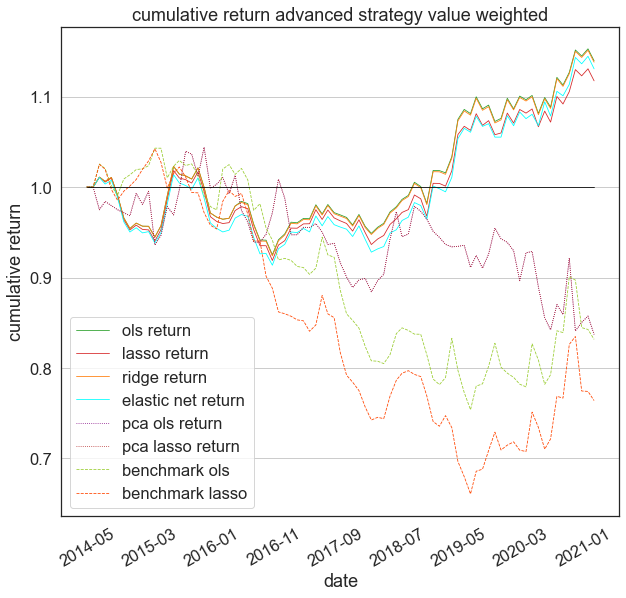

In [35]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_ols_sp['cum_ret_vweight'],c='tab:green', linewidth=0.8)
ax.plot(index,adv_pf_lasso_sp['cum_ret_vweight'],c='tab:red', linewidth=0.8)
ax.plot(index,adv_pf_ridge_sp['cum_ret_vweight'],c='tab:orange', linewidth=0.8)
ax.plot(index,adv_pf_en_sp['cum_ret_vweight'],c='cyan', linewidth=0.8)
ax.plot(index,adv_pf_ols_pca_sp['cum_ret_vweight'],c='purple', linewidth=0.8,linestyle='dotted')
ax.plot(index,adv_pf_lasso_pca_sp['cum_ret_vweight'],c='firebrick', linewidth=0.8,linestyle='dotted')
ax.plot(index,adv_pf_bnch_ols_sp['cum_ret_vweight'],c='yellowgreen', linewidth=0.8, linestyle='--')
ax.plot(index,adv_pf_bnch_lasso_sp['cum_ret_vweight'],c='orangered', linewidth=0.8, linestyle='--')
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy value weighted')

ax.legend(['ols return', 'lasso return', 'ridge return', 'elastic net return', 'pca ols return',
           'pca lasso return', 'benchmark ols', 'benchmark lasso'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'reg_adv_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'reg_adv_val_pf.pdf')

plt.show()


## Regression Portfolios advanced strategy equal weighted

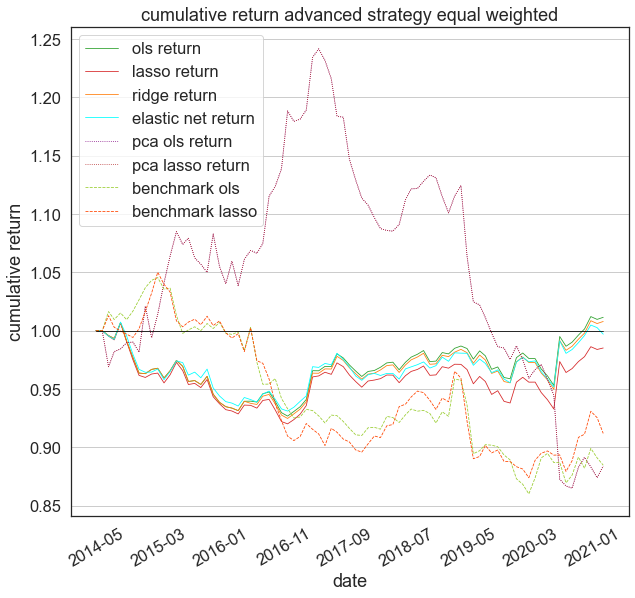

In [36]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_ols_sp['cum_ret_eqweight'],c='tab:green', linewidth=0.8)
ax.plot(index,adv_pf_lasso_sp['cum_ret_eqweight'],c='tab:red', linewidth=0.8)
ax.plot(index,adv_pf_ridge_sp['cum_ret_eqweight'],c='tab:orange', linewidth=0.8)
ax.plot(index,adv_pf_en_sp['cum_ret_eqweight'],c='cyan', linewidth=0.8)
ax.plot(index,adv_pf_ols_pca_sp['cum_ret_eqweight'],c='purple', linewidth=0.8,linestyle='dotted')
ax.plot(index,adv_pf_lasso_pca_sp['cum_ret_eqweight'],c='firebrick', linewidth=0.8,linestyle='dotted')
ax.plot(index,adv_pf_bnch_ols_sp['cum_ret_eqweight'],c='yellowgreen', linewidth=0.8, linestyle='--')
ax.plot(index,adv_pf_bnch_lasso_sp['cum_ret_eqweight'],c='orangered', linewidth=0.8, linestyle='--')
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy equal weighted')

ax.legend(['ols return', 'lasso return', 'ridge return', 'elastic net return', 'pca ols return',
           'pca lasso return', 'benchmark ols', 'benchmark lasso'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()
plt.savefig(path_visuals/'reg_adv_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'reg_ad_eq_pf.pdf')

plt.show()


## Regression Portfolios FF Strategy Value weighted

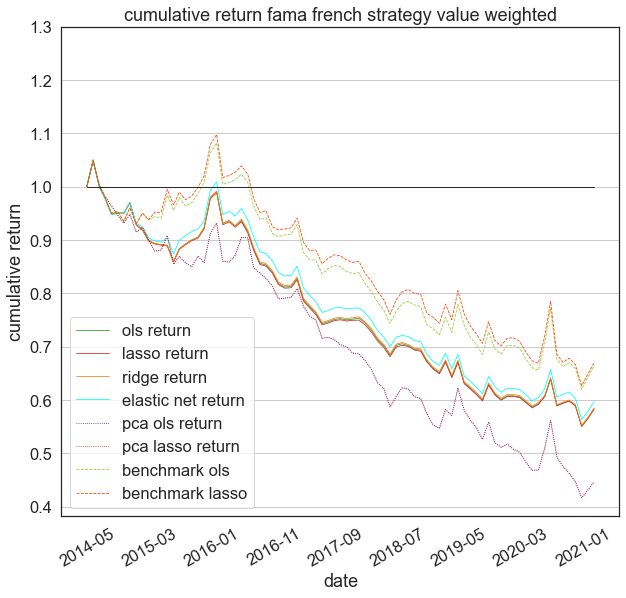

In [37]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_ols_sp['cum_ret_vweight'],c='tab:green', linewidth=0.8)
ax.plot(index,ff_pf_lasso_sp['cum_ret_vweight'],c='tab:red', linewidth=0.8)
ax.plot(index,ff_pf_ridge_sp['cum_ret_vweight'],c='tab:orange', linewidth=0.8)
ax.plot(index,ff_pf_en_sp['cum_ret_vweight'],c='cyan', linewidth=0.8)
ax.plot(index,ff_pf_ols_pca_sp['cum_ret_vweight'],c='purple', linewidth=0.8,linestyle='dotted')
ax.plot(index,ff_pf_lasso_pca_sp['cum_ret_vweight'],c='firebrick', linewidth=0.8,linestyle='dotted')
ax.plot(index,ff_pf_bnch_ols_sp['cum_ret_vweight'],c='yellowgreen', linewidth=0.8, linestyle='--')
ax.plot(index,ff_pf_bnch_lasso_sp['cum_ret_vweight'],c='orangered', linewidth=0.8, linestyle='--')
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy value weighted',
      yticks=np.arange(0.4,1.4,0.1))

ax.legend(['ols return', 'lasso return', 'ridge return', 'elastic net return', 'pca ols return',
           'pca lasso return', 'benchmark ols', 'benchmark lasso'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'reg_ff_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'reg_ff_val_pf.pdf')

plt.show()


## Regression portfolios ff strategy equal weighted

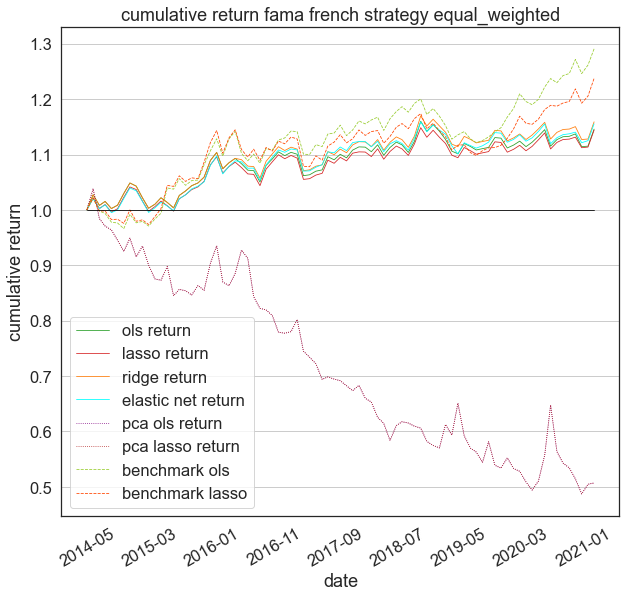

In [38]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='tab:blue', linewidth=2)
ax.plot(index,ff_pf_ols_sp['cum_ret_eqweight'],c='tab:green', linewidth=0.8)
ax.plot(index,ff_pf_lasso_sp['cum_ret_eqweight'],c='tab:red', linewidth=0.8)
ax.plot(index,ff_pf_ridge_sp['cum_ret_eqweight'],c='tab:orange', linewidth=0.8)
ax.plot(index,ff_pf_en_sp['cum_ret_eqweight'],c='cyan', linewidth=0.8)
ax.plot(index,ff_pf_ols_pca_sp['cum_ret_eqweight'],c='purple', linewidth=0.8,linestyle='dotted')
ax.plot(index,ff_pf_lasso_pca_sp['cum_ret_eqweight'],c='firebrick', linewidth=0.8,linestyle='dotted')
ax.plot(index,ff_pf_bnch_ols_sp['cum_ret_eqweight'],c='yellowgreen', linewidth=0.8, linestyle='--')
ax.plot(index,ff_pf_bnch_lasso_sp['cum_ret_eqweight'],c='orangered', linewidth=0.8, linestyle='--')
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy equal_weighted')

ax.legend(['ols return', 'lasso return', 'ridge return', 'elastic net return', 'pca ols return',
           'pca lasso return', 'benchmark ols', 'benchmark lasso'])

ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'reg_ff_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'reg_ff_eq_pf.pdf')

plt.show()


# Portfolio Returns ML models

## advanced strategy value weighted Feedforward models 

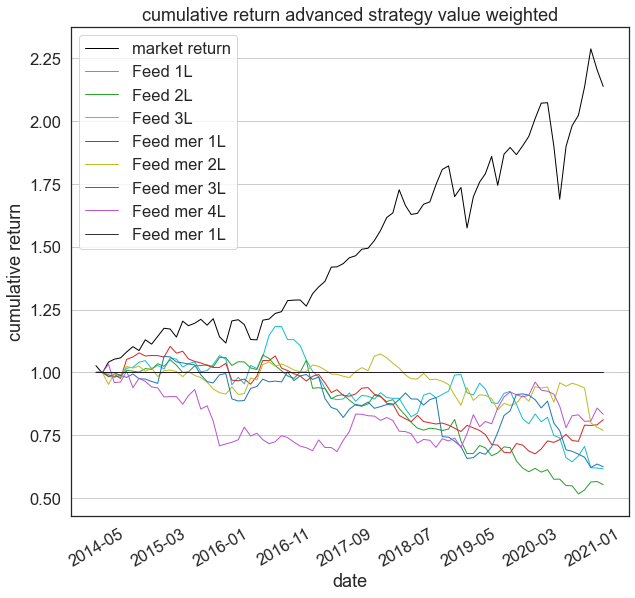

In [39]:
# feed 4L needs to be removed since values are not existent

index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_feed_1L['cum_ret_vweight'],c='tab:cyan', linewidth=1)
ax.plot(index,adv_pf_feed_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_feed_3L['cum_ret_vweight'],c='tab:pink', linewidth=1)
# ax.plot(index,adv_pf_feed_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)
ax.plot(index,adv_pf_feed_merged_1L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_feed_merged_2L['cum_ret_vweight'],c='tab:olive', linewidth=1)
ax.plot(index,adv_pf_feed_merged_3L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_feed_merged_4L['cum_ret_vweight'],c='mediumorchid', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy value weighted')

ax.legend(['market return','Feed 1L', 'Feed 2L', 'Feed 3L', 'Feed mer 1L',
           'Feed mer 2L', 'Feed mer 3L', 'Feed mer 4L', 'Feed mer 1L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'feedforward_adv_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'feedforward_adv_val_pf.pdf')

plt.show()


## Feedforward advanced equal weighted

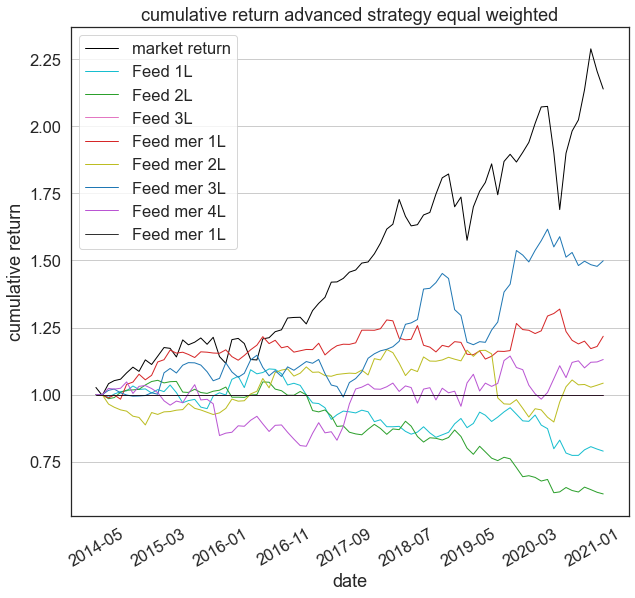

In [40]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_feed_1L['cum_ret_eqweight'],c='tab:cyan', linewidth=1)
ax.plot(index,adv_pf_feed_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_feed_3L['cum_ret_eqweight'],c='tab:pink', linewidth=1)
# ax.plot(index,adv_pf_feed_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)
ax.plot(index,adv_pf_feed_merged_1L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_feed_merged_2L['cum_ret_eqweight'],c='tab:olive', linewidth=1)
ax.plot(index,adv_pf_feed_merged_3L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_feed_merged_4L['cum_ret_eqweight'],c='mediumorchid', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy equal weighted')

ax.legend(['market return','Feed 1L', 'Feed 2L', 'Feed 3L', 'Feed mer 1L',
           'Feed mer 2L', 'Feed mer 3L', 'Feed mer 4L', 'Feed mer 1L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'feedforward_adv_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'feedforward_adv_eq_pf.pdf')

plt.show()


## Feedforward fama french strategy  value weighted

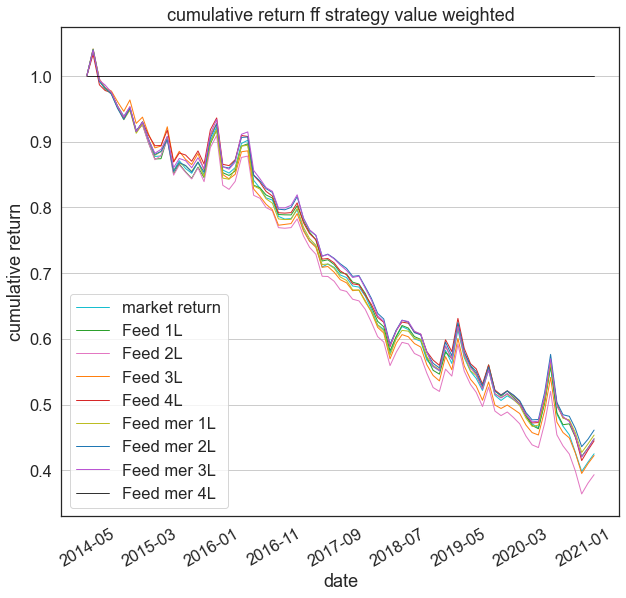

In [41]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_feed_1L['cum_ret_vweight'],c='tab:cyan', linewidth=1)
ax.plot(index,ff_pf_feed_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_feed_3L['cum_ret_vweight'],c='tab:pink', linewidth=1)
ax.plot(index,ff_pf_feed_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)
ax.plot(index,ff_pf_feed_merged_1L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_feed_merged_2L['cum_ret_vweight'],c='tab:olive', linewidth=1)
ax.plot(index,ff_pf_feed_merged_3L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_feed_merged_4L['cum_ret_vweight'],c='mediumorchid', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return ff strategy value weighted')

ax.legend(['market return','Feed 1L', 'Feed 2L', 'Feed 3L', 'Feed 4L' , 'Feed mer 1L',
           'Feed mer 2L', 'Feed mer 3L', 'Feed mer 4L', 'Feed mer 1L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'feedforward_ff_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'feedforward_ff_val_pf.pdf')

plt.show()


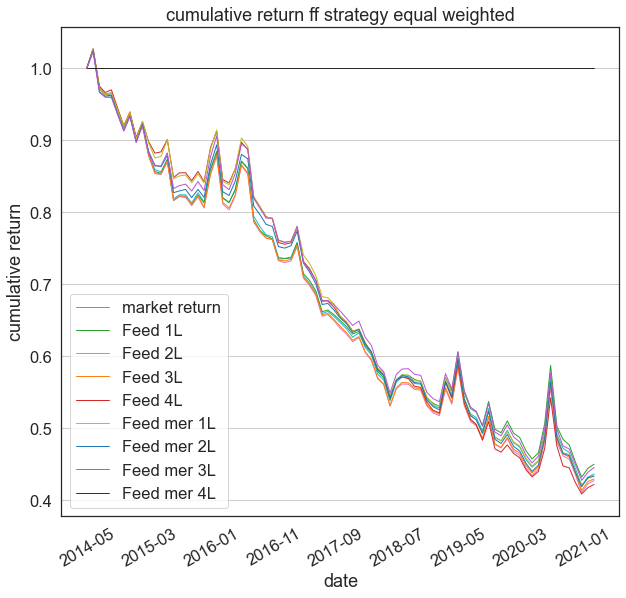

In [42]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_feed_1L['cum_ret_eqweight'],c='tab:cyan', linewidth=1)
ax.plot(index,ff_pf_feed_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_feed_3L['cum_ret_eqweight'],c='tab:pink', linewidth=1)
ax.plot(index,ff_pf_feed_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)
ax.plot(index,ff_pf_feed_merged_1L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_feed_merged_2L['cum_ret_eqweight'],c='tab:olive', linewidth=1)
ax.plot(index,ff_pf_feed_merged_3L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_feed_merged_4L['cum_ret_eqweight'],c='mediumorchid', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return ff strategy equal weighted')

ax.legend(['market return','Feed 1L', 'Feed 2L', 'Feed 3L', 'Feed 4L' , 'Feed mer 1L',
           'Feed mer 2L', 'Feed mer 3L', 'Feed mer 4L', 'Feed mer 1L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'feedforward_ff_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'feedforward_ff_eq_pf.pdf')

plt.show()


## Comparison LSTM factor models advanced value

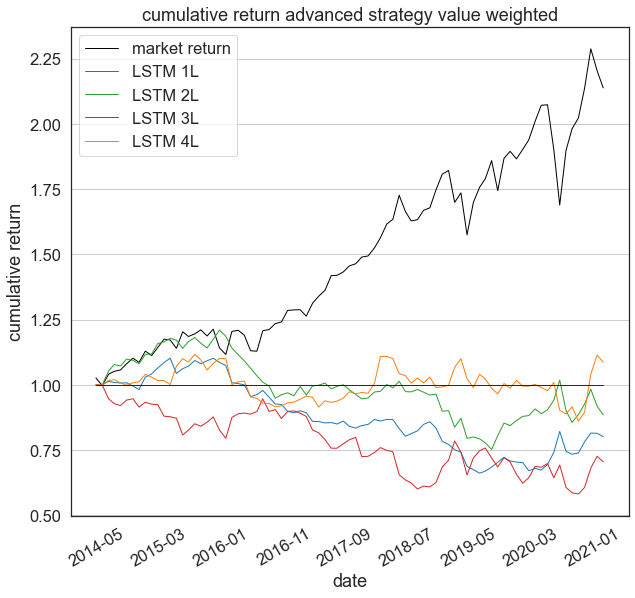

In [43]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_lstm_1L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_lstm_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_lstm_3L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_lstm_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)

ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy value weighted')

ax.legend(['market return', 'LSTM 1L', 'LSTM 2L', 'LSTM 3L','LSTM 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_adv_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_adv_val_pf.pdf')

plt.show()


## LSTM factor advanced equal weighted 

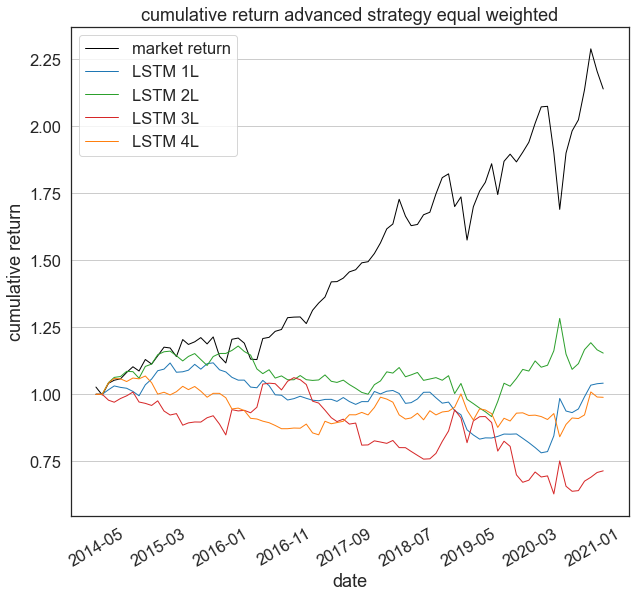

In [44]:
# index = pd.to_datetime(adv_pf_market.index)
# baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_lstm_1L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_lstm_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_lstm_3L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_lstm_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy equal weighted')

ax.legend(['market return', 'LSTM 1L', 'LSTM 2L', 'LSTM 3L','LSTM 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_adv_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_adv_eq_pf.pdf')

plt.show()


## LSTM Factor models ff strategy value weighted

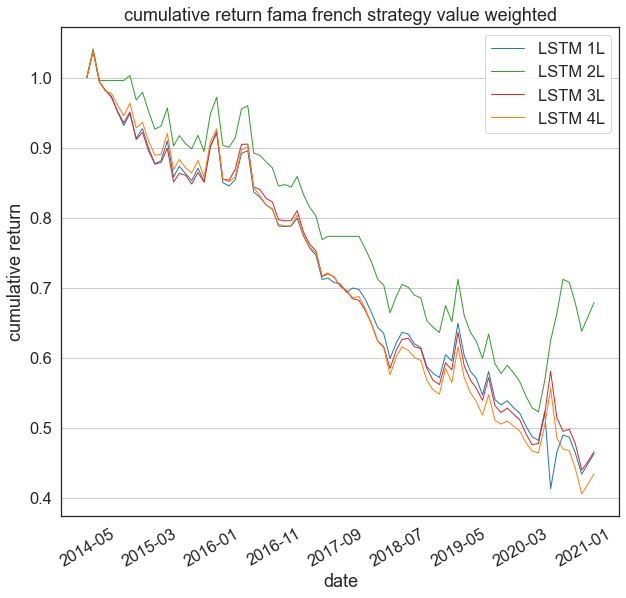

In [45]:
# index = pd.to_datetime(adv_pf_market.index)
# baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_lstm_1L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_lstm_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_lstm_3L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_lstm_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy value weighted')

ax.legend(['LSTM 1L', 'LSTM 2L', 'LSTM 3L','LSTM 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_ff_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_ff_val_pf.pdf')

plt.show()


## LSTM model FF equal weighted

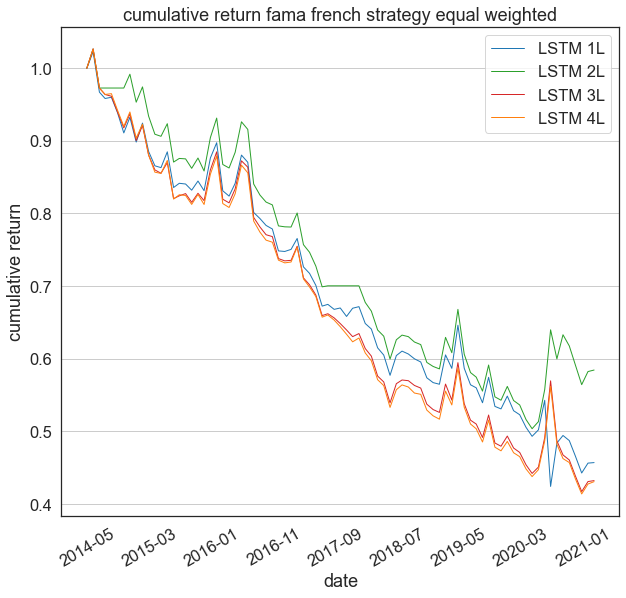

In [46]:
# index = pd.to_datetime(adv_pf_market.index)
# baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_lstm_1L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_lstm_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_lstm_3L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_lstm_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy equal weighted')

ax.legend(['LSTM 1L', 'LSTM 2L', 'LSTM 3L','LSTM 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_ff_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_ff_eq_pf.pdf')

plt.show()


## LSTM merged model advanced value

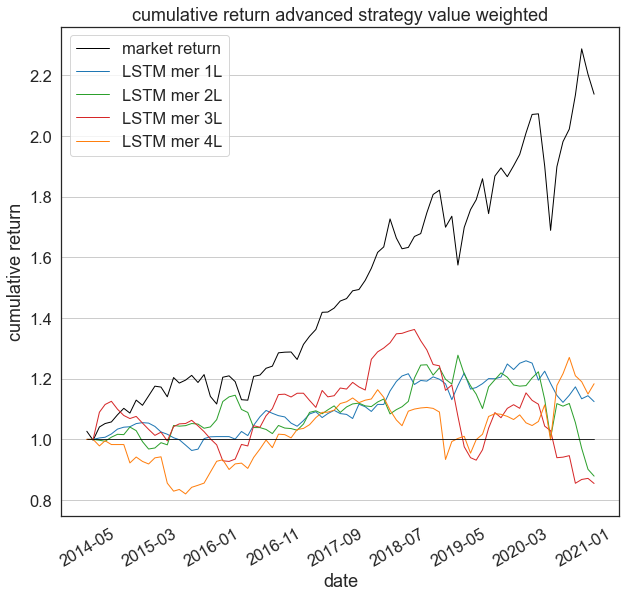

In [47]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_1L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_3L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy value weighted')

ax.legend(['market return','LSTM mer 1L','LSTM mer 2L', 'LSTM mer 3L', 'LSTM mer 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_merged_adv_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_merged_adv_val_pf.pdf')

plt.show()


## LSTM merged advanced equal

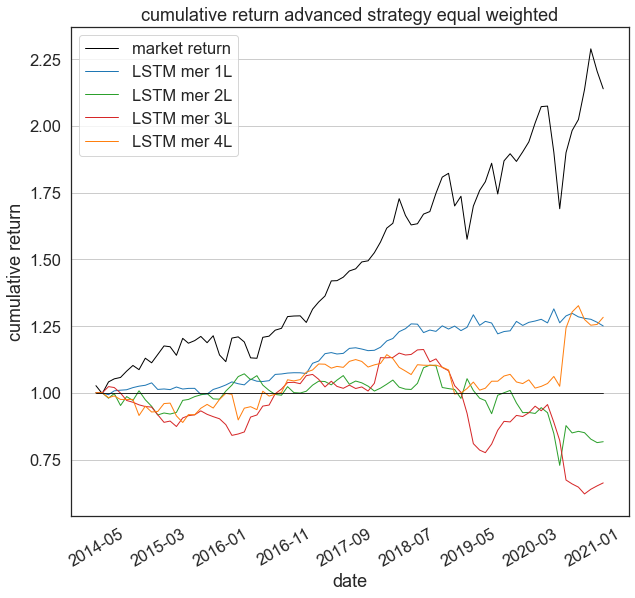

In [48]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_1L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_3L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy equal weighted')

ax.legend(['market return','LSTM mer 1L','LSTM mer 2L', 'LSTM mer 3L', 'LSTM mer 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_merged_adv_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_merged_adv_eq_pf.pdf')

plt.show()


## LSTM merged FF strategy value weighted

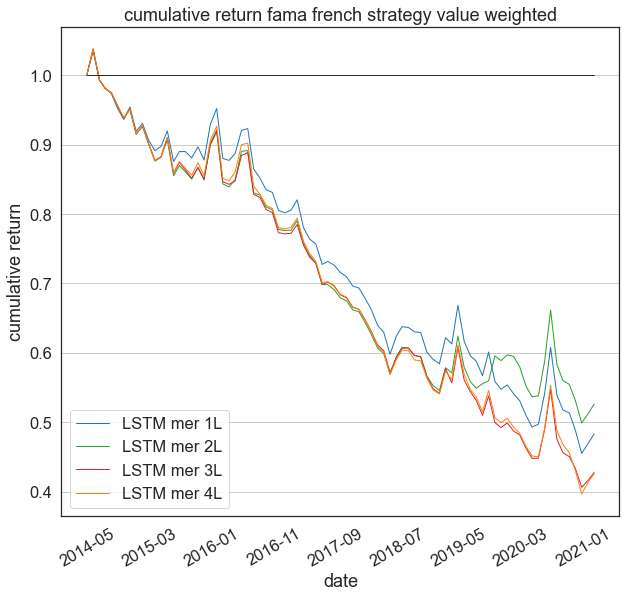

In [49]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_1L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_3L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy value weighted')

ax.legend(['LSTM mer 1L','LSTM mer 2L', 'LSTM mer 3L', 'LSTM mer 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_merged_ff_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_merged_ff_val_pf.pdf')

plt.show()


 ## LSTM merged ff equal weighted

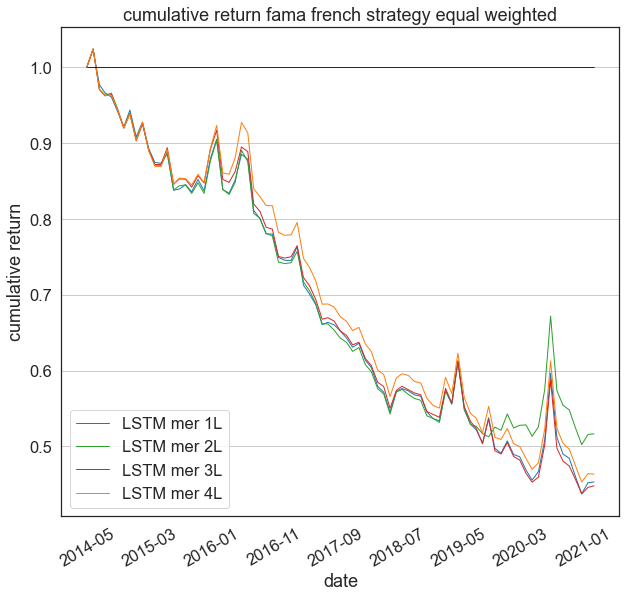

In [50]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_1L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_3L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_lstm_merged_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy equal weighted')

ax.legend(['LSTM mer 1L','LSTM mer 2L', 'LSTM mer 3L', 'LSTM mer 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'LSTM_merged_ff_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'LSTM_merged_ff_eq_pf.pdf')

plt.show()


## Advanced strategy value weighted FFN 

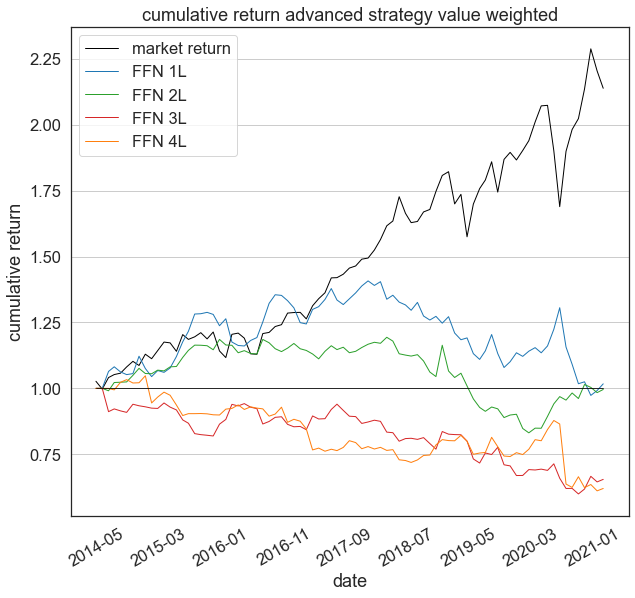

In [51]:
index = pd.to_datetime(adv_pf_FFN_1L.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_FFN_1L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_FFN_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_FFN_3L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_FFN_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy value weighted')

ax.legend(['market return', 'FFN 1L', 'FFN 2L', 'FFN 3L','FFN 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'FFN_adv_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'FFN_adv_val_pf.pdf')

plt.show()


## Advanced strategy FFN equal weighted 


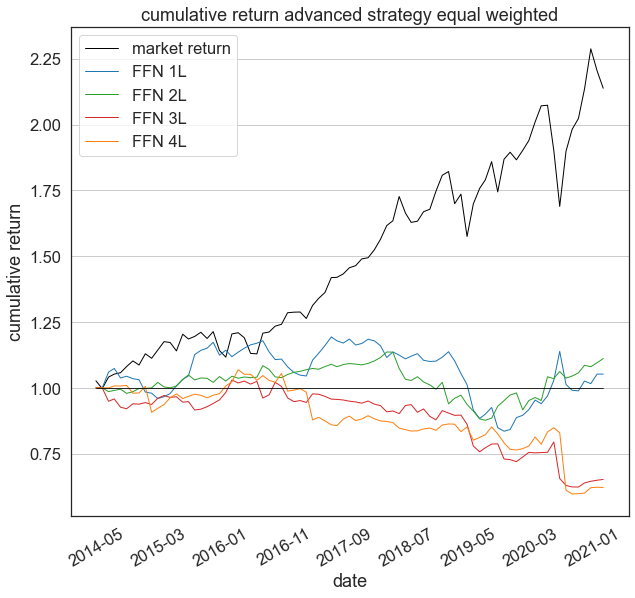

In [52]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_FFN_1L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,adv_pf_FFN_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_FFN_3L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,adv_pf_FFN_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy equal weighted')

ax.legend(['market return', 'FFN 1L', 'FFN 2L', 'FFN 3L','FFN 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'FFN_adv_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'FFN_adv_eq_pf.pdf')

plt.show()


## FF strategy FFN value weighted

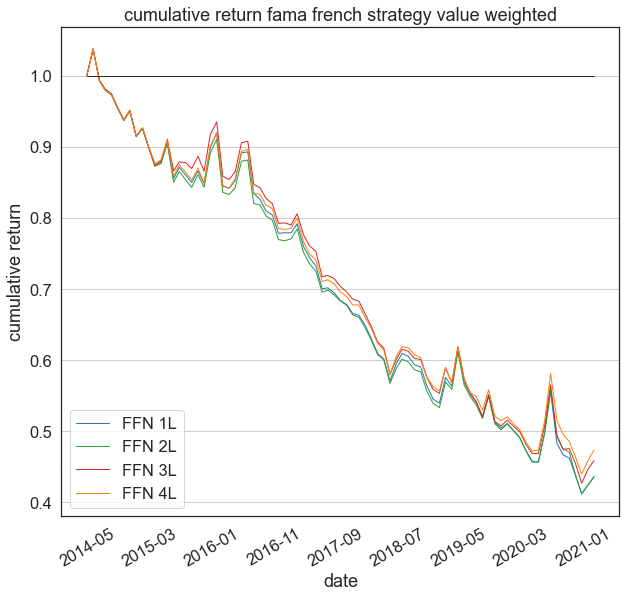

In [53]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_FFN_1L['cum_ret_vweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_FFN_2L['cum_ret_vweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_FFN_3L['cum_ret_vweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_FFN_4L['cum_ret_vweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy value weighted')

ax.legend(['FFN 1L', 'FFN 2L', 'FFN 3L','FFN 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'FFN_ff_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'FFN_ff_val_pf.pdf')

plt.show()


## FFN Fama Frencg Strategy equal weighetd

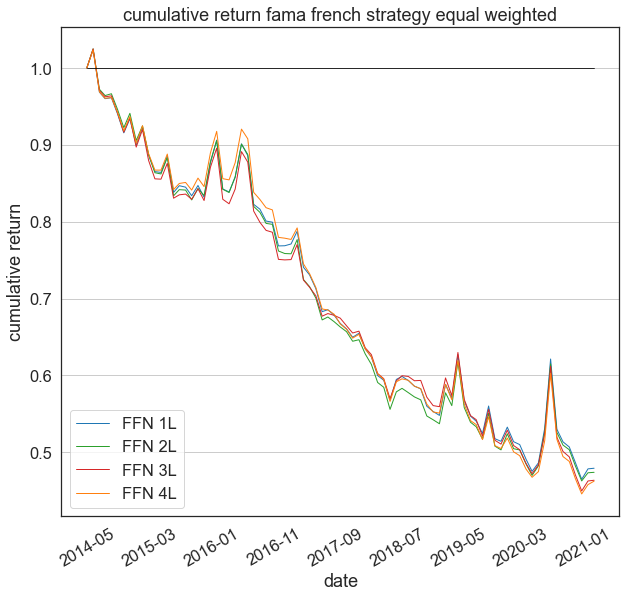

In [54]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_FFN_1L['cum_ret_eqweight'],c='tab:blue', linewidth=1)
ax.plot(index,ff_pf_FFN_2L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,ff_pf_FFN_3L['cum_ret_eqweight'],c='tab:red', linewidth=1)
ax.plot(index,ff_pf_FFN_4L['cum_ret_eqweight'],c='tab:orange', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy equal weighted')

ax.legend(['FFN 1L', 'FFN 2L', 'FFN 3L','FFN 4L'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'FFN_ff_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'FFN_ff_eq_pf.pdf')

plt.show()


## Advanced Strategy Value weighted XGB

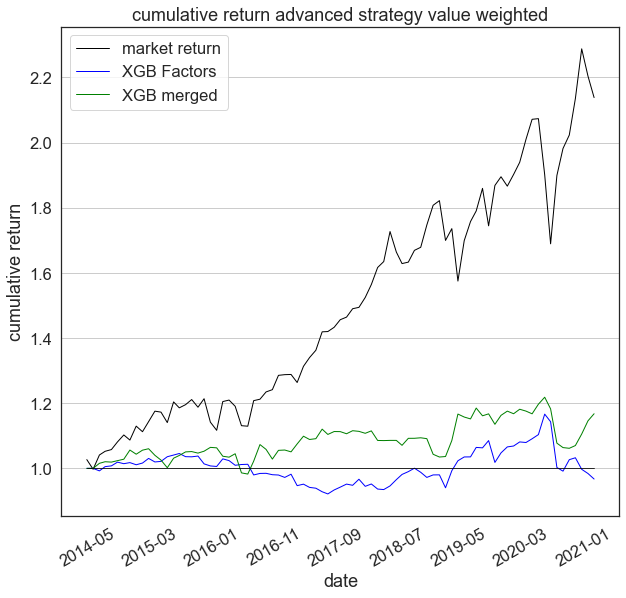

In [55]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_xgb_factors['cum_ret_vweight'],c='blue', linewidth=1)
ax.plot(index,adv_pf_xgb_merged['cum_ret_vweight'],c='green', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy value weighted')

ax.legend(['market return', 'XGB Factors', 'XGB merged'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'xgb_adv_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'xgb_adv_val_pf.pdf')

plt.show()


# Advanced strategy equal weighted XGB

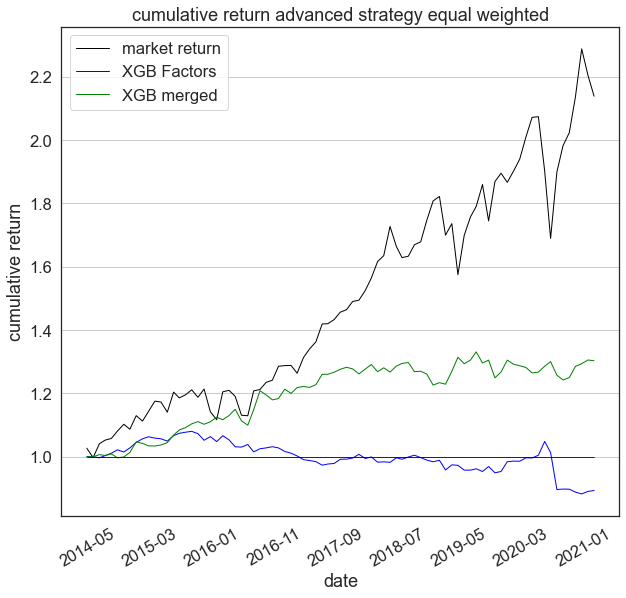

In [56]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,adv_pf_xgb_factors['cum_ret_eqweight'],c='blue', linewidth=1)
ax.plot(index,adv_pf_xgb_merged['cum_ret_eqweight'],c='green', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy equal weighted')

ax.legend(['market return','XGB Factors', 'XGB merged'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'xgb_adv_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'xgb_adv_eq_pf.pdf')

plt.show()


## XGB Fama French Strategy value weighted

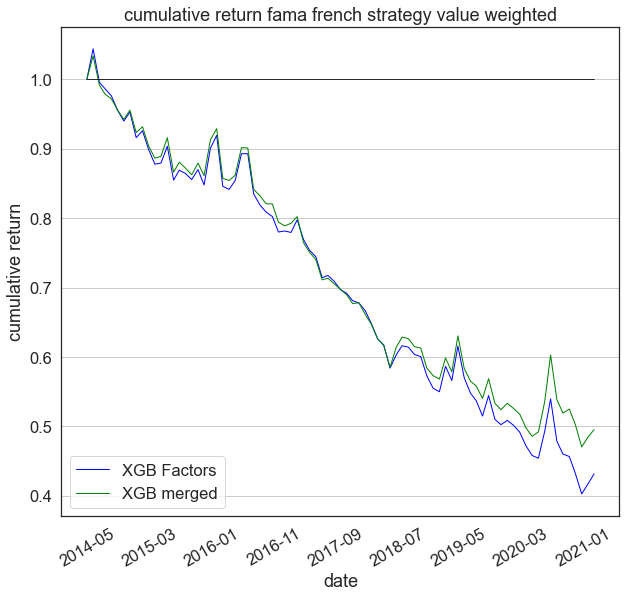

In [57]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_xgb_factors['cum_ret_vweight'],c='blue', linewidth=1)
ax.plot(index,ff_pf_xgb_merged['cum_ret_vweight'],c='green', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy value weighted')

ax.legend(['XGB Factors', 'XGB merged'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'xgb_ff_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'xgb_ff_val_pf.pdf')

plt.show()


## XGB Fama french strategy equal weighted

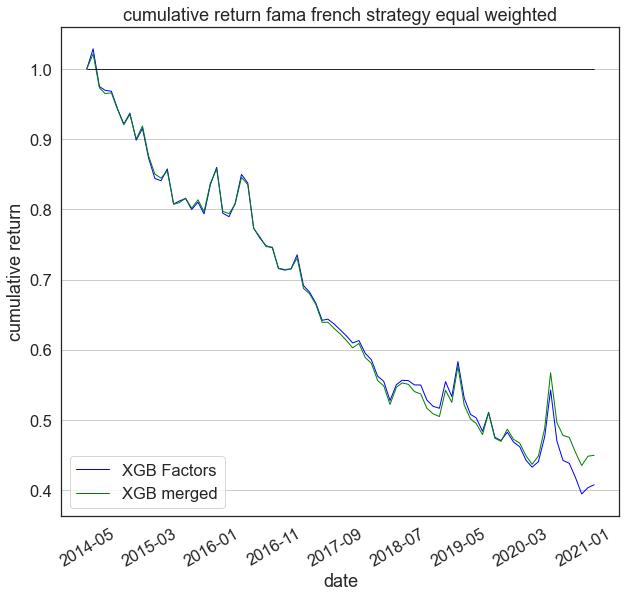

In [58]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_xgb_factors['cum_ret_eqweight'],c='blue', linewidth=1)
ax.plot(index,ff_pf_xgb_merged['cum_ret_eqweight'],c='green', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return fama french strategy equal weighted')

ax.legend(['XGB Factors', 'XGB merged'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'xgb_ff_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'xgb_ff_eq_pf.pdf')

plt.show()


# Best model comparison

## Advanced Strategy Value weighted 

In [59]:
adv_pf_ols_sp['cum_ret_vweight'][-1]

1.139738615716293

In [60]:
adv_pf_bnch_lasso_sp['cum_ret_vweight'][-1]

0.7638889835828894

In [61]:
best_models_adv = {}
best_models_adv['OLS'] =  adv_pf_ols_sp['cum_ret_vweight'][-1]
best_models_adv['Lasso'] = adv_pf_lasso_sp['cum_ret_vweight'][-1]
best_models_adv['ridge'] = adv_pf_ridge_sp['cum_ret_vweight'][-1]
best_models_adv['en'] = adv_pf_en_sp['cum_ret_vweight'][-1]
best_models_adv['bnch OLS'] = adv_pf_bnch_ols_sp['cum_ret_vweight'][-1]
best_models_adv['bnch Lasso'] = adv_pf_bnch_lasso_sp['cum_ret_vweight'][-1]
best_models_adv['OLS pca'] = adv_pf_ols_pca_sp['cum_ret_vweight'][-1]
best_models_adv['Lasso pca'] = adv_pf_lasso_pca_sp['cum_ret_vweight'][-1]
best_models_adv['feed 1']    = adv_pf_feed_1L['cum_ret_vweight'][-1]
best_models_adv['feed 2'] = adv_pf_feed_2L['cum_ret_vweight'][-1]
best_models_adv['feed 3'] = adv_pf_feed_3L['cum_ret_vweight'][-1]
best_models_adv['feed 4'] = adv_pf_feed_4L['cum_ret_vweight'][-1]
best_models_adv['feed m 1'] = adv_pf_feed_merged_1L['cum_ret_vweight'][-1]
best_models_adv['feed m 2'] = adv_pf_feed_merged_2L['cum_ret_vweight'][-1]
best_models_adv['feed m 3'] = adv_pf_feed_merged_3L['cum_ret_vweight'][-1]
best_models_adv['feed m 4'] = adv_pf_feed_merged_4L['cum_ret_vweight'][-1]
best_models_adv['LSTM f 1'] = adv_pf_lstm_1L['cum_ret_vweight'][-1]
best_models_adv['LSTM f 2'] = adv_pf_lstm_2L['cum_ret_vweight'][-1]
best_models_adv['LSTM f 3'] = adv_pf_lstm_3L['cum_ret_vweight'][-1]
best_models_adv['LSTM f 4'] = adv_pf_lstm_4L['cum_ret_vweight'][-1]
best_models_adv['LSTM m 1'] = adv_pf_lstm_merged_1L['cum_ret_vweight'][-1]
best_models_adv['LSTM m 2'] = adv_pf_lstm_merged_2L['cum_ret_vweight'][-1]
best_models_adv['LSTM m 3'] = adv_pf_lstm_merged_3L['cum_ret_vweight'][-1]
best_models_adv['LSTM m 4'] = adv_pf_lstm_merged_4L['cum_ret_vweight'][-1]
best_models_adv['FFN 1'] = adv_pf_FFN_1L['cum_ret_vweight'][-1]
best_models_adv['FFN 2'] = adv_pf_FFN_2L['cum_ret_vweight'][-1]
best_models_adv['FFN 3'] = adv_pf_FFN_3L['cum_ret_vweight'][-1]
best_models_adv['FFN 4'] = adv_pf_FFN_4L['cum_ret_vweight'][-1]
best_models_adv['XGB f'] = adv_pf_xgb_factors['cum_ret_vweight'][-1]
best_models_adv['XGB m'] = adv_pf_xgb_merged['cum_ret_vweight'][-1]
# best_models_adv = best_models_adv.transpose()
best_models_adv

best_models_list = sorted(best_models_adv.items(), key=lambda x:x[1])
sortdict = dict(best_models_list)
sortdict

{'feed 2': 0.5530114307623358,
 'feed 1': 0.6162204242056201,
 'FFN 4': 0.6203541006086294,
 'feed m 3': 0.6242491976465795,
 'FFN 3': 0.6548423132257487,
 'LSTM f 3': 0.705570786981122,
 'bnch Lasso': 0.7638889835828894,
 'feed m 2': 0.7692153620403381,
 'LSTM f 1': 0.8016651132723297,
 'feed m 1': 0.8119696999912941,
 'bnch OLS': 0.8316014091482606,
 'feed m 4': 0.8332039840349478,
 'OLS pca': 0.8371250631015253,
 'Lasso pca': 0.8371250631015253,
 'LSTM m 3': 0.8548012909375856,
 'LSTM m 2': 0.8790365967660864,
 'LSTM f 2': 0.8855117422047828,
 'XGB f': 0.9672960262742056,
 'FFN 2': 0.9958436732449574,
 'feed 3': 1,
 'FFN 1': 1.0171526320839452,
 'LSTM f 4': 1.0875754003805402,
 'Lasso': 1.1175725010993,
 'LSTM m 1': 1.124697809674266,
 'en': 1.1308288992367863,
 'ridge': 1.138237874172382,
 'OLS': 1.139738615716293,
 'XGB m': 1.167642313194297,
 'feed 4': 1.173649087548256,
 'LSTM m 4': 1.1835785814239816}

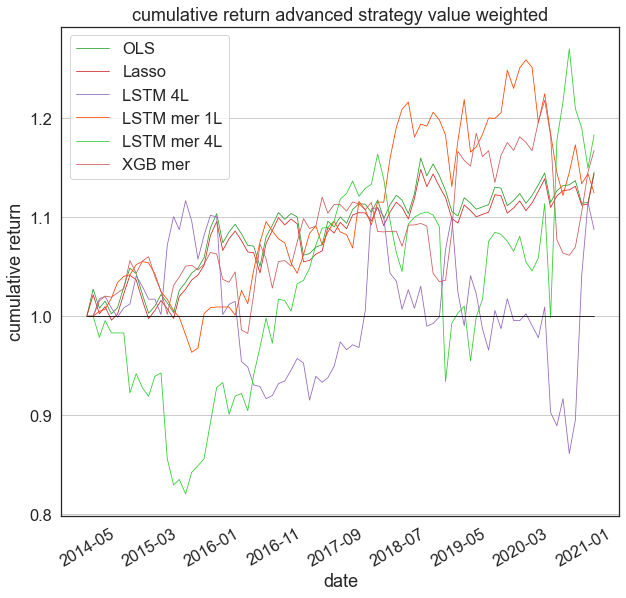

In [62]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))
# ax.plot(index,market_return_sp['total_ret_value'],c='black', linewidth=1)
ax.plot(index,ff_pf_ols_sp['cum_ret_eqweight'],c='tab:green', linewidth=0.8)
ax.plot(index,ff_pf_lasso_sp['cum_ret_eqweight'],c='tab:red', linewidth=0.8)
ax.plot(index,adv_pf_lstm_4L['cum_ret_vweight'],c='tab:purple', linewidth=0.8)
ax.plot(index,adv_pf_lstm_merged_1L['cum_ret_vweight'],c='orangered', linewidth=0.8)
ax.plot(index,adv_pf_lstm_merged_4L['cum_ret_vweight'],c='limegreen', linewidth=0.8)
ax.plot(index,adv_pf_xgb_merged['cum_ret_vweight'],c='indianred', linewidth=0.8)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='cumulative return advanced strategy value weighted')

ax.legend(['OLS', 'Lasso',  'LSTM 4L', 'LSTM mer 1L', 
           'LSTM mer 4L','XGB mer'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'best_adv_val_pf.jpg', dpi=300)
plt.savefig(path_visuals/'best_adv_val_pf.pdf')

plt.show()


## Advanced Startegy Equal weighted 

In [63]:
best_models_adv = {}
best_models_adv['OLS'] =  adv_pf_ols_sp['cum_ret_eqweight'][-1]
best_models_adv['Lasso'] = adv_pf_lasso_sp['cum_ret_eqweight'][-1]
best_models_adv['ridge'] = adv_pf_ridge_sp['cum_ret_eqweight'][-1]
best_models_adv['en'] = adv_pf_en_sp['cum_ret_eqweight'][-1]
best_models_adv['bnch OLS'] = adv_pf_bnch_ols_sp['cum_ret_eqweight'][-1]
best_models_adv['bnch Lasso'] = adv_pf_bnch_lasso_sp['cum_ret_eqweight'][-1]
best_models_adv['OLS pca'] = adv_pf_ols_pca_sp['cum_ret_eqweight'][-1]
best_models_adv['Lasso pca'] = adv_pf_lasso_pca_sp['cum_ret_eqweight'][-1]
best_models_adv['feed 1']    = adv_pf_feed_1L['cum_ret_eqweight'][-1]
best_models_adv['feed 2'] = adv_pf_feed_2L['cum_ret_eqweight'][-1]
best_models_adv['feed 3'] = adv_pf_feed_3L['cum_ret_eqweight'][-1]
best_models_adv['feed 4'] = adv_pf_feed_4L['cum_ret_eqweight'][-1]
best_models_adv['feed m 1'] = adv_pf_feed_merged_1L['cum_ret_eqweight'][-1]
best_models_adv['feed m 2'] = adv_pf_feed_merged_2L['cum_ret_eqweight'][-1]
best_models_adv['feed m 3'] = adv_pf_feed_merged_3L['cum_ret_eqweight'][-1]
best_models_adv['feed m 4'] = adv_pf_feed_merged_4L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 1'] = adv_pf_lstm_1L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 2'] = adv_pf_lstm_2L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 3'] = adv_pf_lstm_3L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 4'] = adv_pf_lstm_4L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 1'] = adv_pf_lstm_merged_1L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 2'] = adv_pf_lstm_merged_2L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 3'] = adv_pf_lstm_merged_3L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 4'] = adv_pf_lstm_merged_4L['cum_ret_eqweight'][-1]
best_models_adv['FFN 1'] = adv_pf_FFN_1L['cum_ret_eqweight'][-1]
best_models_adv['FFN 2'] = adv_pf_FFN_2L['cum_ret_eqweight'][-1]
best_models_adv['FFN 3'] = adv_pf_FFN_3L['cum_ret_eqweight'][-1]
best_models_adv['FFN 4'] = adv_pf_FFN_4L['cum_ret_eqweight'][-1]
best_models_adv['XGB f'] = adv_pf_xgb_factors['cum_ret_eqweight'][-1]
best_models_adv['XGB m'] = adv_pf_xgb_merged['cum_ret_eqweight'][-1]
# best_models_adv = best_models_adv.transpose()
best_models_adv

best_models_list = sorted(best_models_adv.items(), key=lambda x:x[1])
sortdict = dict(best_models_list)
sortdict

{'FFN 4': 0.6217948802691728,
 'feed 2': 0.6305312620456662,
 'FFN 3': 0.6523068050054885,
 'LSTM m 3': 0.6628551866869568,
 'LSTM f 3': 0.7145477687921794,
 'feed 1': 0.7899584293196157,
 'LSTM m 2': 0.8171237691727188,
 'OLS pca': 0.8839966420736495,
 'Lasso pca': 0.8839966420736495,
 'bnch OLS': 0.8847518412056519,
 'XGB f': 0.8933284713956438,
 'bnch Lasso': 0.9119803803467273,
 'Lasso': 0.9851935351658236,
 'LSTM f 4': 0.9886704408868248,
 'en': 0.9970274269614146,
 'feed 3': 1,
 'ridge': 1.0079214157352892,
 'OLS': 1.0114882055906473,
 'LSTM f 1': 1.041386623497199,
 'feed m 2': 1.0430190899295262,
 'FFN 1': 1.0524567609353939,
 'FFN 2': 1.1114833669865405,
 'feed m 4': 1.1309704112630847,
 'LSTM f 2': 1.1535510695207754,
 'feed 4': 1.173649087548256,
 'feed m 1': 1.2175289706841104,
 'LSTM m 1': 1.2503924843311043,
 'LSTM m 4': 1.2828445279627532,
 'XGB m': 1.3029755245769994,
 'feed m 3': 1.4985639137131732}

## FF Strategy Value weighted 

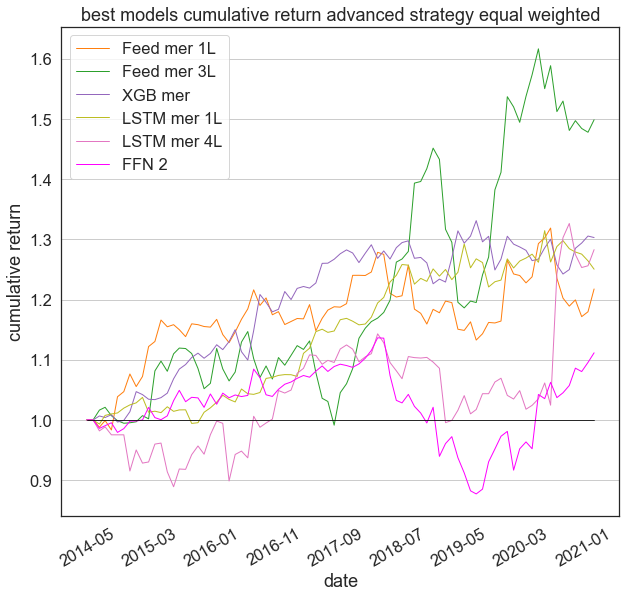

In [64]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(index,adv_pf_feed_merged_1L['cum_ret_eqweight'],c='tab:orange', linewidth=1)
ax.plot(index,adv_pf_feed_merged_3L['cum_ret_eqweight'],c='tab:green', linewidth=1)
ax.plot(index,adv_pf_xgb_merged['cum_ret_eqweight'],c='tab:purple', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_1L['cum_ret_eqweight'],c='tab:olive', linewidth=1)
ax.plot(index,adv_pf_lstm_merged_4L['cum_ret_eqweight'],c='tab:pink', linewidth=1)
ax.plot(index,adv_pf_FFN_2L['cum_ret_eqweight'],c='magenta', linewidth=1)
ax.plot(index,baseline  ,c='black', linewidth=0.8, alpha =1)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='best models cumulative return advanced strategy equal weighted')

ax.legend(['Feed mer 1L', 'Feed mer 3L', 'XGB mer', 
            'LSTM mer 1L', 'LSTM mer 4L','FFN 2'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'best_adv_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'best_adv_eq_pf.pdf')

plt.show()


## FF Strategy Equal weighted

In [65]:
best_models_adv = {}
best_models_adv['OLS'] =  ff_pf_ols_sp['cum_ret_eqweight'][-1]
best_models_adv['Lasso'] = ff_pf_lasso_sp['cum_ret_eqweight'][-1]
best_models_adv['ridge'] = ff_pf_ridge_sp['cum_ret_eqweight'][-1]
best_models_adv['en'] = ff_pf_en_sp['cum_ret_eqweight'][-1]
best_models_adv['bnch OLS'] = ff_pf_bnch_ols_sp['cum_ret_eqweight'][-1]
best_models_adv['bnch Lasso'] = ff_pf_bnch_lasso_sp['cum_ret_eqweight'][-1]
best_models_adv['OLS pca'] = ff_pf_ols_pca_sp['cum_ret_eqweight'][-1]
best_models_adv['Lasso pca'] = ff_pf_lasso_pca_sp['cum_ret_eqweight'][-1]
best_models_adv['feed 1']    = ff_pf_feed_1L['cum_ret_eqweight'][-1]
best_models_adv['feed 2'] = ff_pf_feed_2L['cum_ret_eqweight'][-1]
best_models_adv['feed 3'] = ff_pf_feed_3L['cum_ret_eqweight'][-1]
best_models_adv['feed 4'] = ff_pf_feed_4L['cum_ret_eqweight'][-1]
best_models_adv['feed m 1'] = ff_pf_feed_merged_1L['cum_ret_eqweight'][-1]
best_models_adv['feed m 2'] = ff_pf_feed_merged_2L['cum_ret_eqweight'][-1]
best_models_adv['feed m 3'] = ff_pf_feed_merged_3L['cum_ret_eqweight'][-1]
best_models_adv['feed m 4'] = ff_pf_feed_merged_4L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 1'] = ff_pf_lstm_1L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 2'] = ff_pf_lstm_2L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 3'] = ff_pf_lstm_3L['cum_ret_eqweight'][-1]
best_models_adv['LSTM f 4'] = ff_pf_lstm_4L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 1'] = ff_pf_lstm_merged_1L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 2'] = ff_pf_lstm_merged_2L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 3'] = ff_pf_lstm_merged_3L['cum_ret_eqweight'][-1]
best_models_adv['LSTM m 4'] = ff_pf_lstm_merged_4L['cum_ret_eqweight'][-1]
best_models_adv['FFN 1'] = ff_pf_FFN_1L['cum_ret_eqweight'][-1]
best_models_adv['FFN 2'] = ff_pf_FFN_2L['cum_ret_eqweight'][-1]
best_models_adv['FFN 3'] = ff_pf_FFN_3L['cum_ret_eqweight'][-1]
best_models_adv['FFN 4'] = ff_pf_FFN_4L['cum_ret_eqweight'][-1]
best_models_adv['XGB f'] = ff_pf_xgb_factors['cum_ret_eqweight'][-1]
best_models_adv['XGB m'] = ff_pf_xgb_merged['cum_ret_eqweight'][-1]
# best_models_adv = best_models_adv.transpose()
best_models_adv

best_models_list = sorted(best_models_adv.items(), key=lambda x:x[1])
sortdict = dict(best_models_list)
sortdict

{'XGB f': 0.4075895127825467,
 'feed m 1': 0.42165633634828004,
 'feed 3': 0.427008909600821,
 'feed 4': 0.42933391122585507,
 'LSTM f 4': 0.43078185618409187,
 'LSTM f 3': 0.4322142312463507,
 'feed m 3': 0.4330380404667698,
 'feed m 2': 0.4353460976622636,
 'feed 1': 0.4362007987519827,
 'feed m 4': 0.4453316068954024,
 'LSTM m 3': 0.44815415446026785,
 'XGB m': 0.44952249232595487,
 'feed 2': 0.44978109226859087,
 'LSTM m 1': 0.45326196148613807,
 'LSTM f 1': 0.45701166059942366,
 'FFN 4': 0.46243103972688215,
 'LSTM m 4': 0.4634988960716466,
 'FFN 3': 0.4636269219356886,
 'FFN 2': 0.4739464500229216,
 'FFN 1': 0.4792643209300172,
 'OLS pca': 0.507067762013638,
 'Lasso pca': 0.507067762013638,
 'LSTM m 2': 0.5166993995511022,
 'LSTM f 2': 0.5844530065052375,
 'Lasso': 1.1440382633003032,
 'OLS': 1.1457319016056253,
 'en': 1.1553671695068168,
 'ridge': 1.1589702112321116,
 'bnch Lasso': 1.237420448406475,
 'bnch OLS': 1.2907598705162282}

## best model ff strategy 

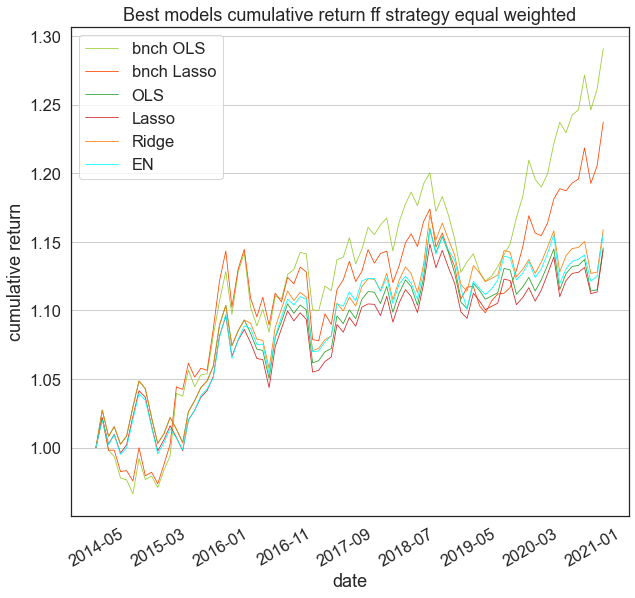

In [66]:
index = pd.to_datetime(adv_pf_market.index)
baseline = np.ones(len(adv_pf_bnch_lasso_sp))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(index,ff_pf_bnch_ols_sp['cum_ret_eqweight'],c='yellowgreen', linewidth=0.8)
ax.plot(index,ff_pf_bnch_lasso_sp['cum_ret_eqweight'],c='orangered', linewidth=0.8)
ax.plot(index,ff_pf_ols_sp['cum_ret_eqweight'],c='tab:green', linewidth=0.8)
ax.plot(index,ff_pf_lasso_sp['cum_ret_eqweight'],c='tab:red', linewidth=0.8)
ax.plot(index,ff_pf_ridge_sp['cum_ret_eqweight'],c='tab:orange', linewidth=0.8)
ax.plot(index,ff_pf_en_sp['cum_ret_eqweight'],c='cyan', linewidth=0.8)

ax.set(xlabel='date',
      ylabel ='cumulative return',
      title='Best models cumulative return ff strategy equal weighted')

ax.legend(['bnch OLS','bnch Lasso', 'OLS', 'Lasso', 'Ridge', 'EN'])


ax.grid(axis='y')
date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

plt.gcf().autofmt_xdate()

plt.savefig(path_visuals/'best_ff_eq_pf.jpg', dpi=300)
plt.savefig(path_visuals/'best_ff_eq_pf.pdf')

plt.show()


## r2 scores

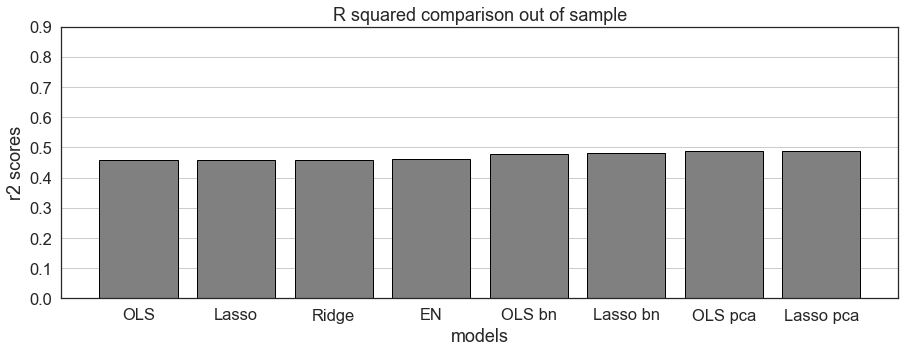

In [67]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))


ax.bar('OLS', OLS_metrics.loc['r2',:].values[0], color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',Lasso_metrics.loc['r2',:].values[0], color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', Ridge_metrics.loc['r2',:].values[0], color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', EN_metrics.loc['r2',:].values[0],color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', OLS_bnch_metrics.loc['r2',:].values[0],color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', Lasso_bnch_metrics.loc['r2',:].values[0], color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', OLS_pca_metrics.loc['r2',:].values[0], color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', Lasso_pca_metrics.loc['r2',:].values[0], color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='r2 scores',
      title='R squared comparison out of sample',
      yticks=np.arange(0,1,0.1))

plt.savefig(path_visuals/'r2_scores_reg_oss.jpg', dpi=300)
plt.savefig(path_visuals/'r2_scores_reg_oss.pdf')

plt.show()

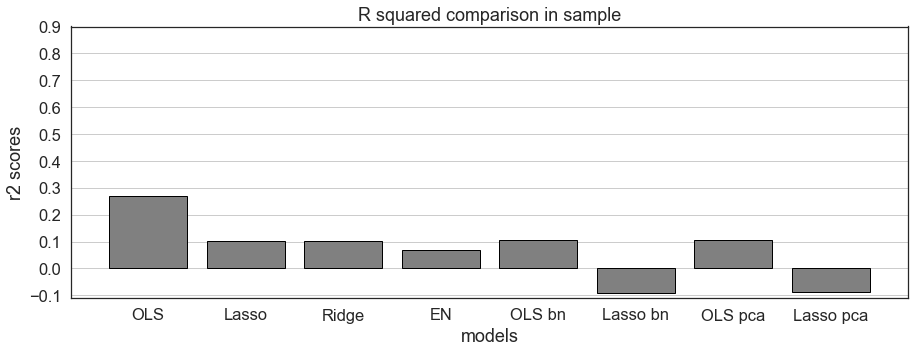

In [68]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))


ax.bar('OLS', OLS_metrics.loc['r2_iss',:].values[0], color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',Lasso_metrics.loc['r2_iss',:].values[0], color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', Ridge_metrics.loc['r2_iss',:].values[0], color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', EN_metrics.loc['r2_iss',:].values[0],color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', OLS_bnch_metrics.loc['r2_iss',:].values[0],color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', Lasso_bnch_metrics.loc['r2_iss',:].values[0], color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', OLS_pca_metrics.loc['r2_iss',:].values[0], color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', Lasso_pca_metrics.loc['r2_iss',:].values[0], color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='r2 scores',
      title='R squared comparison in sample',
      yticks=np.arange(-0.1,1,0.1))

plt.savefig(path_visuals/'r2_scores_reg_iss.jpg', dpi=300)
plt.savefig(path_visuals/'r2_scores_reg_iss.pdf')

plt.show()

 ## R2 score s&p data reg

### In sample reg

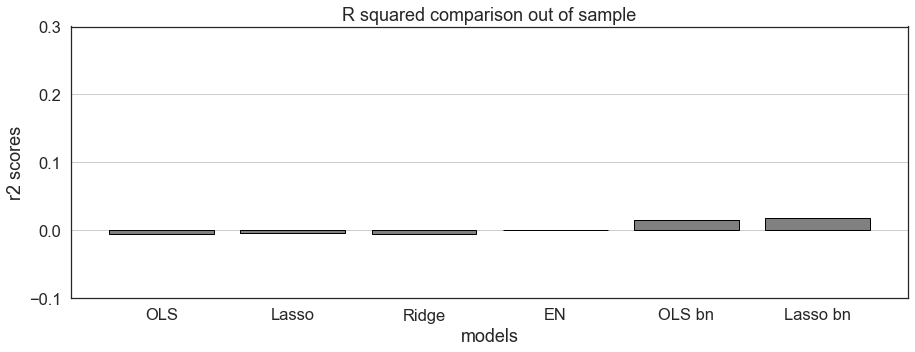

In [72]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))


ax.bar('OLS', OLS_metrics_sp.loc['r2',:].values[0], color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',Lasso_metrics_sp.loc['r2',:].values[0], color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', Ridge_metrics_sp.loc['r2',:].values[0], color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', EN_metrics_sp.loc['r2',:].values[0],color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', OLS_bnch_metrics_sp.loc['r2',:].values[0],color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', Lasso_bnch_metrics_sp.loc['r2',:].values[0], color='gray',label='Lasso bnch',edgecolor ='black')

ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='r2 scores',
      title='R squared comparison out of sample',
      yticks=np.arange(-0.1, 0.4,0.1))

plt.savefig(path_visuals/'r2_scores_req_sp.jpg', dpi=300)
plt.savefig(path_visuals/'r2_scores_reg_sp.pdf')

plt.show()

### OOS  reg

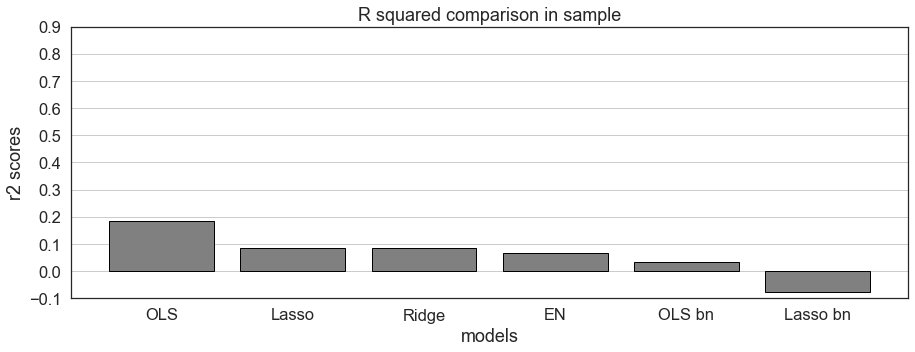

In [73]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))


ax.bar('OLS', OLS_metrics_sp.loc['r2_iss',:].values[0], color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',Lasso_metrics_sp.loc['r2_iss',:].values[0], color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', Ridge_metrics_sp.loc['r2_iss',:].values[0], color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', EN_metrics_sp.loc['r2_iss',:].values[0],color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', OLS_bnch_metrics_sp.loc['r2_iss',:].values[0],color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', Lasso_bnch_metrics_sp.loc['r2_iss',:].values[0], color='gray',label='Lasso bnch',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='r2 scores',
      title='R squared comparison in sample',
      yticks=np.arange(-0.1,1,0.1))

plt.savefig(path_visuals/'r2_scores_reg_sp_iss.jpg', dpi=300)
plt.savefig(path_visuals/'r2_scores_reg_sp_iss.pdf')

plt.show()

# R2 score ML 

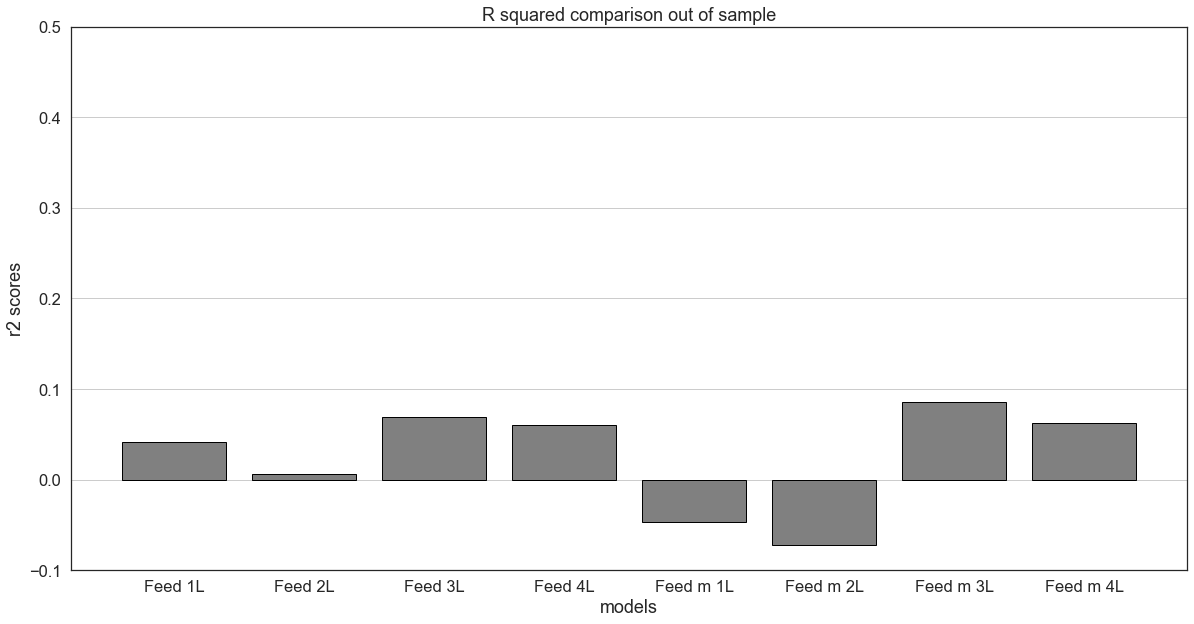

In [74]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(20,10))


ax.bar('Feed 1L', feed_1L_metrics.loc['r2',:].values[0],color='gray', label='Feed 1L',edgecolor ='black')
ax.bar('Feed 2L', feed_2L_metrics.loc['r2',:].values[0], color='gray',label='Feed 2L',edgecolor ='black')
ax.bar('Feed 3L', feed_3L_metrics.loc['r2',:].values[0], color='gray',label='Feed 3L',edgecolor ='black')
ax.bar('Feed 4L', feed_4L_metrics.loc['r2',:].values[0], color='gray',label='Feed 4L',edgecolor ='black')
ax.bar('Feed m 1L', feed_merged_1L_metrics.loc['r2',:].values[0],color='gray', label='Feed m 1L',edgecolor ='black')
ax.bar('Feed m 2L', feed_merged_2L_metrics.loc['r2',:].values[0], color='gray',label='Feed m 2L',edgecolor ='black')
ax.bar('Feed m 3L', feed_merged_3L_metrics.loc['r2',:].values[0], color='gray',label='Feed m 3L',edgecolor ='black')
ax.bar('Feed m 4L', feed_merged_4L_metrics.loc['r2',:].values[0], color='gray',label='Feed m 4L',edgecolor ='black')


ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='r2 scores',
      title='R squared comparison out of sample',
      yticks=np.arange(-0.1,0.6,0.1))

plt.savefig(path_visuals/'r2_scores_ml_feed_sp.jpg', dpi=300)
plt.savefig(path_visuals/'r2_scores_ml_feed_sp.pdf')

plt.show()

In [75]:
feed_merged_4L_metrics

,FF_merged_4L_metrics
r2,0.062498
r2_oos,0.959331
r2_adj,0.061880
r2_adj_oos,0.959304
MSE,0.788018
rss,39479.680053


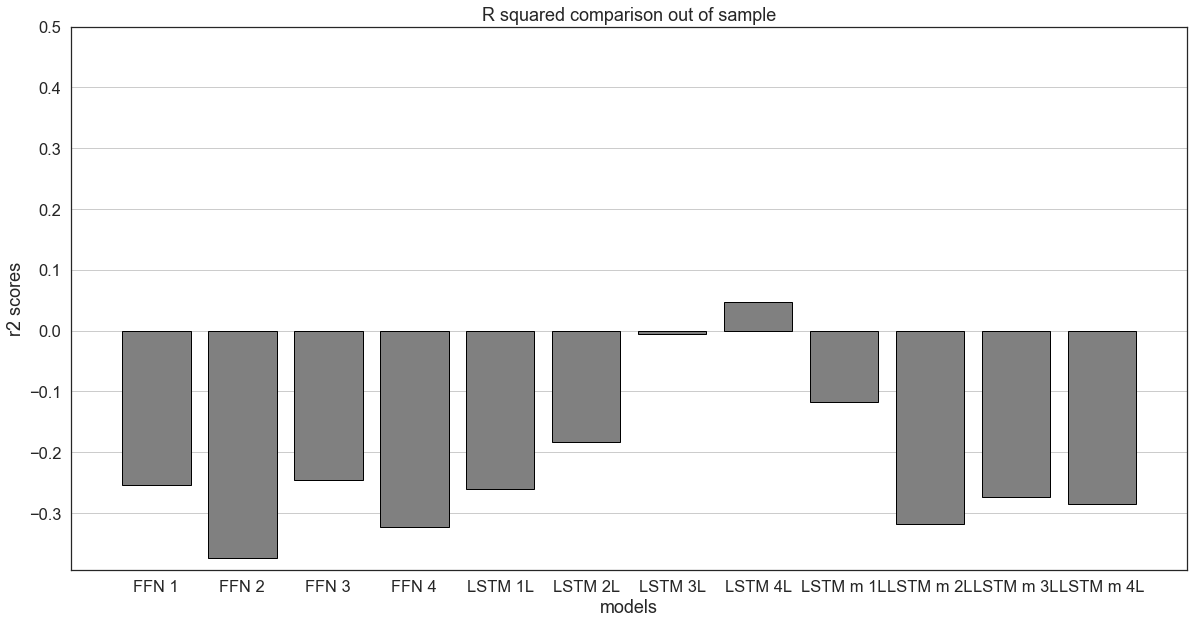

In [76]:

# index = np.arange(8)
fig, ax = plt.subplots(figsize=(20,10))

ax.bar('FFN 1', FFN_1L_metrics.loc['r2',:].values[0], color='gray', label='FFN 1',edgecolor ='black')
ax.bar('FFN 2',FFN_2L_metrics.loc['r2',:].values[0], color='gray',label='FFN 2',edgecolor ='black')
ax.bar('FFN 3', FFN_3L_metrics.loc['r2',:].values[0], color='gray',label='FFN 3',edgecolor ='black')
ax.bar('FFN 4', FFN_4L_metrics.loc['r2',:].values[0],color='gray', label='FFN 4',edgecolor ='black')
ax.bar('LSTM 1L', LSTM_1L_metrics.loc['r2',:].values[0],color='gray', label='LSTM 1L',edgecolor ='black')
ax.bar('LSTM 2L', LSTM_2L_metrics.loc['r2',:].values[0], color='gray',label='LSTM 2L',edgecolor ='black')
ax.bar('LSTM 3L', LSTM_3L_metrics.loc['r2',:].values[0], color='gray',label='LSTM 3L',edgecolor ='black')
ax.bar('LSTM 4L', LSTM_4L_metrics.loc['r2',:].values[0], color='gray',label='LSTM 4L',edgecolor ='black')
ax.bar('LSTM m 1L', LSTM_merged_1L_metrics.loc['r2',:].values[0],color='gray', label='LSTM m 1L',edgecolor ='black')
ax.bar('LSTM m 2L', LSTM_merged_2L_metrics.loc['r2',:].values[0], color='gray',label='LSTM m 2L',edgecolor ='black')
ax.bar('LSTM m 3L', LSTM_merged_3L_metrics.loc['r2',:].values[0], color='gray',label='LSTM m 3L',edgecolor ='black')
ax.bar('LSTM m 4L', LSTM_merged_4L_metrics.loc['r2',:].values[0], color='gray',label='LSTM m 4L',edgecolor ='black')


ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='r2 scores',
      title='R squared comparison out of sample',
      yticks=np.arange(-0.3,0.6,0.1))

plt.savefig(path_visuals/'r2_scores_ml_LSTM_sp.jpg', dpi=300)
plt.savefig(path_visuals/'r2_scores_ml_LSTM_sp.pdf')

plt.show()

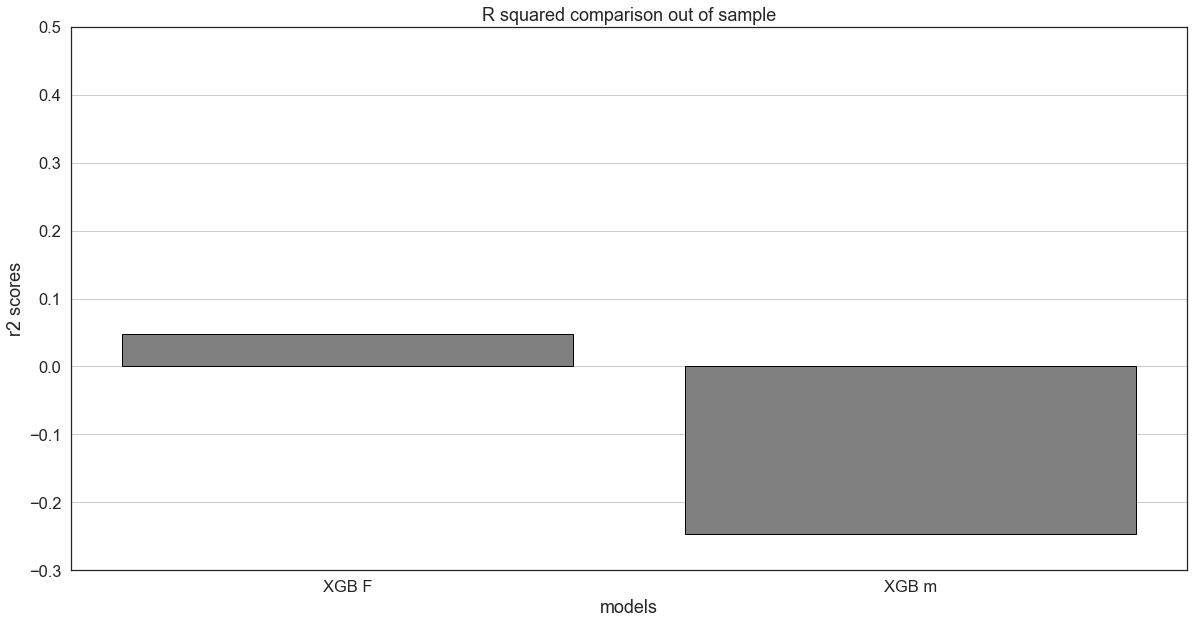

In [77]:


# index = np.arange(8)
fig, ax = plt.subplots(figsize=(20,10))

ax.bar('XGB F', xgb_factors_metrics.loc['r2',:].values[0], color='gray',label='XGB F',edgecolor ='black')
ax.bar('XGB m', xgb_merged_metrics.loc['r2',:].values[0], color='gray',label='XGB m',edgecolor ='black')

ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='r2 scores',
      title='R squared comparison out of sample',
      yticks=np.arange(-0.3,0.6,0.1))

plt.savefig(path_visuals/'r2_scores_ml_XGB_sp.jpg', dpi=300)
plt.savefig(path_visuals/'r2_scores_ml_XGB_sp.pdf')

plt.show()

## MSE 

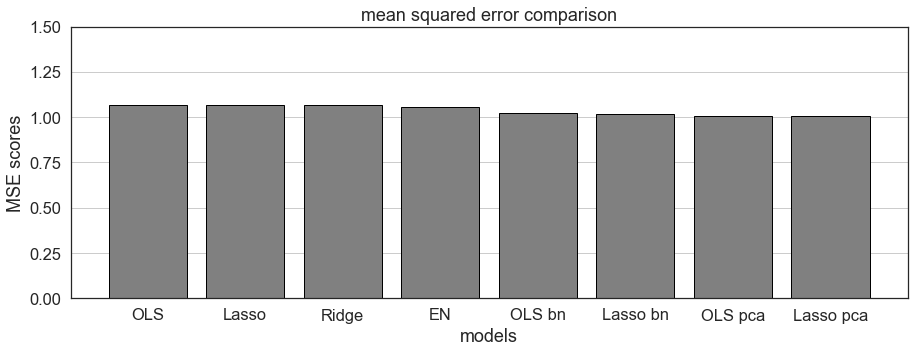

In [78]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', OLS_metrics.loc['MSE',:].values[0], color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',Lasso_metrics.loc['MSE',:].values[0], color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', Ridge_metrics.loc['MSE',:].values[0], color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', EN_metrics.loc['MSE',:].values[0],color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', OLS_bnch_metrics.loc['MSE',:].values[0],color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', Lasso_bnch_metrics.loc['MSE',:].values[0], color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', OLS_pca_metrics.loc['MSE',:].values[0], color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', Lasso_pca_metrics.loc['MSE',:].values[0], color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='MSE scores',
      title='mean squared error comparison',
      yticks=np.arange(0,1.75,0.25))

# plt.savefig(path_visuals/'mse_scores.jpg', dpi=300)
# plt.savefig(path_visuals/'mse_scores.pdf')

plt.show()

## MSE FEED

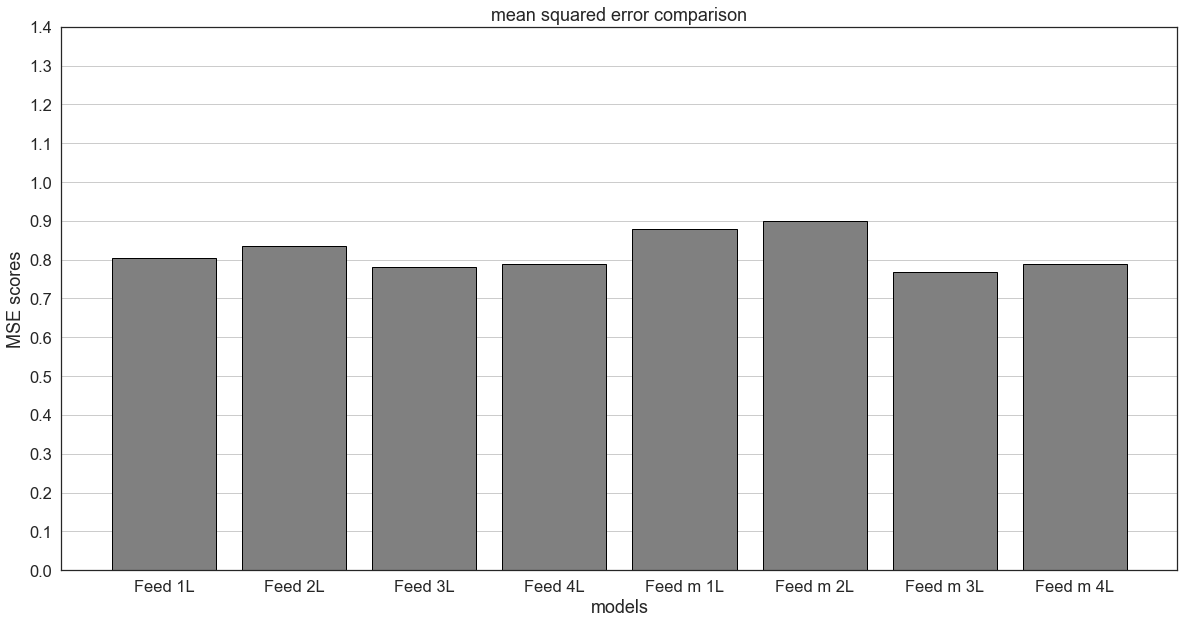

In [79]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(20,10))


ax.bar('Feed 1L', feed_1L_metrics.loc['MSE',:].values[0],color='gray', label='Feed 1L',edgecolor ='black')
ax.bar('Feed 2L', feed_2L_metrics.loc['MSE',:].values[0], color='gray',label='Feed 2L',edgecolor ='black')
ax.bar('Feed 3L', feed_3L_metrics.loc['MSE',:].values[0], color='gray',label='Feed 3L',edgecolor ='black')
ax.bar('Feed 4L', feed_4L_metrics.loc['MSE',:].values[0], color='gray',label='Feed 4L',edgecolor ='black')
ax.bar('Feed m 1L', feed_merged_1L_metrics.loc['MSE',:].values[0],color='gray', label='Feed m 1L',edgecolor ='black')
ax.bar('Feed m 2L', feed_merged_2L_metrics.loc['MSE',:].values[0], color='gray',label='Feed m 2L',edgecolor ='black')
ax.bar('Feed m 3L', feed_merged_3L_metrics.loc['MSE',:].values[0], color='gray',label='Feed m 3L',edgecolor ='black')
ax.bar('Feed m 4L', feed_merged_4L_metrics.loc['MSE',:].values[0], color='gray',label='Feed m 4L',edgecolor ='black')


ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='MSE scores',
      title='mean squared error comparison',
      yticks=np.arange(0,1.5,0.1))

plt.savefig(path_visuals/'MSE_scores_ml_feed_sp.jpg', dpi=300)
plt.savefig(path_visuals/'MSE_scores_ml_feed_sp.pdf')

plt.show()

## MSE LSTM

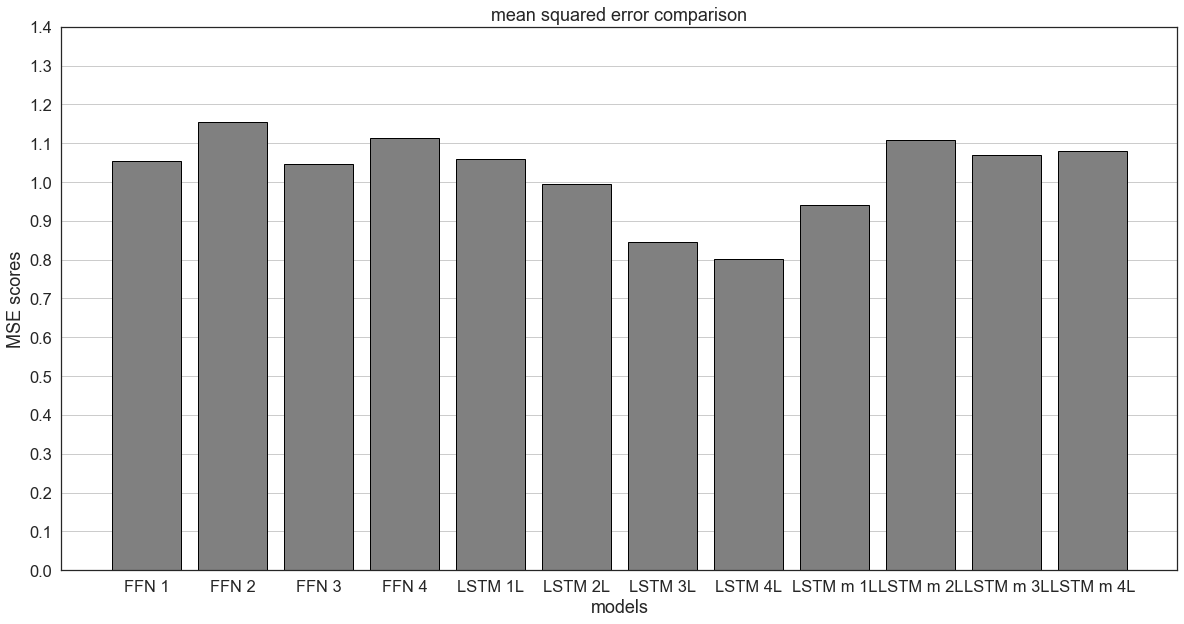

In [80]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(20,10))


ax.bar('FFN 1', FFN_1L_metrics.loc['MSE',:].values[0], color='gray', label='FFN 1',edgecolor ='black')
ax.bar('FFN 2',FFN_2L_metrics.loc['MSE',:].values[0], color='gray',label='FFN 2',edgecolor ='black')
ax.bar('FFN 3', FFN_3L_metrics.loc['MSE',:].values[0], color='gray',label='FFN 3',edgecolor ='black')
ax.bar('FFN 4', FFN_4L_metrics.loc['MSE',:].values[0],color='gray', label='FFN 4',edgecolor ='black')
ax.bar('LSTM 1L', LSTM_1L_metrics.loc['MSE',:].values[0],color='gray', label='LSTM 1L',edgecolor ='black')
ax.bar('LSTM 2L', LSTM_2L_metrics.loc['MSE',:].values[0], color='gray',label='LSTM 2L',edgecolor ='black')
ax.bar('LSTM 3L', LSTM_3L_metrics.loc['MSE',:].values[0], color='gray',label='LSTM 3L',edgecolor ='black')
ax.bar('LSTM 4L', LSTM_4L_metrics.loc['MSE',:].values[0], color='gray',label='LSTM 4L',edgecolor ='black')
ax.bar('LSTM m 1L', LSTM_merged_1L_metrics.loc['MSE',:].values[0],color='gray', label='LSTM m 1L',edgecolor ='black')
ax.bar('LSTM m 2L', LSTM_merged_2L_metrics.loc['MSE',:].values[0], color='gray',label='LSTM m 2L',edgecolor ='black')
ax.bar('LSTM m 3L', LSTM_merged_3L_metrics.loc['MSE',:].values[0], color='gray',label='LSTM m 3L',edgecolor ='black')
ax.bar('LSTM m 4L', LSTM_merged_4L_metrics.loc['MSE',:].values[0], color='gray',label='LSTM m 4L',edgecolor ='black')

ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='MSE scores',
      title='mean squared error comparison',
      yticks=np.arange(0,1.5,0.1))

plt.savefig(path_visuals/'MSE_scores_ml_LSTM_sp.jpg', dpi=300)
plt.savefig(path_visuals/'MSE_scores_ml_LSTM_sp.pdf')

plt.show()

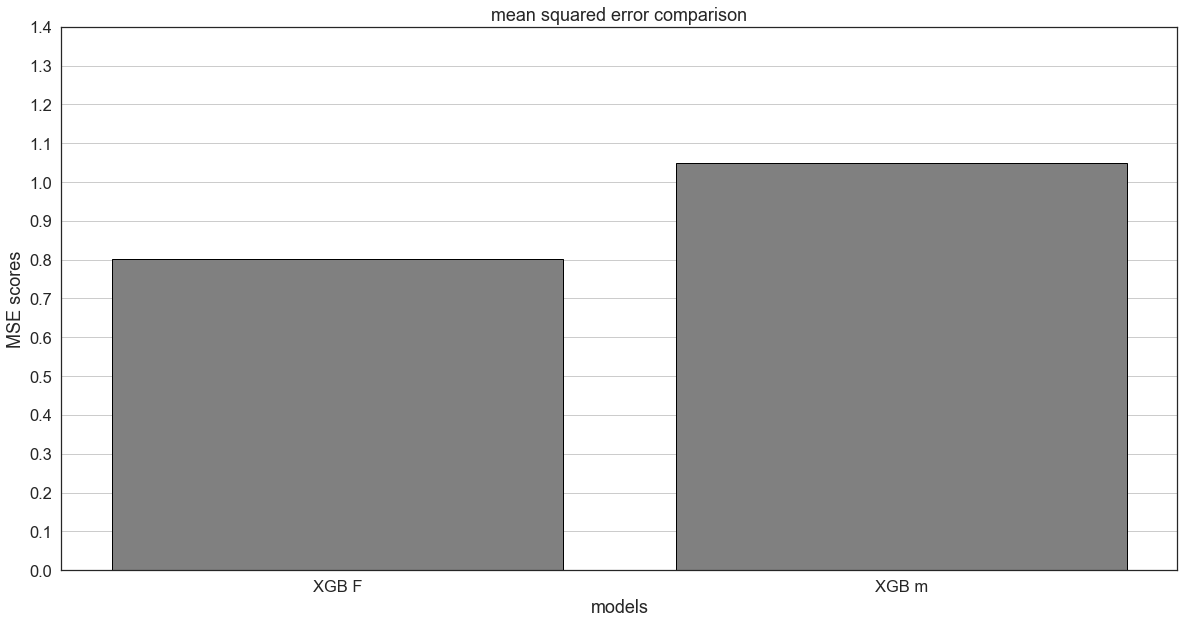

In [81]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(20,10))


ax.bar('XGB F', xgb_factors_metrics.loc['MSE',:].values[0], color='gray',label='XGB F',edgecolor ='black')
ax.bar('XGB m', xgb_merged_metrics.loc['MSE',:].values[0], color='gray',label='XGB m',edgecolor ='black')

ax.grid(axis='y')


ax.set(xlabel='models',
      ylabel ='MSE scores',
      title='mean squared error comparison',
      yticks=np.arange(0,1.5,0.1))

plt.savefig(path_visuals/'MSE_scores_ml_XGB_sp.jpg', dpi=300)
plt.savefig(path_visuals/'MSE_scores_ml_XGB_sp.pdf')

plt.show()

## Sharpe Ratio

In [82]:
def sharpe_ratio_total(df):
    ret = df.iloc[-1]-1
    std = df.std()
    if ret == 0:
         sharpe_total = 0
    else: 
        sharpe_total = ret /std
    return sharpe_total

### SR adv vweight 

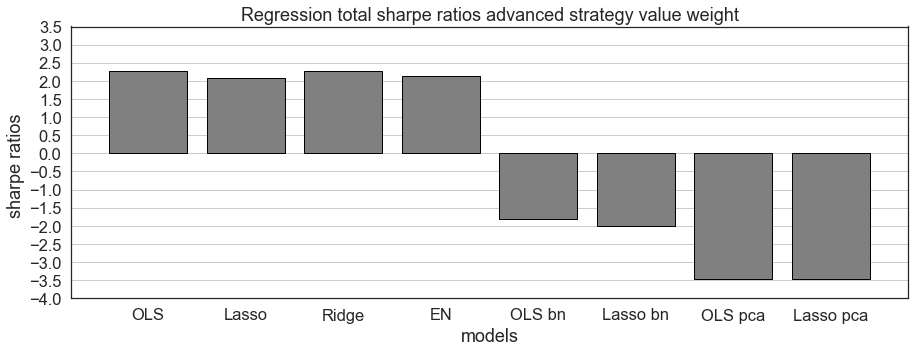

In [83]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', sharpe_ratio_total(adv_pf_ols_sp['cum_ret_vweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',sharpe_ratio_total(adv_pf_lasso_sp['cum_ret_vweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', sharpe_ratio_total(adv_pf_ridge_sp['cum_ret_vweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', sharpe_ratio_total(adv_pf_en_sp['cum_ret_vweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', sharpe_ratio_total(adv_pf_bnch_ols_sp['cum_ret_vweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', sharpe_ratio_total(adv_pf_bnch_lasso_sp['cum_ret_vweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', sharpe_ratio_total(adv_pf_ols_pca_sp['cum_ret_vweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', sharpe_ratio_total(adv_pf_lasso_pca_sp['cum_ret_vweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Regression total sharpe ratios advanced strategy value weight',
      yticks=np.arange(-4,4,0.5))

plt.savefig(path_visuals/'sharpe_adv_vweight_reg.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_vweight_reg.pdf')

plt.show()

### SR adv eqweight

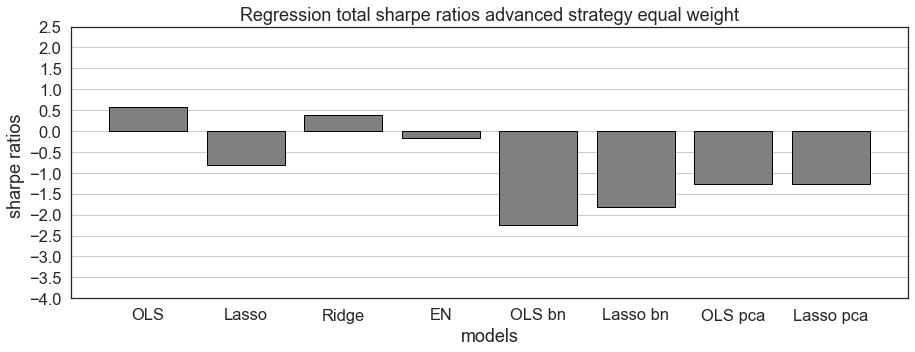

In [84]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', sharpe_ratio_total(adv_pf_ols_sp['cum_ret_eqweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',sharpe_ratio_total(adv_pf_lasso_sp['cum_ret_eqweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', sharpe_ratio_total(adv_pf_ridge_sp['cum_ret_eqweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', sharpe_ratio_total(adv_pf_en_sp['cum_ret_eqweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', sharpe_ratio_total(adv_pf_bnch_ols_sp['cum_ret_eqweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', sharpe_ratio_total(adv_pf_bnch_lasso_sp['cum_ret_eqweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', sharpe_ratio_total(adv_pf_ols_pca_sp['cum_ret_eqweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', sharpe_ratio_total(adv_pf_lasso_pca_sp['cum_ret_eqweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Regression total sharpe ratios advanced strategy equal weight',
      yticks=np.arange(-4,3,0.5))

plt.savefig(path_visuals/'sharpe_adv_eq_reg.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_eq_reg.pdf')

plt.show()

### SR Fama french vweight

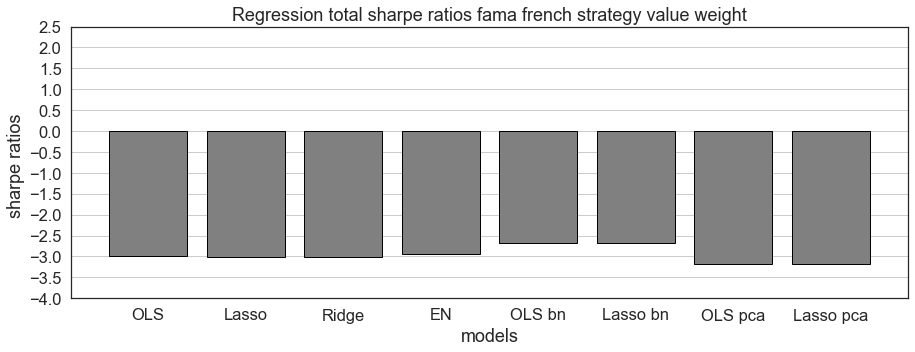

In [85]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', sharpe_ratio_total(ff_pf_ols_sp['cum_ret_vweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',sharpe_ratio_total(ff_pf_lasso_sp['cum_ret_vweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', sharpe_ratio_total(ff_pf_ridge_sp['cum_ret_vweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', sharpe_ratio_total(ff_pf_en_sp['cum_ret_vweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', sharpe_ratio_total(ff_pf_bnch_ols_sp['cum_ret_vweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', sharpe_ratio_total(ff_pf_bnch_lasso_sp['cum_ret_vweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', sharpe_ratio_total(ff_pf_ols_pca_sp['cum_ret_vweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', sharpe_ratio_total(ff_pf_lasso_pca_sp['cum_ret_vweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Regression total sharpe ratios fama french strategy value weight',
      yticks=np.arange(-4,3,0.5))

plt.savefig(path_visuals/'sharpe_ff_vweight_reg.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_vweight_reg.pdf')

plt.show()

### SR fama french eqweight

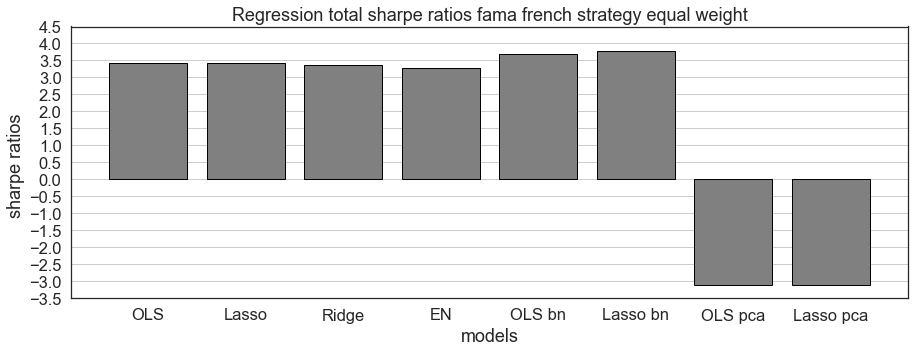

In [86]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', sharpe_ratio_total(ff_pf_ols_sp['cum_ret_eqweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',sharpe_ratio_total(ff_pf_lasso_sp['cum_ret_eqweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', sharpe_ratio_total(ff_pf_ridge_sp['cum_ret_eqweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', sharpe_ratio_total(ff_pf_en_sp['cum_ret_eqweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', sharpe_ratio_total(ff_pf_bnch_ols_sp['cum_ret_eqweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', sharpe_ratio_total(ff_pf_bnch_lasso_sp['cum_ret_eqweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', sharpe_ratio_total(ff_pf_ols_pca_sp['cum_ret_eqweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', sharpe_ratio_total(ff_pf_lasso_pca_sp['cum_ret_eqweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Regression total sharpe ratios fama french strategy equal weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_ff_eqweight.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_eqweight.pdf')

plt.show()

# SR ML 

### SR Feed adv value weight

In [87]:
adv_pf_feed_3L['cum_ret_vweight'][-1]

1

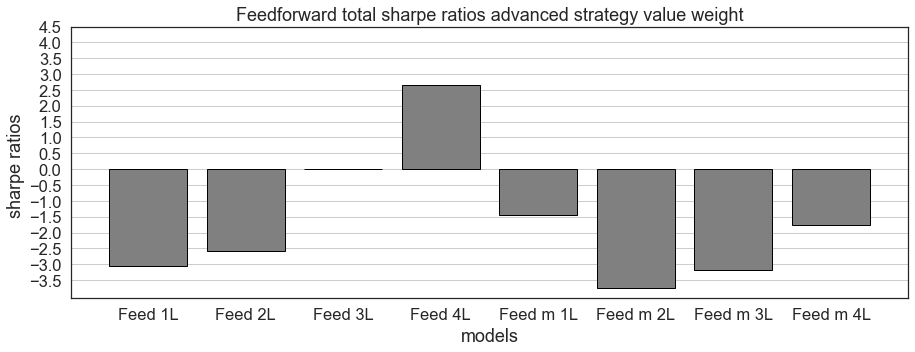

In [88]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('Feed 1L', sharpe_ratio_total(adv_pf_feed_1L['cum_ret_vweight']), color='gray', label='Feed 1L',edgecolor ='black')
ax.bar('Feed 2L',sharpe_ratio_total(adv_pf_feed_2L['cum_ret_vweight']), color='gray',label='Feed 2L',edgecolor ='black')
ax.bar('Feed 3L', sharpe_ratio_total(adv_pf_feed_3L['cum_ret_vweight']), color='gray',label='Feed 3L',edgecolor ='black')
ax.bar('Feed 4L', sharpe_ratio_total(adv_pf_feed_4L['cum_ret_vweight']),color='gray', label='Feed 4L',edgecolor ='black')
ax.bar('Feed m 1L', sharpe_ratio_total(adv_pf_feed_merged_1L['cum_ret_vweight']),color='gray', label='Feed m 1L',edgecolor ='black')
ax.bar('Feed m 2L', sharpe_ratio_total(adv_pf_feed_merged_2L['cum_ret_vweight']), color='gray',label='Feed m 2L',edgecolor ='black')
ax.bar('Feed m 3L', sharpe_ratio_total(adv_pf_feed_merged_3L['cum_ret_vweight']), color='gray',label='Feed m 3L',edgecolor ='black')
ax.bar('Feed m 4L', sharpe_ratio_total(adv_pf_feed_merged_4L['cum_ret_vweight']), color='gray',label='Feed m 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Feedforward total sharpe ratios advanced strategy value weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_adv_feed_val.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_feed_val.pdf')

plt.show()

### SR Feed adv eqweight

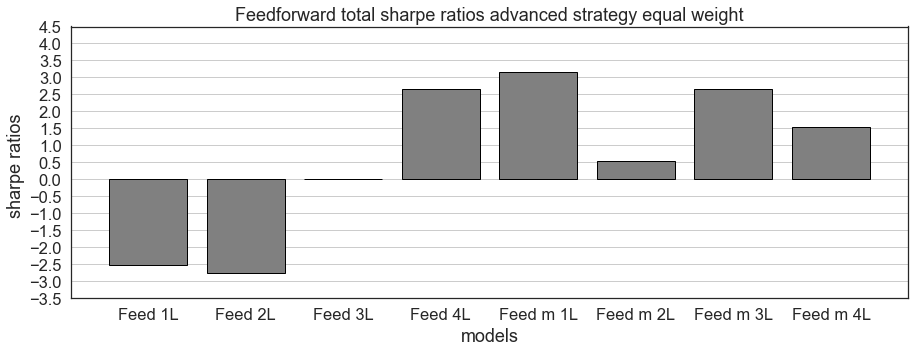

In [89]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('Feed 1L', sharpe_ratio_total(adv_pf_feed_1L['cum_ret_eqweight']), color='gray', label='Feed 1L',edgecolor ='black')
ax.bar('Feed 2L',sharpe_ratio_total(adv_pf_feed_2L['cum_ret_eqweight']), color='gray',label='Feed 2L',edgecolor ='black')
ax.bar('Feed 3L', sharpe_ratio_total(adv_pf_feed_3L['cum_ret_eqweight']), color='gray',label='Feed 3L',edgecolor ='black')
ax.bar('Feed 4L', sharpe_ratio_total(adv_pf_feed_4L['cum_ret_eqweight']),color='gray', label='Feed 4L',edgecolor ='black')
ax.bar('Feed m 1L', sharpe_ratio_total(adv_pf_feed_merged_1L['cum_ret_eqweight']),color='gray', label='Feed m 1L',edgecolor ='black')
ax.bar('Feed m 2L', sharpe_ratio_total(adv_pf_feed_merged_2L['cum_ret_eqweight']), color='gray',label='Feed m 2L',edgecolor ='black')
ax.bar('Feed m 3L', sharpe_ratio_total(adv_pf_feed_merged_3L['cum_ret_eqweight']), color='gray',label='Feed m 3L',edgecolor ='black')
ax.bar('Feed m 4L', sharpe_ratio_total(adv_pf_feed_merged_4L['cum_ret_eqweight']), color='gray',label='Feed m 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Feedforward total sharpe ratios advanced strategy equal weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_adv_feed_eq.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_feed_eq.pdf')

plt.show()

### SR Feed FF value weight

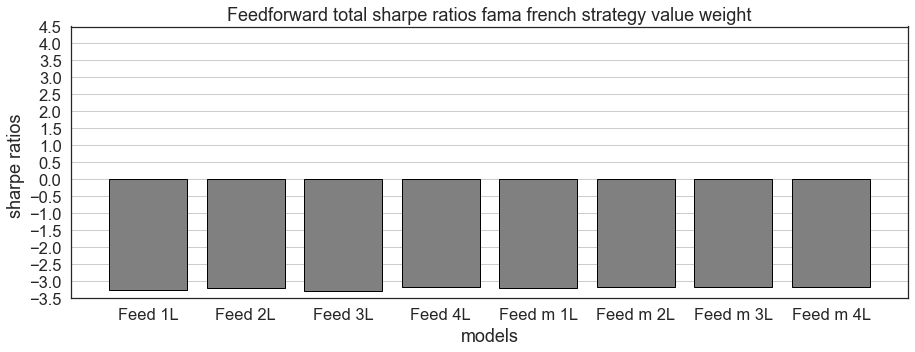

In [90]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('Feed 1L', sharpe_ratio_total(ff_pf_feed_1L['cum_ret_vweight']), color='gray', label='Feed 1L',edgecolor ='black')
ax.bar('Feed 2L',sharpe_ratio_total(ff_pf_feed_2L['cum_ret_vweight']), color='gray',label='Feed 2L',edgecolor ='black')
ax.bar('Feed 3L', sharpe_ratio_total(ff_pf_feed_3L['cum_ret_vweight']), color='gray',label='Feed 3L',edgecolor ='black')
ax.bar('Feed 4L', sharpe_ratio_total(ff_pf_feed_4L['cum_ret_vweight']),color='gray', label='Feed 4L',edgecolor ='black')
ax.bar('Feed m 1L', sharpe_ratio_total(ff_pf_feed_merged_1L['cum_ret_vweight']),color='gray', label='Feed m 1L',edgecolor ='black')
ax.bar('Feed m 2L', sharpe_ratio_total(ff_pf_feed_merged_2L['cum_ret_vweight']), color='gray',label='Feed m 2L',edgecolor ='black')
ax.bar('Feed m 3L', sharpe_ratio_total(ff_pf_feed_merged_3L['cum_ret_vweight']), color='gray',label='Feed m 3L',edgecolor ='black')
ax.bar('Feed m 4L', sharpe_ratio_total(ff_pf_feed_merged_4L['cum_ret_vweight']), color='gray',label='Feed m 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Feedforward total sharpe ratios fama french strategy value weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_ff_feed_val.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_feed_val.pdf')

plt.show()

### SR Feed FF equal

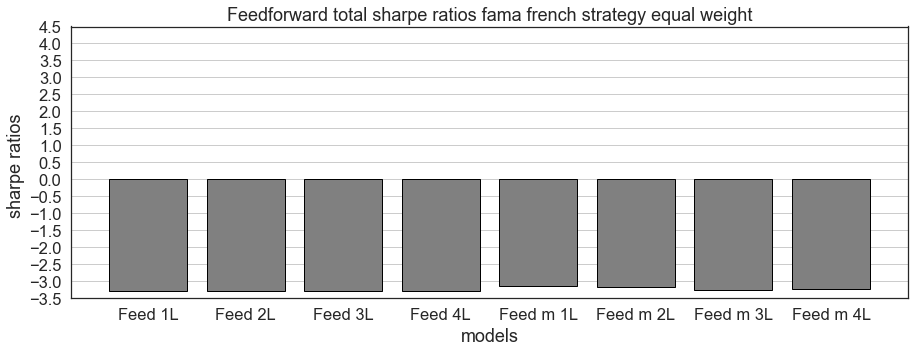

In [91]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('Feed 1L', sharpe_ratio_total(ff_pf_feed_1L['cum_ret_eqweight']), color='gray', label='Feed 1L',edgecolor ='black')
ax.bar('Feed 2L',sharpe_ratio_total(ff_pf_feed_2L['cum_ret_eqweight']), color='gray',label='Feed 2L',edgecolor ='black')
ax.bar('Feed 3L', sharpe_ratio_total(ff_pf_feed_3L['cum_ret_eqweight']), color='gray',label='Feed 3L',edgecolor ='black')
ax.bar('Feed 4L', sharpe_ratio_total(ff_pf_feed_4L['cum_ret_eqweight']),color='gray', label='Feed 4L',edgecolor ='black')
ax.bar('Feed m 1L', sharpe_ratio_total(ff_pf_feed_merged_1L['cum_ret_eqweight']),color='gray', label='Feed m 1L',edgecolor ='black')
ax.bar('Feed m 2L', sharpe_ratio_total(ff_pf_feed_merged_2L['cum_ret_eqweight']), color='gray',label='Feed m 2L',edgecolor ='black')
ax.bar('Feed m 3L', sharpe_ratio_total(ff_pf_feed_merged_3L['cum_ret_eqweight']), color='gray',label='Feed m 3L',edgecolor ='black')
ax.bar('Feed m 4L', sharpe_ratio_total(ff_pf_feed_merged_4L['cum_ret_eqweight']), color='gray',label='Feed m 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='Feedforward total sharpe ratios fama french strategy equal weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_ff_feed_eq.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_feed_eq.pdf')

plt.show()

### SR LSTM 

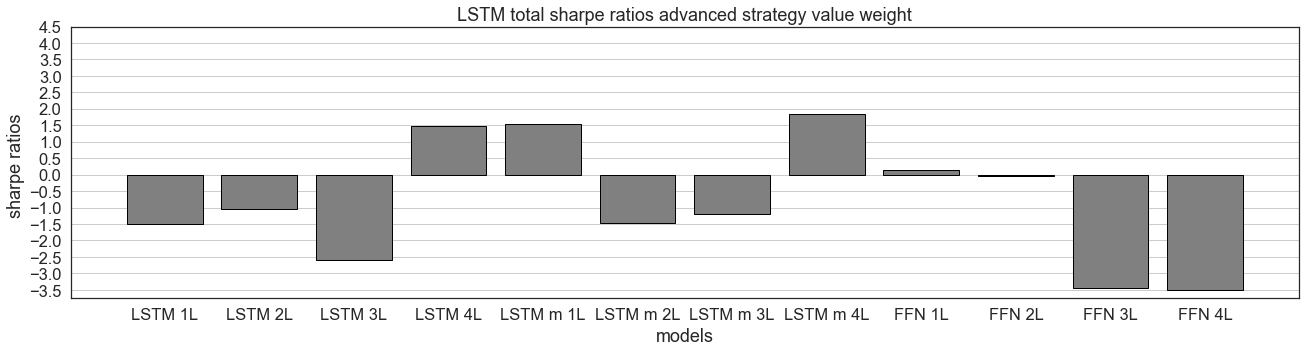

In [92]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('LSTM 1L', sharpe_ratio_total(adv_pf_lstm_1L['cum_ret_vweight']), color='gray', label='LSTM 1L',edgecolor ='black')
ax.bar('LSTM 2L',sharpe_ratio_total(adv_pf_lstm_2L['cum_ret_vweight']), color='gray',label='LSTM 2L',edgecolor ='black')
ax.bar('LSTM 3L', sharpe_ratio_total(adv_pf_lstm_3L['cum_ret_vweight']), color='gray',label='LSTM 3L',edgecolor ='black')
ax.bar('LSTM 4L', sharpe_ratio_total(adv_pf_lstm_4L['cum_ret_vweight']),color='gray', label='LSTM 4L',edgecolor ='black')
ax.bar('LSTM m 1L', sharpe_ratio_total(adv_pf_lstm_merged_1L['cum_ret_vweight']),color='gray', label='LSTM m 1L',edgecolor ='black')
ax.bar('LSTM m 2L', sharpe_ratio_total(adv_pf_lstm_merged_2L['cum_ret_vweight']), color='gray',label='LSTM m 2L',edgecolor ='black')
ax.bar('LSTM m 3L', sharpe_ratio_total(adv_pf_lstm_merged_3L['cum_ret_vweight']), color='gray',label='LSTM m 3L',edgecolor ='black')
ax.bar('LSTM m 4L', sharpe_ratio_total(adv_pf_lstm_merged_4L['cum_ret_vweight']), color='gray',label='LSTM m 4L',edgecolor ='black')
ax.bar('FFN 1L', sharpe_ratio_total(adv_pf_FFN_1L['cum_ret_vweight']),color='gray', label='FFN 1L',edgecolor ='black')
ax.bar('FFN 2L', sharpe_ratio_total(adv_pf_FFN_2L['cum_ret_vweight']), color='gray',label='FFN 2L',edgecolor ='black')
ax.bar('FFN 3L', sharpe_ratio_total(adv_pf_FFN_3L['cum_ret_vweight']), color='gray',label='FFN 3L',edgecolor ='black')
ax.bar('FFN 4L', sharpe_ratio_total(adv_pf_FFN_4L['cum_ret_vweight']), color='gray',label='FFN 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='LSTM total sharpe ratios advanced strategy value weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_adv_LSTM_val.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_LSTM_val.pdf')

plt.show()

### SR advanced LSTM equal

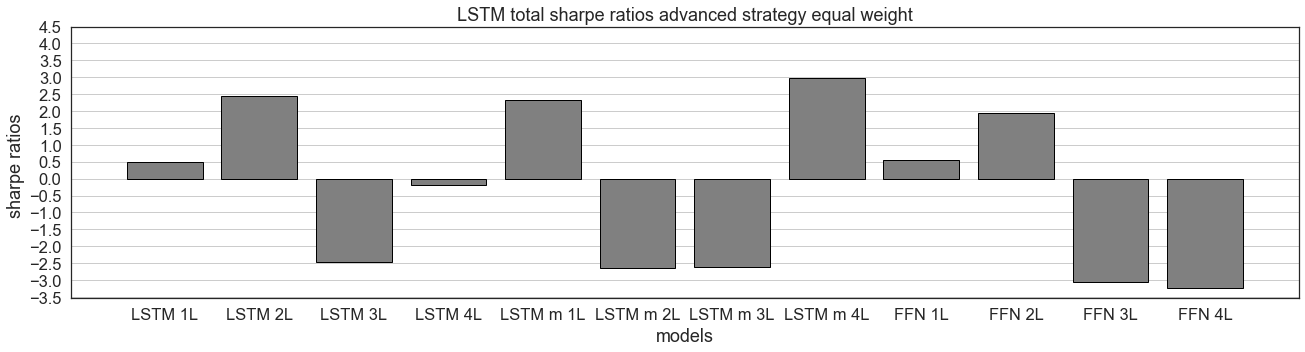

In [93]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('LSTM 1L', sharpe_ratio_total(adv_pf_lstm_1L['cum_ret_eqweight']), color='gray', label='LSTM 1L',edgecolor ='black')
ax.bar('LSTM 2L',sharpe_ratio_total(adv_pf_lstm_2L['cum_ret_eqweight']), color='gray',label='LSTM 2L',edgecolor ='black')
ax.bar('LSTM 3L', sharpe_ratio_total(adv_pf_lstm_3L['cum_ret_eqweight']), color='gray',label='LSTM 3L',edgecolor ='black')
ax.bar('LSTM 4L', sharpe_ratio_total(adv_pf_lstm_4L['cum_ret_eqweight']),color='gray', label='LSTM 4L',edgecolor ='black')
ax.bar('LSTM m 1L', sharpe_ratio_total(adv_pf_lstm_merged_1L['cum_ret_eqweight']),color='gray', label='LSTM m 1L',edgecolor ='black')
ax.bar('LSTM m 2L', sharpe_ratio_total(adv_pf_lstm_merged_2L['cum_ret_eqweight']), color='gray',label='LSTM m 2L',edgecolor ='black')
ax.bar('LSTM m 3L', sharpe_ratio_total(adv_pf_lstm_merged_3L['cum_ret_eqweight']), color='gray',label='LSTM m 3L',edgecolor ='black')
ax.bar('LSTM m 4L', sharpe_ratio_total(adv_pf_lstm_merged_4L['cum_ret_eqweight']), color='gray',label='LSTM m 4L',edgecolor ='black')
ax.bar('FFN 1L', sharpe_ratio_total(adv_pf_FFN_1L['cum_ret_eqweight']),color='gray', label='FFN 1L',edgecolor ='black')
ax.bar('FFN 2L', sharpe_ratio_total(adv_pf_FFN_2L['cum_ret_eqweight']), color='gray',label='FFN 2L',edgecolor ='black')
ax.bar('FFN 3L', sharpe_ratio_total(adv_pf_FFN_3L['cum_ret_eqweight']), color='gray',label='FFN 3L',edgecolor ='black')
ax.bar('FFN 4L', sharpe_ratio_total(adv_pf_FFN_4L['cum_ret_eqweight']), color='gray',label='FFN 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='LSTM total sharpe ratios advanced strategy equal weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_adv_LSTM_eq.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_LSTM_eq.pdf')

plt.show()

### SR LSTM FF value

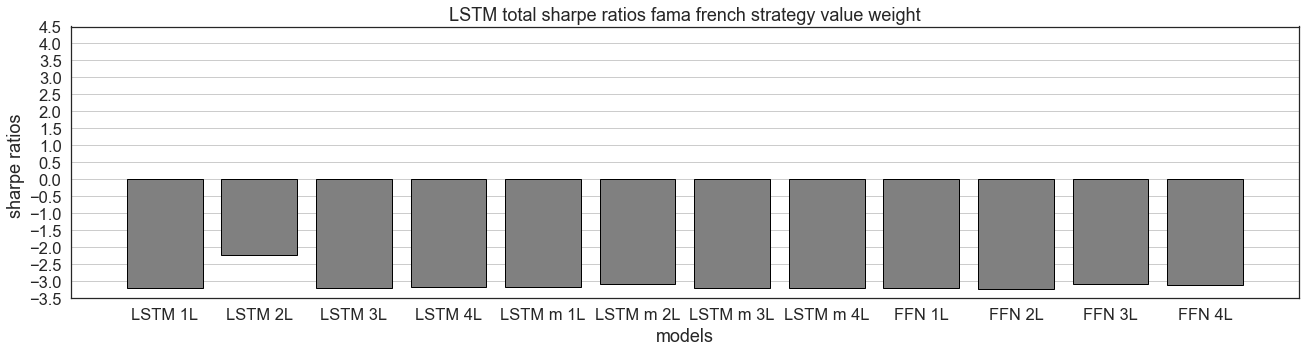

In [94]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('LSTM 1L', sharpe_ratio_total(ff_pf_lstm_1L['cum_ret_vweight']), color='gray', label='LSTM 1L',edgecolor ='black')
ax.bar('LSTM 2L',sharpe_ratio_total(ff_pf_lstm_2L['cum_ret_vweight']), color='gray',label='LSTM 2L',edgecolor ='black')
ax.bar('LSTM 3L', sharpe_ratio_total(ff_pf_lstm_3L['cum_ret_vweight']), color='gray',label='LSTM 3L',edgecolor ='black')
ax.bar('LSTM 4L', sharpe_ratio_total(ff_pf_lstm_4L['cum_ret_vweight']),color='gray', label='LSTM 4L',edgecolor ='black')
ax.bar('LSTM m 1L', sharpe_ratio_total(ff_pf_lstm_merged_1L['cum_ret_vweight']),color='gray', label='LSTM m 1L',edgecolor ='black')
ax.bar('LSTM m 2L', sharpe_ratio_total(ff_pf_lstm_merged_2L['cum_ret_vweight']), color='gray',label='LSTM m 2L',edgecolor ='black')
ax.bar('LSTM m 3L', sharpe_ratio_total(ff_pf_lstm_merged_3L['cum_ret_vweight']), color='gray',label='LSTM m 3L',edgecolor ='black')
ax.bar('LSTM m 4L', sharpe_ratio_total(ff_pf_lstm_merged_4L['cum_ret_vweight']), color='gray',label='LSTM m 4L',edgecolor ='black')
ax.bar('FFN 1L', sharpe_ratio_total(ff_pf_FFN_1L['cum_ret_vweight']),color='gray', label='FFN 1L',edgecolor ='black')
ax.bar('FFN 2L', sharpe_ratio_total(ff_pf_FFN_2L['cum_ret_vweight']), color='gray',label='FFN 2L',edgecolor ='black')
ax.bar('FFN 3L', sharpe_ratio_total(ff_pf_FFN_3L['cum_ret_vweight']), color='gray',label='FFN 3L',edgecolor ='black')
ax.bar('FFN 4L', sharpe_ratio_total(ff_pf_FFN_4L['cum_ret_vweight']), color='gray',label='FFN 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='LSTM total sharpe ratios fama french strategy value weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_ff_LSTM_val.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_LSTM_val.pdf')

plt.show()

### SR LSTM ff equal

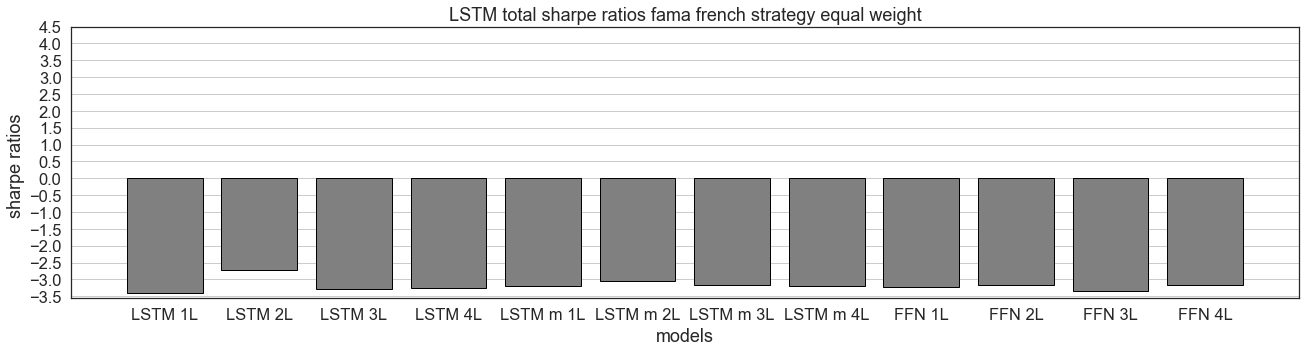

In [95]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('LSTM 1L', sharpe_ratio_total(ff_pf_lstm_1L['cum_ret_eqweight']), color='gray', label='LSTM 1L',edgecolor ='black')
ax.bar('LSTM 2L',sharpe_ratio_total(ff_pf_lstm_2L['cum_ret_eqweight']), color='gray',label='LSTM 2L',edgecolor ='black')
ax.bar('LSTM 3L', sharpe_ratio_total(ff_pf_lstm_3L['cum_ret_eqweight']), color='gray',label='LSTM 3L',edgecolor ='black')
ax.bar('LSTM 4L', sharpe_ratio_total(ff_pf_lstm_4L['cum_ret_eqweight']),color='gray', label='LSTM 4L',edgecolor ='black')
ax.bar('LSTM m 1L', sharpe_ratio_total(ff_pf_lstm_merged_1L['cum_ret_eqweight']),color='gray', label='LSTM m 1L',edgecolor ='black')
ax.bar('LSTM m 2L', sharpe_ratio_total(ff_pf_lstm_merged_2L['cum_ret_eqweight']), color='gray',label='LSTM m 2L',edgecolor ='black')
ax.bar('LSTM m 3L', sharpe_ratio_total(ff_pf_lstm_merged_3L['cum_ret_eqweight']), color='gray',label='LSTM m 3L',edgecolor ='black')
ax.bar('LSTM m 4L', sharpe_ratio_total(ff_pf_lstm_merged_4L['cum_ret_eqweight']), color='gray',label='LSTM m 4L',edgecolor ='black')
ax.bar('FFN 1L', sharpe_ratio_total(ff_pf_FFN_1L['cum_ret_eqweight']),color='gray', label='FFN 1L',edgecolor ='black')
ax.bar('FFN 2L', sharpe_ratio_total(ff_pf_FFN_2L['cum_ret_eqweight']), color='gray',label='FFN 2L',edgecolor ='black')
ax.bar('FFN 3L', sharpe_ratio_total(ff_pf_FFN_3L['cum_ret_eqweight']), color='gray',label='FFN 3L',edgecolor ='black')
ax.bar('FFN 4L', sharpe_ratio_total(ff_pf_FFN_4L['cum_ret_eqweight']), color='gray',label='FFN 4L',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='LSTM total sharpe ratios fama french strategy equal weight',
      yticks=np.arange(-3.5,5,0.5))

plt.savefig(path_visuals/'sharpe_ff_LSTM_eq.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_LSTM_eq.pdf')

plt.show()

### SR XGB  adv value

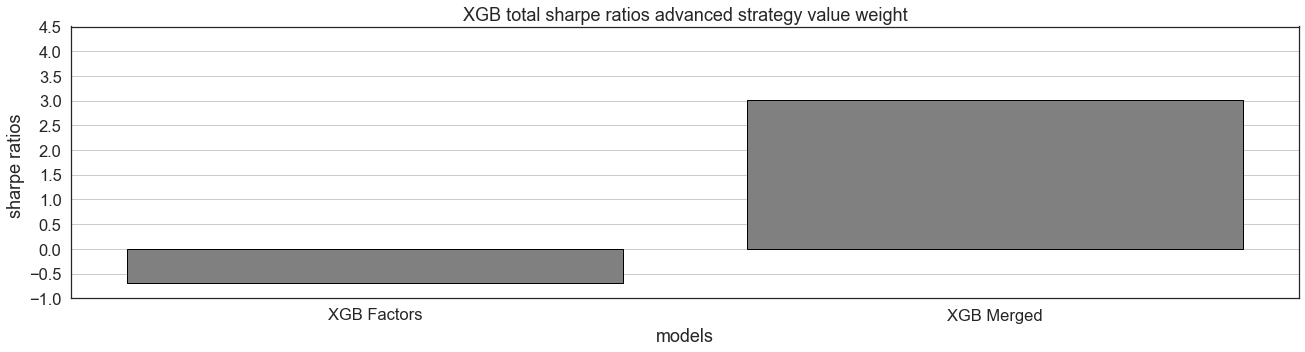

In [96]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('XGB Factors', sharpe_ratio_total(adv_pf_xgb_factors['cum_ret_vweight']), color='gray', label='XGB Factors',edgecolor ='black')
ax.bar('XGB Merged',sharpe_ratio_total(adv_pf_xgb_merged['cum_ret_vweight']), color='gray',label='XGB Merged',edgecolor ='black')
ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='XGB total sharpe ratios advanced strategy value weight',
      yticks=np.arange(-1,5,0.5))

plt.savefig(path_visuals/'sharpe_adv_XGB_val.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_XGB_val.pdf')

plt.show()

### SR XGB adv equal

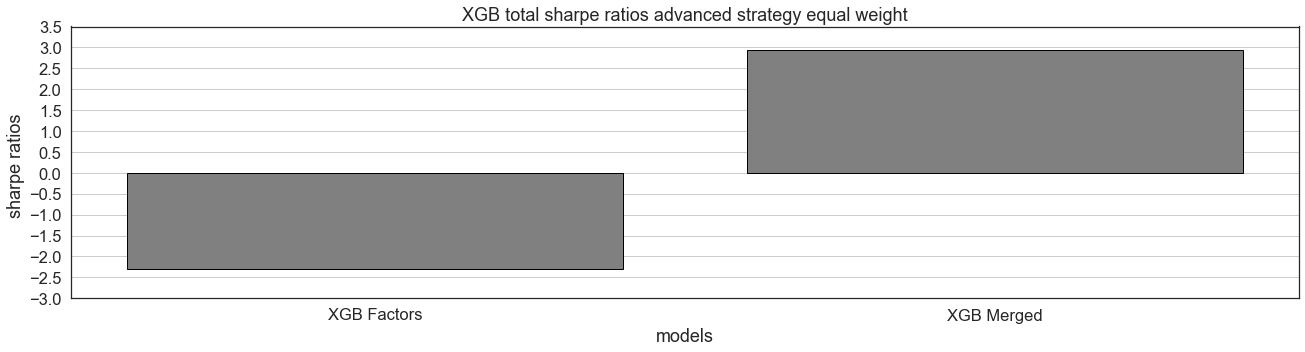

In [97]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('XGB Factors', sharpe_ratio_total(adv_pf_xgb_factors['cum_ret_eqweight']), color='gray', label='XGB Factors',edgecolor ='black')
ax.bar('XGB Merged',sharpe_ratio_total(adv_pf_xgb_merged['cum_ret_eqweight']), color='gray',label='XGB Merged',edgecolor ='black')
ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='XGB total sharpe ratios advanced strategy equal weight',
      yticks=np.arange(-3,4,0.5))

plt.savefig(path_visuals/'sharpe_adv_XGB_eq.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_adv_XGB_eq.pdf')

plt.show()

### SR XGB ff value

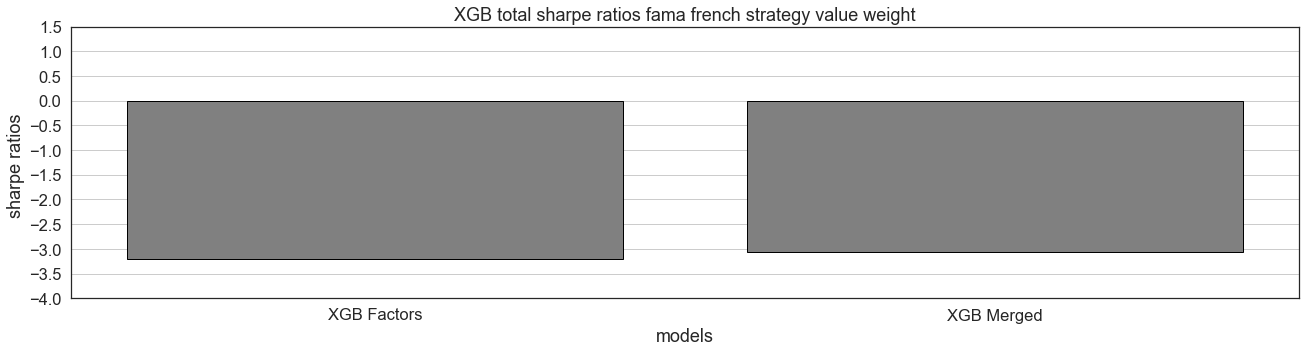

In [98]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('XGB Factors', sharpe_ratio_total(ff_pf_xgb_factors['cum_ret_vweight']), color='gray', label='XGB Factors',edgecolor ='black')
ax.bar('XGB Merged',sharpe_ratio_total(ff_pf_xgb_merged['cum_ret_vweight']), color='gray',label='XGB Merged',edgecolor ='black')
ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='XGB total sharpe ratios fama french strategy value weight',
      yticks=np.arange(-4,2,0.5))

plt.savefig(path_visuals/'sharpe_ff_XGB_val.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_XGB_val.pdf')

plt.show()

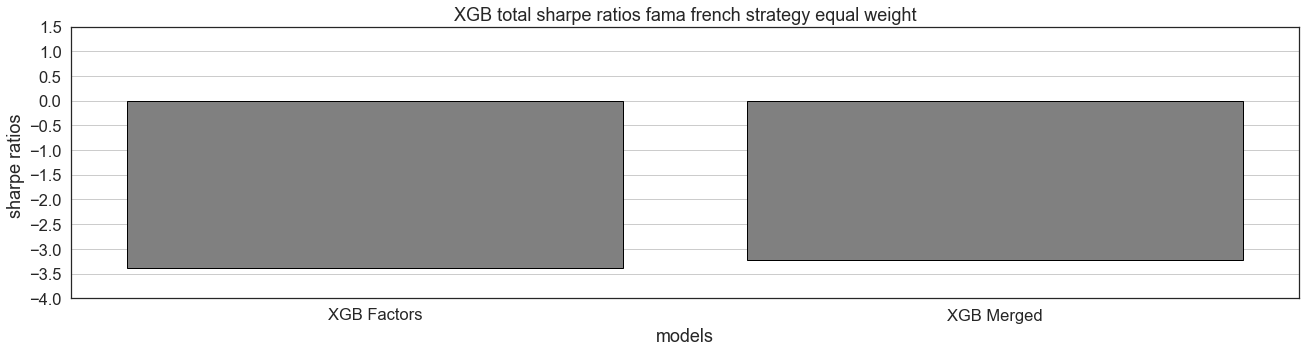

In [99]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(22,5))

ax.bar('XGB Factors', sharpe_ratio_total(ff_pf_xgb_factors['cum_ret_eqweight']), color='gray', label='XGB Factors',edgecolor ='black')
ax.bar('XGB Merged',sharpe_ratio_total(ff_pf_xgb_merged['cum_ret_eqweight']), color='gray',label='XGB Merged',edgecolor ='black')
ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='sharpe ratios ',
      title='XGB total sharpe ratios fama french strategy equal weight',
      yticks=np.arange(-4,2,0.5))

plt.savefig(path_visuals/'sharpe_ff_XGB_eq.jpg', dpi=300)
plt.savefig(path_visuals/'sharpe_ff_XGB_eq.pdf')

plt.show()

## Maximum Drawdown

In [ ]:
def MDD(df):
#     mdd = (df.max()-df.min())/df.min()
    mdd = (df.min()-df.max())/df.max()
    mdd = mdd*100
    return mdd

In [ ]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', MDD(adv_pf_ols['cum_ret_vweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',MDD(adv_pf_lasso['cum_ret_vweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', MDD(adv_pf_ridge['cum_ret_vweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', MDD(adv_pf_en['cum_ret_vweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', MDD(adv_pf_bnch_ols['cum_ret_vweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', MDD(adv_pf_bnch_lasso['cum_ret_vweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', MDD(adv_pf_ols_pca['cum_ret_vweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', MDD(adv_pf_lasso_pca['cum_ret_vweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='Maximum Drawdown in %',
      title='Maximum Drawdown advanced strategy value weight ',
      yticks=np.arange(0,-70,-10))

# plt.savefig(path_visuals/'MDD_adv_vweight.jpg', dpi=300)
# plt.savefig(path_visuals/'MDD_adv_vweight.pdf')

plt.show()

In [ ]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', MDD(adv_pf_ols['cum_ret_eqweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',MDD(adv_pf_lasso['cum_ret_eqweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', MDD(adv_pf_ridge['cum_ret_eqweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', MDD(adv_pf_en['cum_ret_eqweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', MDD(adv_pf_bnch_ols['cum_ret_eqweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', MDD(adv_pf_bnch_lasso['cum_ret_eqweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', MDD(adv_pf_ols_pca['cum_ret_eqweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', MDD(adv_pf_lasso_pca['cum_ret_eqweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='Maximum Drawdown in %',
      title='Maximum Drawdown advanced strategy equal weight',
      yticks=np.arange(0,-70,-10))

# plt.savefig(path_visuals/'MDD_adv_eq.jpg', dpi=300)
# plt.savefig(path_visuals/'MDD_adv_eq.pdf')

plt.show()

In [ ]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', MDD(ff_pf_ols['cum_ret_vweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',MDD(ff_pf_lasso['cum_ret_vweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', MDD(ff_pf_ridge['cum_ret_vweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', MDD(ff_pf_en['cum_ret_vweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', MDD(ff_pf_bnch_ols['cum_ret_vweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', MDD(ff_pf_bnch_lasso['cum_ret_vweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', MDD(ff_pf_ols_pca['cum_ret_vweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', MDD(ff_pf_lasso_pca['cum_ret_vweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='Maximum Drawdown in %',
      title='Maximum Drawdown fama french strategy value weight',
      yticks=np.arange(0,-70,-10))

# plt.savefig(path_visuals/'MDD_ff_vweight.jpg', dpi=300)
# plt.savefig(path_visuals/'MDD_ff_vweight.pdf')

plt.show()

In [ ]:
# index = np.arange(8)
fig, ax = plt.subplots(figsize=(15,5))

ax.bar('OLS', MDD(ff_pf_ols['cum_ret_eqweight']), color='gray', label='OLS',edgecolor ='black')
ax.bar('Lasso',MDD(ff_pf_lasso['cum_ret_eqweight']), color='gray',label='Lasso',edgecolor ='black')
ax.bar('Ridge', MDD(ff_pf_ridge['cum_ret_eqweight']), color='gray',label='Ridge',edgecolor ='black')
ax.bar('EN', MDD(ff_pf_en['cum_ret_eqweight']),color='gray', label='EN',edgecolor ='black')
ax.bar('OLS bn', MDD(ff_pf_bnch_ols['cum_ret_eqweight']),color='gray', label='OLS bnch',edgecolor ='black')
ax.bar('Lasso bn', MDD(ff_pf_bnch_lasso['cum_ret_eqweight']), color='gray',label='Lasso bnch',edgecolor ='black')
ax.bar('OLS pca', MDD(ff_pf_ols_pca['cum_ret_eqweight']), color='gray',label='OLS pca',edgecolor ='black')
ax.bar('Lasso pca', MDD(ff_pf_lasso_pca['cum_ret_eqweight']), color='gray',label='Lasso pca',edgecolor ='black')

ax.grid(axis='y')

ax.set(xlabel='models',
      ylabel ='Maximum Drawdown in %',
      title='Maximum Drawdown fama french strategy equal weight',
      yticks=np.arange(0,-70,-10))

# plt.savefig(path_visuals/'MDD_ff_eqweight.jpg', dpi=300)
# plt.savefig(path_visuals/'MDD_ff_eqweight.pdf')

plt.show()

## Feature importances

In [ ]:
OLS_coefs =  pd.read_csv(path_results / 'ols_coefs.csv', index_col=0)
Lasso_coefs = pd.read_csv(path_results / 'Lasso_coefs.csv', index_col=0)
Ridge_coefs = pd.read_csv(path_results / 'Ridge_coefs.csv', index_col=0)
EN_coefs = pd.read_csv(path_results / 'EN_coefs.csv', index_col=0)

OLS_bnch_coefs = pd.read_csv(path_results / 'OLS_benchmark_coefs.csv', index_col=0)
Lasso_bnch_coefs = pd.read_csv(path_results / 'Lasso_benchmark_coefs.csv', index_col=0)

OLS_pca_coefs = pd.read_csv(path_results / 'OLS_coefs_pca.csv', index_col=0)
Lasso_pca_coefs = pd.read_csv(path_results / 'Lasso_coefs.csv', index_col=0)

In [ ]:
def get_reg_coefs(df):

    for i,v in enumerate(df):
        print('Feature: %0d, Score: %.5f' % (i,v))
    
    # plot feature importance
    pyplot.bar([x for x in range(len(df))], df)
    pyplot.show()

In [ ]:
get_reg_coefs(Lasso_pca_coefs)

In [ ]:
# index = pd.to_datetime(adv_pf_market.index)

# fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(index,adv_pf_market['cum_ret_vweight'],c='b', linewidth=0.8)
# ax.plot(index,ff_pf_market['cum_ret_vweight'],c='r', linewidth=0.8)



# ax.set(xlabel='date',
#       ylabel ='cumulative return',
#       title='cumulative return value_weighted')

# ax.legend(['advanced_market_return', 'FF_market_return'])

# date_form = DateFormatter("%Y-%m")
# ax.xaxis.set_major_formatter(date_form)
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=10))

# plt.gcf().autofmt_xdate()
# plt.show()
# # plt.plot(,adv_pf_market['cum_ret_vweight'], c='r',linewidth=0.5)
# # plt.title('advanced strategy market')
# # plt.xlabel('months')
# # plt.ylabel('cumulative return')
# # plt.show()

Before running the function make sure that all returns match to the respective available permnos

In [ ]:
# def prepare_returns(df, date, model):
    
#     df = df.loc[np.logical_and(df.date >= date-pd.Timedelta(days=365*3+1), df.date <= date), :]
    
#     #daily returns
#     d_ret = pd.pivot_table(df, values='ret', index=['date'], columns=['permno'])
#     d_ret = d_ret.fillna(0.0)
    
#     #expected returns OLS
#     if model=='OLS':
#         expret = pd.pivot_table(df, values='OLS_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns Ridge
#     elif model=='Ridge':
#         expret_Ridge = pd.pivot_table(df, values='Ridge_pred', index=['date'], columns=['permno'])
#         expret_Ridge = expret.fillna(0.0)

#     #expected returns Lasso
#     elif model=='Lasso':
#         expret = pd.pivot_table(df, values='Lasso_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns LSTM factors 1L
#     elif model=='LSTM_f1L':
#         expret = pd.pivot_table(df, values='LSTM_f1L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)

#     #expected returns LSTM factors 2L
#     elif model =='LSTM_f2L':
#         expret = pd.pivot_table(df, values='LSTM_f2L_pred', index=['date'], columns=['permno'])
#         expret= expret.fillna(0.0)

#     #expected returns LSTM factors 3L
#     elif model=='LSTM_3fL':
#         expret= pd.pivot_table(df, values='LSTM_f3L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)

#     #expected returns LSTM factors 4L
#     elif model=='LSTM_4L':
#         expret = pd.pivot_table(df, values='LSTM_f4L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns LSTM merged 1L
#     elif model =='LSTM_m1L':
#         expret = pd.pivot_table(df, values='LSTM_m1L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns LSTM merged 2L
#     elif model=='LSTM_m2L':
#         expret = pd.pivot_table(df, values='LSTM_m2L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns LSTM merged 3L
#     elif model=='LSTM_m3L':
#         expret = pd.pivot_table(df, values='LSTM_m3L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns LSTM merged 4L
#     elif model =='LSTM_m4L':
#         expret = pd.pivot_table(df, values='LSTM_m4L_pred', index=['date'], columns=['permno'])
#         expret= expret.fillna(0.0)
    
#     #expected returns FFN 1L
#     elif model=='FFN_1L':
#         expret = pd.pivot_table(df, values='FFN_1L_pred', index=['date'], columns=['permno'])
#         expret= expret.fillna(0.0)
    
#     #expected returns FFN 2L
#     elif model=='FFN_2L':
#         expret = pd.pivot_table(df, values='FFN_2L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns FFN 3L
#     elif model=='FFN_3L':
#         expret = pd.pivot_table(df, values='FFN_3L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns FFN 4L
#     elif model=='FFN_4L':
#         expret = pd.pivot_table(df, values='FFN_4L_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)
    
#     #expected returns FFN 4L
#     elif model=='XGB_F':
#         expret = pd.pivot_table(df, values='XGB_F_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)

#     #expected returns FFN 4L
#     elif model=='XGB_M':
#         expret = pd.pivot_table(df, values='XGB_M_pred', index=['date'], columns=['permno'])
#         expret = expret.fillna(0.0)

    
#     #benchmark weights & returns
#     w_bch = pd.pivot_table(df, values='vweights', index=['date'], columns=['permno'])
#     w_bch = w_bch.fillna(0.0)
    
#     #return of all stocks
#     ret_bch = pd.pivot_table(df, values = 'ret', index = ['date'], columns = ['permno'])
#     ret_bch = ret_bch.fillna(0.0)
    
#     return d_ret, expret, w_bch, ret_bch

In [ ]:
# from datetime import datetime
# start_date = datetime(2020, 1, 1)
# start_date = ('2010-01-01')

# ret, expret, w_bch, ret_bch = prepare_returns(data_pf, start_date, 'OLS')

In [ ]:
# #daily returns benchmark portfolio
# dates = data_pf.loc[(data_pf.date>=start_date).date.unique()

# #creation of benchmark portfolio returns
# bch_pf_ret= pd.DataFrame(dates)
# bch_pf_ret = bch_pf_ret.rename(columns={0:'date'})

# bch_pf_ret['bch_pf_ret']=0
# for i in range(len(w_bch)):
#     bch_pf_ret['bch_pf_ret'].loc[i] = w_bch.iloc[i]@ret_bch.iloc[i]
    
# bch_pf_ret['1+bch_pf_ret'] = bch_pf_ret['bch_pf_ret']+1
# bch_pf_ret['cum_ret'] = bch_pf_ret['1+bch_pf_ret'].cumprod()

# #resampling to busienss month and calculating cumulative returns
# bch_pf_m_ret = bch_pf_ret.copy()
# bch_pf_m_ret = bch_pf_m_ret.resample(on='date', rule='BM').last()

# bch_pf_m_ret['m_ret'] = bch_pf_m_ret['cum_ret'].pct_change()

# dates_m = bch_pf_m_ret['date']
# dates_d = bch_pf_ret['date']

# d_pf = []                                       
# for i in range(len(dates_m)):
#     d = np.where(bch_pf_ret.date == dates_m[i])
#     d_pf.append(d[0][0])

# bch_pf_m_ret['m_ret'].iloc[0] = (bch_pf_ret['cum_ret'].iloc[d_pf[0]])-1   
# first_row = pd.DataFrame(bch_pf_ret.iloc[0].copy()).T
# # display(bch_pf_m_ret)

# pf_ret_bch = bch_pf_m_ret.loc[:,['date','m_ret']].copy()
# pf_ret_bch = pf_ret_bch.set_index('date') 

# monthly_returns_bch = []
# for i in range(len(pf_ret_bch.m_ret.values)): monthly_returns_bch.append(pf_ret_bch.m_ret.iloc[i])

# # display(monthly_returns_bch)
# display(pf_ret_bch) 


Set starting date to 2015 to assure data availability (data is available from 2012 and a 3 year lookback period is required for covariance matrix

In [ ]:
# dates_rebal =dates_m.copy()
# permnos = list(data_pf.permno.unique())


In [ ]:
# permnos = list(data_pf.permno.unique())
# dates = data_pf.loc[np.logical_and(data_pf.date >= datetime(2010, 1, 1), data_pf.date < datetime(2019, 12,31)), ['date']]

# dates['month'] = dates['date'].dt.to_period('m')
# months = dates['month'].unique()
# dates_rebal = []

# for month in months:
#     temp = dates[dates['month'] == month]
#     dates_rebal.append(temp.iloc[0]['date'])

In [ ]:
# def MVP(wvec,*args):
#     cov = args[0]
#     var = wvec@cov@wvec
#     return var

# def MSR(wvec,*args):
#     cov = args[0]
#     mu  = args[1]
#     sr = mu@wvec/(wvec@cov@wvec)
#     return -sr 

# # def test_strategy_mv(**kwargs):
# #     cov = kwargs.get('cov')
# #     NA = cov.shape[0]
# #     mu = kwargs.get('mu',np.ones(NA))
# #     ret_fw = kwargs.get('ret_fw',mu)
# #     method = kwargs.get('method','minvar')
    
# #     if method == 'minvar':
# #         w = np.linalg.inv(cov)@np.ones(NA)
# #         pass
# #     else:
# #         w = np.linalg.inv(cov)@mu
# #         pass
# #     w = w/np.nansum(w)
    
# #     return w@ret_fw, w


# def configure_inputs_for_optimisation(ret, expret):
#     len_ret = len(ret.columns)
#     cov = ret.cov().values
#     mu  = expret.iloc[-1].values
    
#     if np.sum(mu > 0) == 0:
#         mu -= mu.mean()
#     cons = []
#     cons.append({'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1})
#     bounds = [[-0.05,0.05] for z in range(len_ret)
    
#     return cov, mu, cons, bounds

before calculation make sure that data_pf has at least three year backward looking values

In [ ]:
# def portfolio_calculation(model, dates_rebal, data_pf)
# #     rebalancer = 1
    
#     permnos = data_pf.permno.unique()
#     ptf = {} 
#     ptf['msr_w'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
#     ptf['msr_r'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
#     ptf['msr_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
#     ptf['msr_r_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
    
    
    
#     ptf['minvar_w'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
#     ptf['minvar_r'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
#     ptf['minvar_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
#     ptf['minvar_r_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = permnos)
    
    
#     st_point_msr = None
#     st_point_mvp = None
    
#     start_weights =  permnos 
#     start_weights.insert(1, 'starting_point', 1.0/start_weights.shape[0])
#     start_weights = start_weights.set_index('permno')
#     print('start weights head: ', start_weights.head())

#     for d in dates_rebal[1:]:     
#         print(f'processing date: {d}')
# #         rebalancing_date = dates_rebal[rebalancer]
        
        
#         start_time = time.time()
        
#         #calculate forward returns, expected returns, benchmark weight and benchmark returns. All variables use a 3 year backward rolling window
#         ret, expret, w_bch, ret_bch = prepare_returns(data_pf, d,model) 
        
#         #from returns and expected returns calculate covariance and mu used for optimization 
#         cov,mu,cons,bounds = configure_inputs_for_optimisation(ret, expret)
        
#         # define portfolio starting weights
#         st_point_mvp = start_weights.loc[start_weights.index.isin(ret.columns), 'starting_point'].T.values
#         st_point_msr = start_weights.loc[start_weights.index.isin(ret.columns), 'starting_point'].T.values
        
        
#         ##################################################################### unconstrained weight optimization ########################################################
#         #calculate maximum sharpe ratio weights and returns
#         returns_msr, weights_msr = test_strategy_mv(cov=cov, mu=mu, method='msr', ret_fw=ret)
#         ptf[]
#         ptf['msr_w'].loc[d] = weights_msr
#         ptf['msr_r'].loc[d] = returns_msr
        
#         #calculate minimum variance portfolio weights and returns
#         returns_minvar, weights_minvar = test_strategy_mv(cov=cov, mu=mu, method='minvar', ret_fw=ret)
#         ptf[]
#         ptf['minvar_w'].loc[d] = weights_minvar
#         ptf['minvar_w'].loc[d] = returns_minvar
        
         
#         ################################################################### constrained weight optimization ###########################################################
#         # run optimisation, MVP
#         res = minimize(MVP,
#                     st_point_mvp,
#                     args = (cov, mu), 
#                     constraints = cons,
#                     bounds=bounds,
#                     method = 'SLSQP',
#                     options={'ftol': 1e-16, 'disp': False})
#         print("MVP: " + res.message)
#         # store results
#         i = 0
#         for col in ret.columns:
#             ptf['minvar_w_cons'].loc[d, col] = res.x[i]
#             i += 1


#         # run optimisation, MSR
#         res = minimize(MSR,
#                     st_point_msr,
#                     args = (cov, mu), 
#                     constraints = cons,
#                     bounds=bounds,
#                     method = 'SLSQP',
#                     options={'ftol': 1e-16, 'disp': False})
#         print("MSR: " + res.message)
#         # store results
#         i = 0
#         for col in ret.columns:
#             ptf['msr_w_cons'].loc[d, col] = res.x[i]
#             i += 1
            
# #         rebalancer = rebalancer+1    #needed for 1 month calculation
#         print("--- %s seconds ---" % (time.time() - start_time))
        
#     return ptf

In [ ]:
# ptf_ols = portfolio_calculation('OLS', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('Ridge', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('Lasso', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_f1L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_f2L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_f3L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_f4L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_m1L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_m2L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_m3L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('LSTM_m4L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('FFN_1L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('FFN_2L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('FFN_3L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('FFN_4L', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('XGB_F_pred', dates_rebal, data_pf)
# ptf_ols = portfolio_calculation('XGB_M_pred', dates_rebal, data_pf)

In [ ]:
# def clc_str_return(w, ret, str_name):
#     w_i = np.zeros(len(ret.columns.tolist()))
#     ret_str = pd.DataFrame(index = ret.index, columns=[str_name])
#     for i in ret.index:
#         ret_str.loc[i, str_name] = w_i@ret.loc[i,:]

#         if i in w.index:
#             w_i = w.loc[i,:]
#             if str_name == "minvar_w":
#                 neg         =   w_i.lt(0).sum().sum()       # to get the number of weights which are less than 0, i.e. negative
#                 pos         =   w_i.gt(0).sum().sum()       # to get the number of weights which are greater than 0, i.e. positive
#                 w_i[w_i>0]  =   w_i[w_i>0]/pos
#                 w_i[w_i<0]  =   w_i[w_i<0]/neg
            
#     return ret_str

In [ ]:
# w_bch_m = w_bch.loc[w_bch.index.isin(dates_rebal)]

# ret_str = clc_str_return(ptf['msr_w'], ret, 'msr')
# ret_str = ret_str.join(clc_str_return(ptf['minvar_w_cons'], ret, 'minvar'))
# ret_str = ret_str.join(clc_str_return(w_bch_m, ret, 'Benchmark'))


In [ ]:
# ptf['msr_w_cons']    #no weights for january and february since we start optimizing in march due to the t-1 benchmark return 

In [ ]:
# benchmark_cum_ret = (ret_str['Benchmark']+1).cumprod()
# msr_cum_ret = (ret_str['msr_w_cons']+1).cumprod()
# mvp_cum_ret = (ret_str['minvar_w_cons']+1).cumprod()

In [ ]:
# plt.figure(figsize=(14,8))
# plt.plot(benchmark_cum_ret, label='Benchmark', linewidth=1)
# plt.plot(msr_cum_ret, label='MSR',linewidth=1)
# plt.plot(mvp_cum_ret, label = 'MVR', linewidth=1)
# plt.legend()
# plt.show()